In [395]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import math
import shap
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score,mean_squared_error, precision_score, recall_score,confusion_matrix,f1_score,r2_score,log_loss,brier_score_loss
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTEENN  
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler,QuantileTransformer
import tensorflow as tf
import warnings
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import LSTM, Dense
import lightgbm as lgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.ensemble import VotingClassifier
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from scipy.interpolate import interp2d
warnings.filterwarnings('ignore')
import os
from mplsoccer.pitch import Pitch
from sklearn.metrics import classification_report
#from IPython.display import display


print("Imported")

Imported


In [335]:
# Loading the SHOT EVENTS dataset

dataset = pd.read_csv('Shots_leagues_14_20.csv')
dataset1 = pd.read_csv('Shots_leagues_14_20.csv')

#Loading Club Ratings dataset

data_team_ratings =  pd.read_csv('FIFA_Club_Ratings.csv')
data_team_ratings1 =  pd.read_csv('FIFA_Club_Ratings.csv')

#Loading the FIFA PLAYER & TEAM RATINGS Dataset

FIFA_database = pd.read_csv('players19_1.csv')
FIFA_database1 = pd.read_csv('players19_1.csv')

print("DATASETS Imported")



DATASETS Imported


In [336]:
# Data preprocessing and feature engineering


dataset['X_coord'] = dataset['X_coord'].round(2)
dataset['Y_coord'] = dataset['Y_coord'].round(2)
dataset['Y_coord_angle'] = (1 - abs(dataset['Y_coord'] - 0.50) * 2).round(2)

dataset['is_goal'] = dataset['Result'].apply(lambda x: 1 if x in ['Goal'] else 0)
dataset['is_home'] = dataset['Home/Away'].apply(lambda x: 1 if x in ['h'] else 0)
dataset['is_head'] = dataset['Shot Type'].apply(lambda x: 1 if x in ['Head', 'OtherBodyPart'] else 0)

dataset['Player Team'] = dataset.apply(lambda row: row['Home Team'] if row['Home/Away'] == 'h' else row['Away Team'], axis=1)
dataset['Opponent Team'] = dataset.apply(lambda row: row['Home Team'] if row['Home/Away'] == 'a' else row['Away Team'], axis=1)

dataset['is_OpenPlay'] = dataset['Situation'].apply(lambda x: 1 if x in ['OpenPlay'] else 0)
dataset['is_Penalty'] = dataset['Situation'].apply(lambda x: 1 if x in ['Penalty'] else 0)

dataset['is_FromCorner'] = dataset['Situation'].apply(lambda x: 1 if x in ['FromCorner'] else 0)
dataset['is_SetPiece'] = dataset['Situation'].apply(lambda x: 1 if x in ['SetPiece'] else 0)
dataset['is_DirectFreekick'] = dataset['Situation'].apply(lambda x: 1 if x in ['DirectFreekick'] else 0)

Last_Action_conditions = {
    'BlockedPass': 1, 'Interception': 1, 'Dispossessed': 1, 'LayOff': 1,
    'BallTouch': 1, 'CornerAwarded': 1, 'End': 1, 'Foul': 1, 'Goal': 1,
    'SubstitutionOff': 1, 'SubstitutionOn': 1, 'Tackle': 1, 'None': 1,
    'BallRecovery': 2, 'Aerial': 3, 'Chipped': 4, 'Throughball': 5,
    'TakeOn': 6, 'Rebound': 7, 'Standard': 8, 'Cross': 9,
    'Pass': 10, 'HeadPass': 10
}


dataset['Last_Action'] = dataset['Last Action'].apply(lambda x: Last_Action_conditions.get(x, 0))
dataset['Player name'] = dataset['Player name'].str.lower()


team_rating_dict = dict(zip(data_team_ratings['club_team'], data_team_ratings['club_rating']))
dataset['Team_rating'] = dataset['Player Team'].map(team_rating_dict)
dataset['Opponent_rating'] = dataset['Opponent Team'].map(team_rating_dict)
dataset['Team_rating'].fillna(80, inplace=True)
dataset['Opponent_rating'].fillna(80, inplace=True)

dataset['Player Assisted'].fillna("N/A", inplace=True)


print(" Data preprocessing and feature engineering")



 Data preprocessing and feature engineering


In [337]:

FIFA_database['FIFA_name'] = FIFA_database['player_url'].apply(lambda url: url.split("/")[5].replace("-", " "))
FIFA_database['FIFA_name'] = FIFA_database['FIFA_name'].str.lower()
FIFA_database['short_name'] = FIFA_database['short_name'].str.lower()
FIFA_database['long_name'] = FIFA_database['long_name'].str.lower()

print("FIFA Dataset Modified")



FIFA Dataset Modified


In [338]:
#JOIN BOTH DATAFRAMES using PLAYER NAME

result_dataset = dataset.merge(FIFA_database, left_on='Player name', right_on='FIFA_name', how='left')
#result_dataset = dataset.merge(FIFA_database, left_on='Player Name', right_on=['FIFA_name', 'short_name', 'long_name'], how='left')
#result_dataset = dataset.merge(FIFA_database,how='left', left_on='Player name', right_on=FIFA_database.columns.isin(['FIFA_name', 'short_name', 'long_name']))
#result_dataset = pd.merge(dataset,FIFA_database, how='left', left_on='Player Name', right_on=['FIFA_name', 'short_name', 'long_name'])


# mask = (
#     dataset['Player name'].isin(FIFA_database['FIFA_name']) |
#     dataset['Player name'].isin(FIFA_database['short_name']) |
#     dataset['Player name'].isin(FIFA_database['long_name'])
# )

# Merge based on the boolean mask
#result_dataset = dataset[mask].merge(FIFA_database, how='left', left_on='Player name', right_on=['FIFA_name', 'short_name', 'long_name'])


print("Joined")

Joined


In [339]:
output_file_path = "C:/Users/Vignesh Venkataraman/OneDrive/Desktop/Msc DATA SCIENCE/Dissertation/Dataframe_mod/modified_dataset.csv"
#dataset.to_csv(output_file_path, index=False)
#FIFA_database.to_csv(output_file_path, index=False)


#data = result_dataset.copy()
data = result_dataset.dropna(subset=['overall'])
print("Copied")

data = data.fillna(0)

data.to_csv(output_file_path, index=False)
print("Result Dataset loading")

Copied
Result Dataset loading


In [340]:
#EDA

data.head(10)

Sno     ID  Minute       Result  is_goal  X_coord  Y_coord        xG  \
0     0  14511      12    SavedShot        0     0.73     0.50  0.018741   
1     1  14512      16  BlockedShot        0     0.79     0.34  0.015598   
3     3  14514      26    SavedShot        0     0.92     0.48  0.057788   
4     4  14516      33  MissedShots        0     0.92     0.59  0.048801   
5     5  14517      40  BlockedShot        0     0.77     0.47  0.030971   
6     6  14518      45  MissedShots        0     0.91     0.22  0.025596   
7     7  14520      52  BlockedShot        0     0.96     0.44  0.069479   
8     8  14521      52         Goal        1     0.95     0.54  0.576579   
9     9  14522      61  MissedShots        0     0.86     0.31  0.052529   
10   10  14523      65   ShotOnPost        0     0.77     0.40  0.069043   

        Player name Home/Away  ...  attacking_finishing movement_sprint_speed  \
0      wayne rooney         h  ...                   80                    65   
1      wayne rooney         h  ...                   80                    65   
3      wayne rooney         h  ...                   80                    65   
4      wayne rooney         h  ...                   80                    65   
5   darren fletcher         h  ...                   59                    44   
6     adnan januzaj         h  ...                   71                    76   
7        phil jones         h  ...                   44                    59   
8      wayne rooney         h  ...                   80                    65   
9     adnan januzaj         h  ...                   71                    76   
10     wayne rooney         h  ...                   80                    65   

    power_shot_power power_stamina  defending_standing_tackle  \
0                 85            67                         55   
1                 85            67                         55   
3                 85            67                         55   
4                 85            67                         55   
5                 76          63-1                       72-1   
6                 72            70                         22   
7                 68            64                         82   
8                 85            67                         55   
9                 72            70                         22   
10                85            67                         55   

   goalkeeping_diving goalkeeping_handling goalkeeping_positioning  \
0                  10                   11                       8   
1                  10                   11                       8   
3                  10                   11                       8   
4                  10                   11                       8   
5                  10                   16                      10   
6                  15                   10                      12   
7                  10                    8                      16   
8                  10                   11                       8   
9                  15                   10                      12   
10                 10                   11                       8   

   goalkeeping_reflexes        FIFA_name  
0                     7     wayne rooney  
1                     7     wayne rooney  
3                     7     wayne rooney  
4                     7     wayne rooney  
5                     9  darren fletcher  
6                     7    adnan januzaj  
7                    11       phil jones  
8                     7     wayne rooney  
9                     7    adnan januzaj  
10                    7     wayne rooney  

[10 rows x 69 columns]

In [341]:
#Column info
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61813 entries, 0 to 130120
Data columns (total 69 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Sno                        61813 non-null  int64  
 1   ID                         61813 non-null  int64  
 2   Minute                     61813 non-null  int64  
 3   Result                     61813 non-null  object 
 4   is_goal                    61813 non-null  int64  
 5   X_coord                    61813 non-null  float64
 6   Y_coord                    61813 non-null  float64
 7   xG                         61813 non-null  float64
 8   Player name                61813 non-null  object 
 9   Home/Away                  61813 non-null  object 
 10  Player ID                  61813 non-null  int64  
 11  Situation                  61813 non-null  object 
 12  Season                     61813 non-null  int64  
 13  Shot Type                  61813 non-null  ob

In [342]:
#Aggregate functions
display(data.describe())

Sno             ID        Minute       is_goal       X_coord  \
count  61813.000000   61813.000000  61813.000000  61813.000000  61813.000000   
mean    4724.609985  197948.261175     48.982674      0.106094      0.846859   
std     2726.466022  129843.601910     26.630096      0.307961      0.090451   
min        0.000000   14424.000000      0.000000      0.000000      0.010000   
25%     2383.000000   85534.000000     26.000000      0.000000      0.780000   
50%     4721.000000  182775.000000     49.000000      0.000000      0.860000   
75%     7036.000000  320422.000000     72.000000      0.000000      0.910000   
max     9913.000000  424388.000000    103.000000      1.000000      1.000000   

            Y_coord            xG     Player ID        Season      Match ID  \
count  61813.000000  61813.000000  61813.000000  61813.000000  61813.000000   
mean       0.507427      0.110670   2145.881562   2016.966237   7260.466763   
std        0.125163      0.162051   2173.570257      1.955354   4669.434834   
min        0.030000      0.000000     12.000000   2014.000000     81.000000   
25%        0.420000      0.024914    641.000000   2015.000000   3428.000000   
50%        0.500000      0.051662    986.000000   2017.000000   7345.000000   
75%        0.600000      0.097187   2382.000000   2019.000000  11709.000000   
max        1.000000      0.979887   9423.000000   2020.000000  15157.000000   

       ...  international_reputation          pace      shooting  \
count  ...              61813.000000  61813.000000  61813.000000   
mean   ...                  1.986621     71.837898     69.096015   
std    ...                  1.030860     13.127082     13.079240   
min    ...                  1.000000      0.000000      0.000000   
25%    ...                  1.000000     64.000000     64.000000   
50%    ...                  2.000000     74.000000     72.000000   
75%    ...                  3.000000     81.000000     78.000000   
max    ...                  5.000000     95.000000     91.000000   

          defending     gk_diving   gk_handling    gk_kicking   gk_reflexes  \
count  61813.000000  61813.000000  61813.000000  61813.000000  61813.000000   
mean      52.755084      0.122628      0.115688      0.117872      0.128339   
std       17.821458      2.918794      2.770089      2.802233      3.051413   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       37.000000      0.000000      0.000000      0.000000      0.000000   
50%       50.000000      0.000000      0.000000      0.000000      0.000000   
75%       70.000000      0.000000      0.000000      0.000000      0.000000   
max       88.000000     87.000000     92.000000     82.000000     89.000000   

           gk_speed  gk_positioning  
count  61813.000000    61813.000000  
mean       0.056849        0.118567  
std        1.454926        2.829251  
min        0.000000        0.000000  
25%        0.000000        0.000000  
50%        0.000000        0.000000  
75%        0.000000        0.000000  
max       60.000000       88.000000  

[8 rows x 38 columns]

In [343]:
#Summing the values
data.isna().sum()

Sno                        0
ID                         0
Minute                     0
Result                     0
is_goal                    0
                          ..
goalkeeping_diving         0
goalkeeping_handling       0
goalkeeping_positioning    0
goalkeeping_reflexes       0
FIFA_name                  0
Length: 69, dtype: int64

In [344]:
#Total Goals
Total_Goals= data['is_goal'].sum()
print('Total Goals Scored: ',Total_Goals)

#Total Penalties Attempted
Total_Pens= data['is_Penalty'].sum()
print('Total Penalties attempted: ',Total_Pens)

#Number of Penalties scored
Penalties_scored = (data['is_goal'] == 1) & (data['is_Penalty'] == 1)
Penaltiesscored = Penalties_scored.sum()
print('No. of Penalties scored: ',Penaltiesscored)



Total Goals Scored:  6558
Total Penalties attempted:  682
No. of Penalties scored:  524


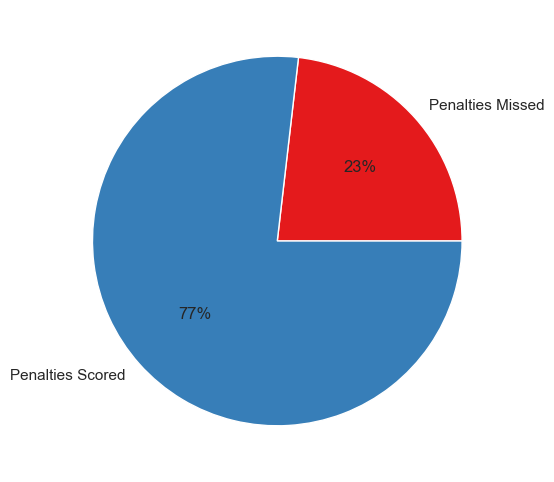

Out of a 682 spotkicks, 77% were converted and 23% were missed.


In [345]:
#Pie Chart for Penalties
pk_notscored= Total_Pens-Penaltiesscored
plt.figure(figsize=(13,6))
pendata=(pk_notscored, Penaltiesscored)
labels= ['Penalties Missed','Penalties Scored']
color= sns.color_palette('Set1')
plt.pie(pendata, colors=color, labels=labels, autopct='%.0f%%')
plt.show()


print("Out of a 682 spotkicks, 77% were converted and 23% were missed.")

Goals with assists 4629
Goals without assists 1929


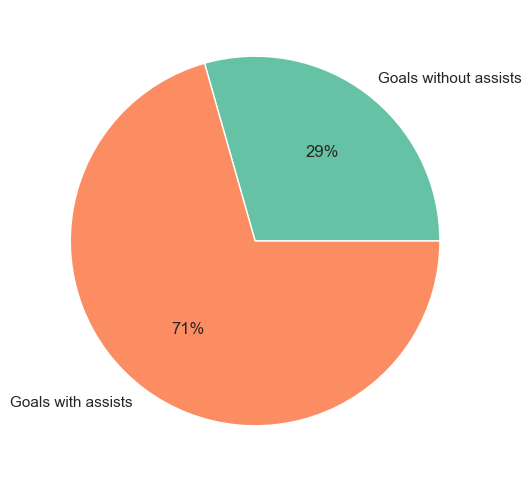

6558 goals were scored out of which 71% were assisted while 29% were solo goals.


In [346]:
goal_assist_count=((data['Player Assisted'] != 'N/A') & (data['is_goal'] == 1)).sum()
print('Goals with assists',goal_assist_count)

goal_noassist_count=((data['Player Assisted'] == 'N/A') & (data['is_goal'] == 1)).sum()
print('Goals without assists',goal_noassist_count)

plt.figure(figsize=(13,6))
data_lab=[goal_noassist_count, goal_assist_count]
labels= ['Goals without assists','Goals with assists']
color= sns.color_palette('Set2')
plt.pie(data_lab, colors=color, labels=labels, autopct='%.0f%%')
plt.show()


print("6558 goals were scored out of which 71% were assisted while 29% were solo goals.")

In [347]:
#Unique Positions
data["team_position"].unique()

array(['ST', 'SUB', 'RM', 'LB', 'RCB', 'LM', 'RES', 'LS', 'LW', 'RW',
       'RCM', 'RS', 'LCB', 'LCM', 'RDM', 'CAM', 'RB', 'LDM', 'RWB', 'CDM',
       'LWB', 'GK', 'CF', 'CB', 0, 'CM', 'LF', 'RF'], dtype=object)

In [348]:
#Total Forward Players

forward_df = data[(data['team_position'] == 'LW') | (data['team_position'] == 'RW')| (data['team_position'] == 'ST')| (data['team_position'] == 'FW')]
forward_df = forward_df.drop_duplicates(subset=['Player name'])
forward_count = forward_df.shape[0]
display(forward_df)
# print(forward_df)

Sno      ID  Minute       Result  is_goal  X_coord  Y_coord  \
0          0   14511      12    SavedShot        0     0.73     0.50   
29        29   14483      85         Goal        1     0.88     0.64   
42        42   14485      91  MissedShots        0     0.92     0.59   
55        55   14576      84  BlockedShot        0     0.96     0.66   
66        66   14568      63    SavedShot        0     0.92     0.39   
...      ...     ...     ...          ...      ...      ...      ...   
113570   179  311225      43    SavedShot        0     0.95     0.47   
113783   392  313081      84  MissedShots        0     0.91     0.56   
118373  4982  357022      85  BlockedShot        0     0.84     0.49   
122643   648  380232       1  MissedShots        0     0.86     0.40   
126010  4015  400494      87    SavedShot        0     0.90     0.59   

              xG      Player name Home/Away  ...  attacking_finishing  \
0       0.018741     wayne rooney         h  ...                   80   
29      0.297330       chris wood         h  ...                   79   
42      0.038447    romelu lukaku         a  ...                   88   
55      0.052784   junior hoilett         h  ...                   68   
66      0.478593         tom ince         a  ...                   70   
...          ...              ...       ...  ...                  ...   
113570  0.580602     luuk de jong         a  ...                   77   
113783  0.035599  pablo chavarria         h  ...                   73   
118373  0.075266     fedor smolov         a  ...                 84-2   
122643  0.069401   filip malbasic         a  ...                   72   
126010  0.396165  oussama idrissi         h  ...                   68   

       movement_sprint_speed  power_shot_power power_stamina  \
0                         65                85            67   
29                        75                80            70   
42                        90                88            84   
55                        87                76          58+3   
66                        77                70            70   
...                      ...               ...           ...   
113570                    55                82            75   
113783                    74                72            79   
118373                    85                80            74   
122643                    86              69+4            67   
126010                    83                78            66   

        defending_standing_tackle goalkeeping_diving goalkeeping_handling  \
0                              55                 10                   11   
29                             30                 14                   16   
42                             30                  8                   15   
55                             39                 11                   10   
66                             35                  9                   12   
...                           ...                ...                  ...   
113570                         40                 16                   10   
113783                         37                  9                   15   
118373                         28                 16                    9   
122643                         23                  6                    7   
126010                         22                 15                   16   

       goalkeeping_positioning goalkeeping_reflexes        FIFA_name  
0                            8                    7     wayne rooney  
29                           7                   16       chris wood  
42                           7                   10    romelu lukaku  
55                          11                    9   junior hoilett  
66                           8                    8         tom ince  
...                        ...                  ...              ...  
113570                       8                   11     luuk de jong  
11378

In [349]:
#Creating a dataframe premier_league_data to filter players from Premier League

premier_league_data = data[(data['League'] == 'Premier League')]

#Creating a dataframe la_liga_data to filter players from La Liga

la_liga_data = data[(data['League'] == 'La Liga')]

print("Premier League and La liga datframes created")


Premier League and La liga datframes created


In [350]:
print(np.size((premier_league_data['nationality'].unique())))

print("Players from 72 different nations participate in Premier League.")

72
Players from 72 different nations participate in Premier League.


In [351]:
print(np.size((la_liga_data['nationality'].unique())))

print("Players from 56 different nations participate in La Liga.")

56
Players from 56 different nations participate in La Liga.


In [352]:
print("Premier League teams")
premier_league_data['Player Team'].unique()

Premier League teams


array(['Manchester United', 'Swansea', 'Leicester', 'Everton',
       'Queens Park Rangers', 'Hull', 'Stoke', 'Aston Villa',
       'West Bromwich Albion', 'Sunderland', 'West Ham', 'Tottenham',
       'Arsenal', 'Crystal Palace', 'Liverpool', 'Southampton',
       'Newcastle United', 'Manchester City', 'Burnley', 'Chelsea',
       'Bournemouth', 'Watford', 'Norwich', 'Middlesbrough',
       'Huddersfield', 'Brighton', 'Fulham', 'Cardiff',
       'Wolverhampton Wanderers', 'Sheffield United', 'Leeds'],
      dtype=object)

In [353]:
print("La Liga teams")
la_liga_data['Player Team'].unique()

La Liga teams


array(['Malaga', 'Athletic Club', 'Sevilla', 'Valencia',
       'Deportivo La Coruna', 'Almeria', 'Real Sociedad', 'Barcelona',
       'Villarreal', 'Real Madrid', 'Cordoba', 'Atletico Madrid',
       'Getafe', 'Espanyol', 'Rayo Vallecano', 'Elche', 'Granada',
       'Levante', 'Eibar', 'Celta Vigo', 'Las Palmas', 'Sporting Gijon',
       'Real Betis', 'Osasuna', 'Alaves', 'Leganes', 'Girona',
       'Real Valladolid', 'SD Huesca', 'Mallorca', 'Cadiz'], dtype=object)

<Axes: title={'center': 'No. of Premier League players by Nation'}, xlabel='nationality'>

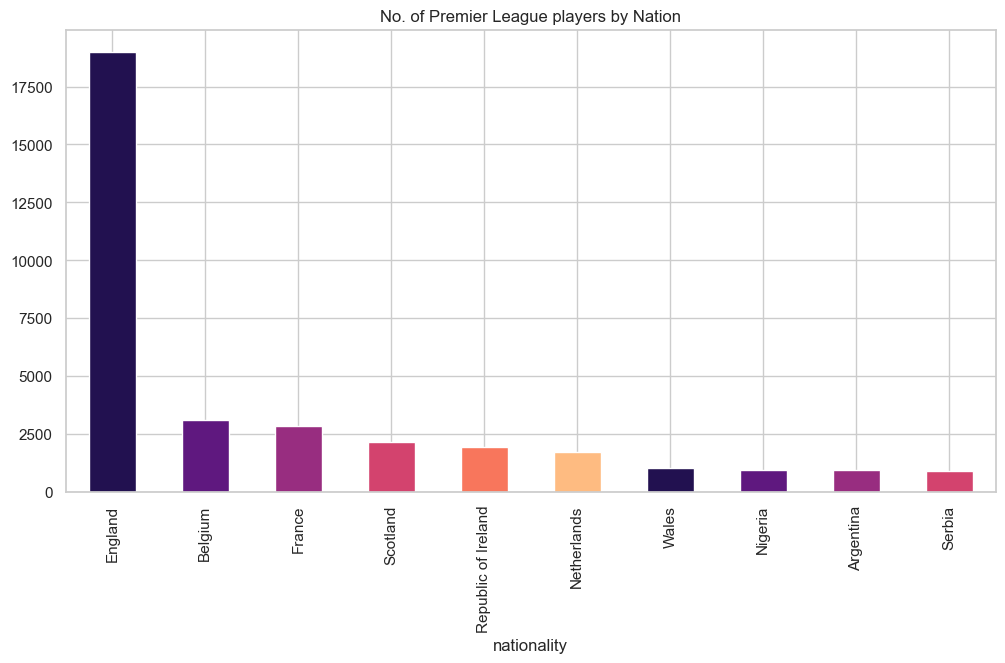

In [354]:
#Premier League Player Nationalities

nationality = premier_league_data.groupby('nationality').size().sort_values(ascending=False)
nationality.head(10).plot(title= 'No. of Premier League players by Nation', kind= 'bar', figsize= (12,6), color=sns.color_palette('magma'))

<Axes: title={'center': 'No. of La Liga players by Nation'}, xlabel='nationality'>

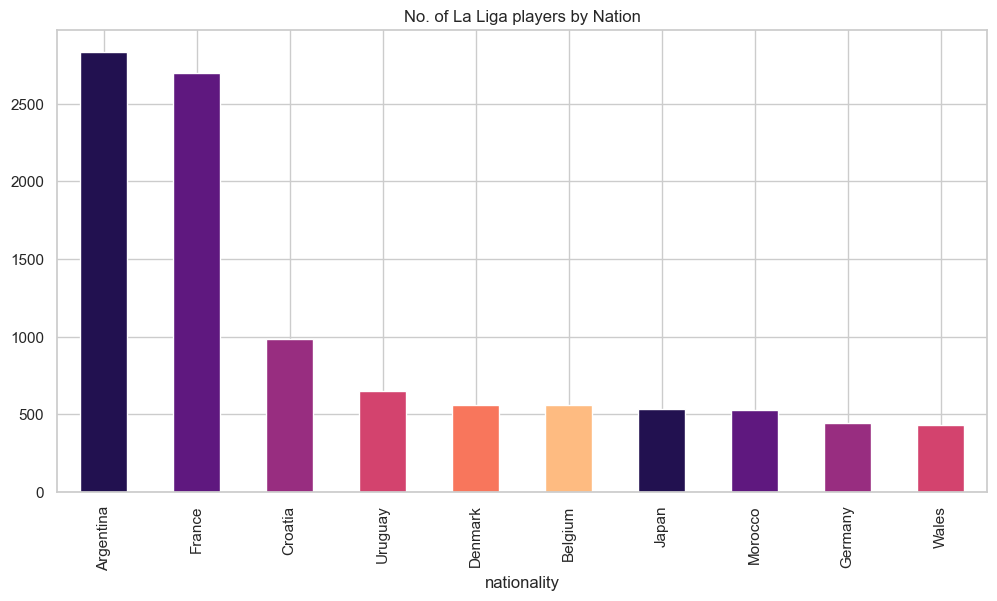

In [355]:
#La Liga Player Nationalities

nationality = la_liga_data.groupby('nationality').size().sort_values(ascending=False)
nationality.head(10).plot(title= 'No. of La Liga players by Nation', kind= 'bar', figsize= (12,6), color=sns.color_palette('magma'))

<Axes: title={'center': 'Most Chances created by Premier League Clubs in 2019'}>

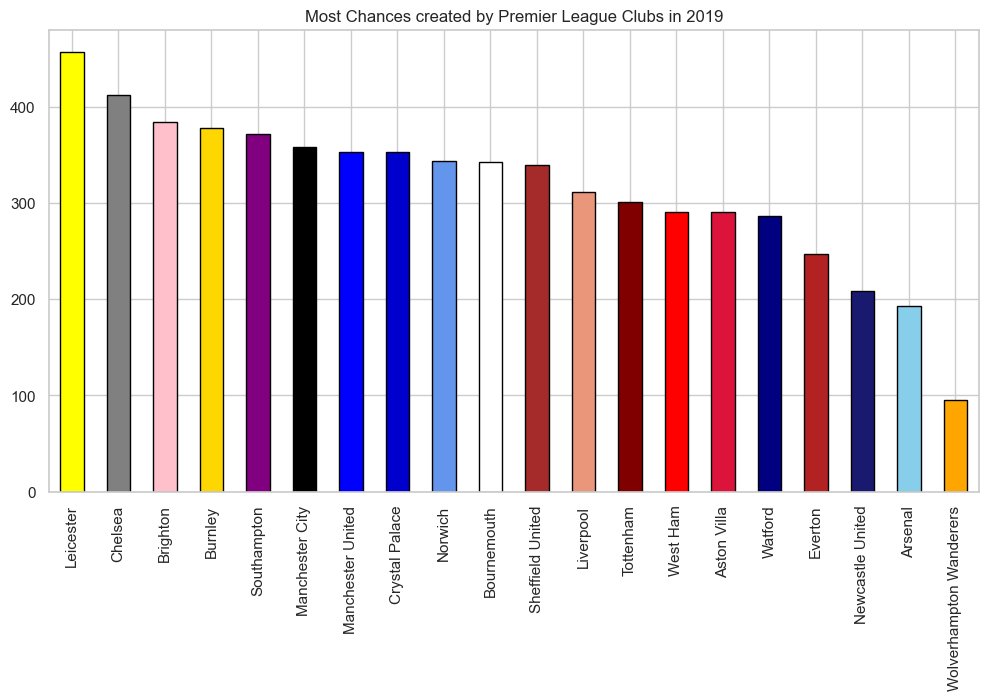

In [381]:
#Plot to display the most xG chances created i.e. the players who creates most chances to score goals

#Creating a dataframe premier_league_data to filter players from Premier League in year 2019

premier_league_data_2019 = premier_league_data[(premier_league_data['Year'] == 2019)]

unique_players_pl_2019 = premier_league_data_2019.drop_duplicates(subset=['Player name'])


# Assign default color
default_color = 'gray'

# Assign color dictionary
colors= {'Arsenal':'firebrick', 'Aston Villa':'maroon', 'Brentford':'pink', 'Brighton':'cornflowerblue',
       'Burnley':'purple','Bournemouth':'gray','Chelsea':'midnightblue', 'Crystal Palace':'blue', 'Everton':'navy', 'Leeds United':'ivory',
       'Leicester':'mediumblue', 'Liverpool':'crimson', 'Manchester City':'skyblue',
       'Manchester United':'red', 'Newcastle United':'black', 'Norwich':'yellow',
       'Southampton':'darksalmon', 'Tottenham':'white', 'Watford':'gold', 'West Ham':'brown',
       'Wolverhampton Wanderers':'orange','Sheffield United':'pink'}

# Map colors to teams
premier_league_data_2019.loc[:,'color'] = premier_league_data_2019['Player Team'].map(colors).fillna(default_color)


premier_league_data_2019['Player Team'].value_counts().plot(title= 'Most Chances created by Premier League Clubs in 2019', kind= 'bar', figsize= (12,6), color = [colors[x] for x in unique_players_pl_2019['Player Team'].value_counts().index],edgecolor = 'black')


<function matplotlib.pyplot.show(close=None, block=None)>

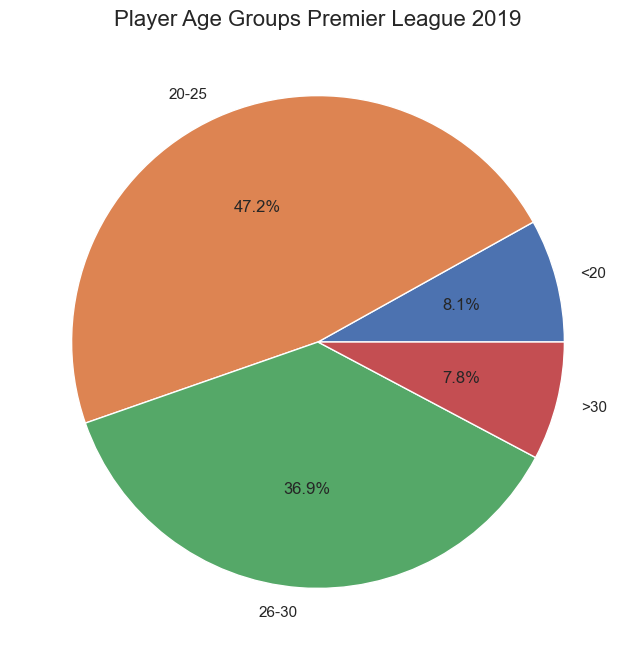

In [382]:
#Player Age Groupings

under_20= unique_players_pl_2019[unique_players_pl_2019['age']<20.0]
age20_25= unique_players_pl_2019[(unique_players_pl_2019['age']>=20.0) & (unique_players_pl_2019['age']<=25.0)]
age26_30= unique_players_pl_2019[(unique_players_pl_2019['age']>25.0) & (unique_players_pl_2019['age']<=30.0)]
above_30= unique_players_pl_2019[unique_players_pl_2019['age']>30.0]

x= np.array([under_20['Player name'].count(), age20_25['Player name'].count(), age26_30['Player name'].count(), above_30['Player name'].count()])
agelabels= ['<20','20-25','26-30','>30']
plt.title('Player Age Groups Premier League 2019', fontsize=16)
plt.pie(x, labels=agelabels, autopct='%.1f%%')
plt.show

<Axes: >

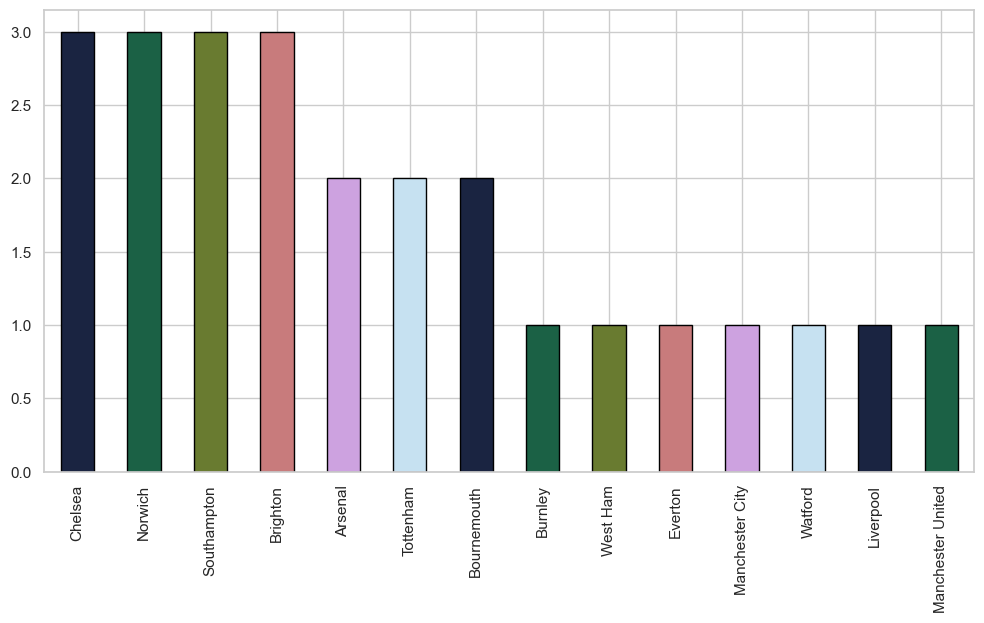

In [358]:
# Under 20 players in each club
under_20_pl= unique_players_pl_2019[unique_players_pl_2019['age']<20]
under_20_pl['Player Team'].value_counts().plot(kind='bar',figsize= (12,6), color = sns.color_palette('cubehelix'),edgecolor = 'black')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'Liverpool'),
  Text(1, 0, 'Norwich'),
  Text(2, 0, 'West Ham'),
  Text(3, 0, 'Manchester City'),
  Text(4, 0, 'Bournemouth'),
  Text(5, 0, 'Sheffield United'),
  Text(6, 0, 'Burnley'),
  Text(7, 0, 'Southampton'),
  Text(8, 0, 'Crystal Palace'),
  Text(9, 0, 'Everton'),
  Text(10, 0, 'Watford'),
  Text(11, 0, 'Brighton'),
  Text(12, 0, 'Tottenham'),
  Text(13, 0, 'Aston Villa'),
  Text(14, 0, 'Newcastle United'),
  Text(15, 0, 'Arsenal'),
  Text(16, 0, 'Leicester'),
  Text(17, 0, 'Wolverhampton Wanderers'),
  Text(18, 0, 'Manchester United'),
  Text(19, 0, 'Chelsea')])

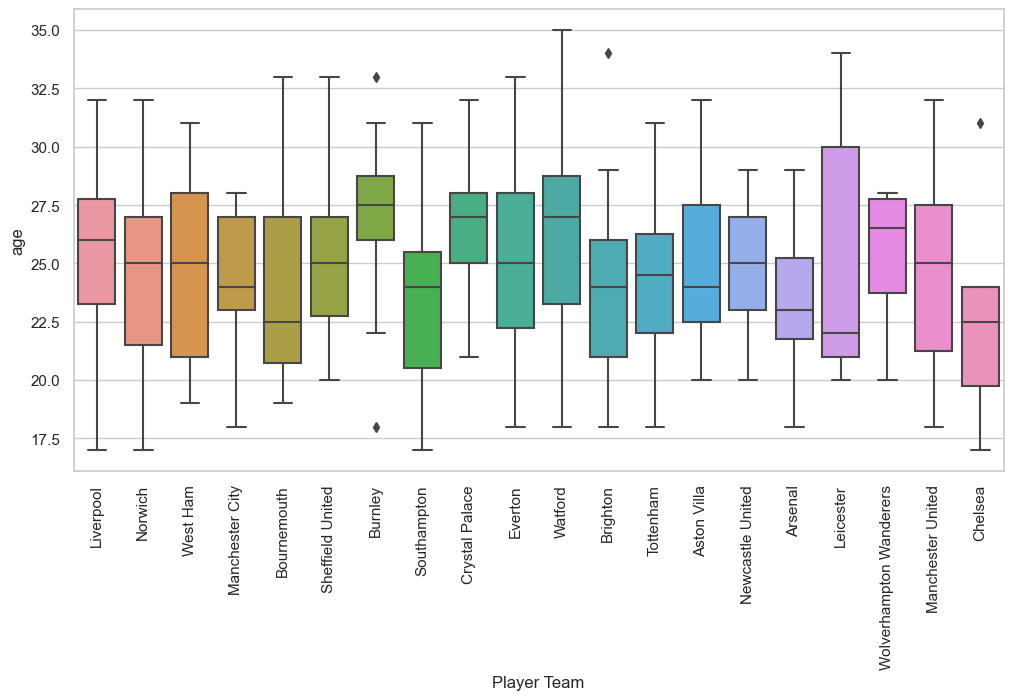

In [359]:
# Average Age
plt.figure(figsize=(12,6))
sns.boxplot(x='Player Team',y='age',data=unique_players_pl_2019)
plt.xticks(rotation=90)

In [360]:
# Average age of each Premier League club in 2019
print("Average age of each Premier League team in 2019")
player_num= unique_players_pl_2019.groupby('Player Team').size()
avg_age= (unique_players_pl_2019.groupby('Player Team')['age'].sum()) / player_num
avg_age.sort_values(ascending=False)

Average age of each Premier League team in 2019


Player Team
Burnley                    26.833333
Crystal Palace             26.823529
Watford                    26.444444
Liverpool                  25.642857
Wolverhampton Wanderers    25.333333
Sheffield United           25.300000
Everton                    25.142857
Aston Villa                25.133333
Newcastle United           25.000000
West Ham                   24.933333
Leicester                  24.882353
Norwich                    24.565217
Manchester United          24.428571
Brighton                   24.294118
Tottenham                  24.250000
Bournemouth                23.900000
Manchester City            23.888889
Southampton                23.600000
Arsenal                    23.333333
Chelsea                    22.250000
dtype: float64

In [361]:
# Most Assists by a player in Premier League in 2019 

premier_league_data_2019_GA = premier_league_data[(premier_league_data['Year'] == 2019)&(premier_league_data['is_goal'] == 1)]


# Group by "player_assist" and count occurrences
player_assist_counts = premier_league_data_2019_GA['Player Assisted'].value_counts().reset_index()
player_assist_counts.columns = ['Player Name', 'Assists']

player_assist_counts = player_assist_counts.sort_values(by='Assists', ascending=False)
player_assist_counts = player_assist_counts[player_assist_counts['Player Name'] != 'N/A']
player_assist_counts = player_assist_counts.head(10)
display(player_assist_counts)

# sns.set_theme(style='whitegrid', color_codes= True)
# ax = sns.barplot(x='Player Name', y='Assists', data=player_assist_counts.sort_values(by='Assists'), palette='Set2')
# ax.set_xlabel('Player Team', fontsize=20)
# ax.set_ylabel('Assists', fontsize=20)
# plt.xticks(rotation=90)
# plt.rcParams['figure.figsize']=(20,8)
# plt.title('Total Assists by each Player', fontsize=20)

Player Name  Assists
2            Son Heung-Min        8
1          Kevin De Bruyne        8
3   Trent Alexander-Arnold        7
4         Emiliano Buendía        7
5                  Willian        7
6         Andrew Robertson        6
7          Marcus Rashford        6
8          Ashley Westwood        6
9            Harvey Barnes        6
10           Dwight McNeil        6

In [362]:
# Most Goals by a player in Premier League in 2019 season


player_goal_counts = premier_league_data_2019_GA['Player name'].value_counts().reset_index()
player_goal_counts.columns = ['Player name', 'Goals']

player_goal_counts = player_goal_counts.sort_values(by='Goals', ascending=False)
player_goal_counts = player_goal_counts[player_goal_counts['Player name'] != 'N/A']
player_goal_counts = player_goal_counts.head(10)
display(player_goal_counts)

Player name  Goals
0      jamie vardy     23
1       danny ings     22
2  raheem sterling     20
3    mohamed salah     19
4       harry kane     18
5  anthony martial     17
6  marcus rashford     17
7    tammy abraham     15
8  kevin de bruyne     14
9       chris wood     14

In [363]:
#Players with most xG in Premier League 2019

player_goal_counts = premier_league_data_2019['Player name'].value_counts().reset_index()
player_goal_counts.columns = ['Player name', 'Goals']


# Group by "player name" and calculate the sum of "xg" for each player
player_xg_sum = premier_league_data_2019.groupby('Player name')['xG'].sum().reset_index()

# Rename the columns for clarity
player_xg_sum.columns = ['Player name', 'Total xG']
player_xg_sum = player_xg_sum.sort_values(by='Total xG', ascending=False)
player_xg_sum = player_xg_sum[player_xg_sum['Player name'] != 'N/A']
player_xg_sum = player_xg_sum.head(10)
display(player_xg_sum)

Player name   Total xG
213    mohamed salah  20.663318
244  raheem sterling  19.799907
192  marcus rashford  19.503727
134      jamie vardy  18.903537
282    tammy abraham  18.082802
49        chris wood  17.226202
67        danny ings  15.659717
226      neal maupay  13.558543
107       harry kane  13.297066
211  michail antonio  13.249549

In [364]:
# Loading the dataset
# data = pd.read_csv('Shots_leagues_14_20_cat.csv')
# data['X_coord'] = data['X_coord'].round(2)
# data['Y_coord'] = data['Y_coord'].round(2)
# data['Y_coord_angle'] = (1 - abs(data['Y_coord'] - 0.50) * 2).round(2)
# print("Dataset loading")
print(data)

#nan_counts = data.isna().sum()
#print(nan_counts)



         Sno      ID  Minute       Result  is_goal  X_coord  Y_coord  \
0          0   14511      12    SavedShot        0     0.73     0.50   
1          1   14512      16  BlockedShot        0     0.79     0.34   
3          3   14514      26    SavedShot        0     0.92     0.48   
4          4   14516      33  MissedShots        0     0.92     0.59   
5          5   14517      40  BlockedShot        0     0.77     0.47   
...      ...     ...     ...          ...      ...      ...      ...   
130103  8102  424199      19  BlockedShot        0     0.81     0.45   
130111  8110  424368       8  BlockedShot        0     0.76     0.52   
130113  8112  424371      33  MissedShots        0     0.76     0.73   
130114  8113  424374      54  BlockedShot        0     0.74     0.56   
130120  8119  424388      91         Goal        1     0.75     0.69   

              xG      Player name Home/Away  ...  attacking_finishing  \
0       0.018741     wayne rooney         h  ...              

In [365]:
# Selecting relevant features and target
# = data[['X_coord', 'Y_coord', 'is_Penalty', 'is_head','is_home','is_OpenPlay','is_DirectFreekick','is_FromCorner','is_SetPiece','is_Cross','is_Throughball']]
#features = data[['X_coord', 'Y_coord','Y_coord_angle','is_Penalty', 'is_head','is_home']]

# features = data[['X_coord', 'Y_coord','Y_coord_angle','is_Penalty', 'is_head','is_home',
#                  'is_OpenPlay','is_DirectFreekick','is_FromCorner','is_SetPiece',
#                  'overall','value_eur','shooting']]


features = data[['X_coord', 'Y_coord','Y_coord_angle','is_Penalty', 'is_head','is_home',
                 'is_OpenPlay','is_DirectFreekick','is_FromCorner','is_SetPiece',
                 'overall','value_eur','shooting','Last_Action','Team_rating','Opponent_rating']]

target = data['is_goal']
print("Feature Selection")


Feature Selection


In [367]:
# Splitting the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
def testtrainsplit():
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)
    print("Test Train Split")
    return X_train, X_test, y_train, y_test

In [369]:
# Applying oversampling using SMOTE
def sampling(X_train,y_train):
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    print("Sampling")
    undersampler = TomekLinks(sampling_strategy='majority')
    X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_resampled, y_train_resampled)
    return X_train_resampled,y_train_resampled

# ros = RandomOverSampler(random_state=42)
# X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# oversampler = SMOTE(sampling_strategy='auto', random_state=42)
# X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

#Apply undersampling using Tomek links
# undersampler = TomekLinks(sampling_strategy='majority')
# X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_resampled, y_train_resampled)



In [370]:
# Standardizing the features
#scaler = StandardScaler()

def scaling(X_train,X_train_resampled,X_test):
    scaler = MinMaxScaler()
    #scaler = RobustScaler()
    #scaler = QuantileTransformer(output_distribution='normal')
    X_train_scaled = scaler.fit_transform(X_train)
    X_train_scaled_resampled = scaler.fit_transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test)
    X_data_scaled = scaler.transform(features)  # Scale the entire feature matrix
    print("Feature Scaling")
    return scaler,X_train_scaled,X_train_scaled_resampled,X_test_scaled,X_data_scaled

In [371]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = testtrainsplit()
# Applying oversampling
X_train_resampled,y_train_resampled = sampling(X_train,y_train)
# Standardizing the features using scaler
scaler,X_train_scaled,X_train_scaled_resampled,X_test_scaled,X_data_scaled = scaling(X_train,X_train_resampled,X_test)

Test Train Split
Sampling
Feature Scaling


In [372]:
#XGBoost ALGORITHM

# Initialize and train the XGBoost classifier
xgb_model = XGBClassifier(random_state=42)
xgb_s = XGBClassifier(random_state=42)

# Training the model
xgb_model.fit(X_train, y_train)
#xgb_s.fit(X_train_resampled, y_train_resampled)
xgb_s.fit(X_train_scaled, y_train)
#xgb_s.fit(X_train_scaled_resampled, y_train_resampled)

# Predicting xG values for both training and testing sets
xG_train = xgb_model.predict_proba(X_train)[:, 1]
xG_test = xgb_model.predict_proba(X_test)[:, 1]
y_pred = xgb_model.predict(X_test)
y_preds = xgb_s.predict(X_test_scaled)
#y_preds = xgb_s.predict(X_test_scaled)

#y_pred_proba = xgb_s.predict_proba(X_test_scaled)[:,1]
y_pred_proba = xgb_s.predict_proba(X_test_scaled)[:,1]
# xG_train = xgb_model.predict_proba(X_train_scaled)[:, 1]
# xG_test = xgb_model.predict_proba(X_test_scaled)[:, 1]
# y_pred = xgb_model.predict(X_test_scaled)

# Combinining xG values for the entire dataset
#xG_all = xgb_model.predict_proba(features)[:, 1]
#xG_all = xgb_s.predict_proba(X_data_scaled)[:, 1]  # Directly use predict_proba on the scaled features
#xG_all = xgb_s.predict_proba(features)[:, 1]
#data['xG_calc_xgb'] = xG_all
#X_test['xG_calc'] = y_pred_proba

print("xG Boost model Prediction")
#print(X_test['xG_calc'])

xG Boost model Prediction


In [373]:
#XGBOOST HYPER PARAMETER TUNING


# Hyperparameter tuning using GridSearchCV
# param_grid = {
#     'max_depth': [3, 4, 5],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'n_estimators': [100, 200, 300]
# }


param_grid = {
    'max_depth': [4],
    'learning_rate': [0.1],
    'n_estimators': [100]
}


# Define the parameter grid to search
# param_grid = {
#     'max_depth': [3, 5, 7],
#     'min_child_weight': [1, 3, 5],
#     'gamma': [0, 0.1, 0.2],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0],
#     'learning_rate': [0.01, 0.1, 0.2]
# }

# Initializing GridSearchCV
grid_search = GridSearchCV(estimator=xgb_s, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
# grid_search = GridSearchCV(xgb_s, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)

# grid_search = GridSearchCV(xgb_s, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
#grid_search.fit(X_train_scaled, y_train_resampled)
grid_search.fit(X_train_scaled, y_train)

#Best parameters
print("Best Parameters:", grid_search.best_params_)

# Initializing the XGBoost model with best parameters
best_params = grid_search.best_params_
final_xgb_model = xgb.XGBClassifier(**best_params, random_state=42)
# final_xgb_model.fit(X_train_scaled, y_train_resampled)
final_xgb_model.fit(X_train_scaled, y_train)

# Predicting xG values on the scaled test set
hyper_preds_xgb = final_xgb_model.predict_proba(X_test_scaled)[:, 1]
hyper_xgb_preds = final_xgb_model.predict(X_test_scaled)

X_test['xG_calc'] = hyper_preds_xgb

xG_all = final_xgb_model.predict_proba(X_data_scaled)[:, 1]
data['xG_calc_xgb'] = xG_all


Best Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}


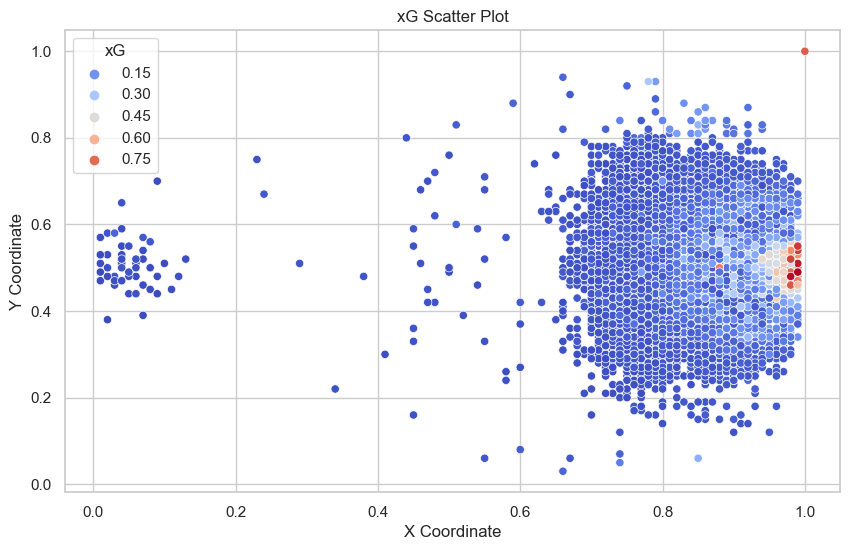

In [374]:
# Scatter plot of xG values w.r.t to X and Y coordinates
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test['X_coord'], y=X_test['Y_coord'], hue=hyper_preds_xgb, palette='coolwarm')
plt.title("xG Scatter Plot")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend(title="xG")
plt.show()


In [376]:
print("xG Boost Model Evaluation metrics")

accuracy = accuracy_score(y_test, y_preds)
print(f"Accuracy: {accuracy:.2f}")
precision = precision_score(y_test, y_preds)
print(f"Precision: {precision:.2f}")
recall = recall_score(y_test, y_preds)
print(f"Recall: {recall:.2f}")
#print(y_test,y_pred)
roc_auc = roc_auc_score(y_test, y_preds)
print(f"ROC AUC: {roc_auc:.2f}")
mse = mean_squared_error(y_test, y_preds)
print(f"Mean Squared Error: {mse:.2f}")
f1 = f1_score(y_test, y_preds)
print("F1 Score:", f1)
log_loss_val = log_loss(y_test, y_pred_proba)
print("Log Loss value :", log_loss_val)
conf_matrix = confusion_matrix(y_test, y_preds)
print("Confusion Matrix:\n", conf_matrix)
# r2 = r2_score(y_test, y_pred)
# print("R-squared:", r2)
brier_score = brier_score_loss(y_test, y_pred_proba)
print("Brier Score :", brier_score)

report_xgb1 = classification_report(y_test, y_preds)
print(report_xgb1)



print("xG Boost HYPER PARAMETER MODEL EVALUATION METRICS")

accuracy = accuracy_score(y_test, hyper_xgb_preds)
print(f"Accuracy: {accuracy:.2f}")
precision = precision_score(y_test, hyper_xgb_preds)
print(f"Precision: {precision:.2f}")
recall = recall_score(y_test, hyper_xgb_preds)
print(f"Recall: {recall:.2f}")
#print(y_test,y_pred)
roc_auc = roc_auc_score(y_test, hyper_xgb_preds)
print(f"ROC AUC: {roc_auc:.2f}")
mse = mean_squared_error(y_test, hyper_xgb_preds)
print(f"Mean Squared Error: {mse:.2f}")
f1 = f1_score(y_test, hyper_xgb_preds)
print("F1 Score:", f1)
log_loss_val = log_loss(y_test, hyper_preds_xgb)
print("Log Loss value :", log_loss_val)
conf_matrix = confusion_matrix(y_test, hyper_xgb_preds)
print("Confusion Matrix:\n", conf_matrix)
# r2 = r2_score(y_test, y_pred)
# print("R-squared:", r2)
brier_score = brier_score_loss(y_test, hyper_preds_xgb)
print("Brier Score :", brier_score)	

report_xgb2 = classification_report(y_test, hyper_xgb_preds)
print(report_xgb2)

xG Boost Model Evaluation metrics
Accuracy: 0.90
Precision: 0.63
Recall: 0.19
ROC AUC: 0.59
Mean Squared Error: 0.10
F1 Score: 0.28605061801059445
Log Loss value : 0.2791689424218054
Confusion Matrix:
 [[10907   144]
 [ 1069   243]]
Brier Score : 0.07940252597343021
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     11051
           1       0.63      0.19      0.29      1312

    accuracy                           0.90     12363
   macro avg       0.77      0.59      0.62     12363
weighted avg       0.88      0.90      0.88     12363

xG Boost HYPER PARAMETER MODEL EVALUATION METRICS
Accuracy: 0.90
Precision: 0.70
Recall: 0.16
ROC AUC: 0.58
Mean Squared Error: 0.10
F1 Score: 0.26038437693738375
Log Loss value : 0.26952200967058554
Confusion Matrix:
 [[10960    91]
 [ 1102   210]]
Brier Score : 0.07743217462645871
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     11051
           1 

In [383]:
#xG Function xG BOOST

def calculate_xG(position_x, position_y,Y_coord_angle,is_penalty, is_header,is_home,is_OpenPlay,is_DirectFreekick,is_FromCorner,is_SetPiece,player_name,Last_Action,Team_rating,Opponent_rating):
    new_data = pd.DataFrame({
        'X_coord': [position_x],
        'Y_coord': [position_y],
        'Y_coord_angle' : [Y_coord_angle],
        'is_Penalty': [is_penalty],
        'is_head': [is_header],
        'is_home':[is_home],
        'is_OpenPlay' :[is_OpenPlay],
        'is_DirectFreekick' :[is_DirectFreekick],
        'is_FromCorner' :[is_FromCorner],
        'is_SetPiece' :[is_SetPiece],
        'overall' : [data.loc[data['Player name'] == player_name, 'overall'].values[0]],
        'value_eur' : [data.loc[data['Player name'] == player_name, 'value_eur'].values[0]],
        'shooting' : [data.loc[data['Player name'] == player_name, 'shooting'].values[0]],
        'Last_Action' : [Last_Action] ,
        'Team_rating' : [Team_rating],
        'Opponent_rating' : [Opponent_rating]
    })
    overall = new_data['overall']
    value_eur = new_data['value_eur']
    shooting = new_data['shooting']
    #Y_coord_angle = (1 - abs(position_y - 0.50) * 2)
    scaled_features = scaler.transform([[position_x, position_y, Y_coord_angle,is_penalty, is_header,is_home,is_OpenPlay,is_DirectFreekick,is_FromCorner,is_SetPiece,overall,value_eur,shooting,Last_Action,Team_rating,Opponent_rating]])
    #xG_probability = xgb_model.predict_proba(new_data)[0, 1]  # Probability of scoring a goal
    #xG_probability = xgb_s.predict_proba(new_data)[0, 1]
    #xg_prob = xgb_s.predict_proba(scaled_features)[:, 1]
    xg_prob = final_xgb_model.predict_proba(scaled_features)[:, 1]
    #new_data['New xG']=xG_probability
    new_data['New xG']=xg_prob
    #print("xG probability: pos x",position_x,", pos y",position_y,", is_pen",is_penalty,", is_head",is_header,", is_home",is_home,":",xG_probability)
    #print("xG probability: pos x",position_x,", pos y",position_y,", is_pen",is_penalty,", is_head",is_header,", is_home",is_home,":",xg_prob[0])
    return xg_prob[0],new_data
    #return xG_probability, new_data


position_x = 0.88  # Replace with the actual X-coordinate
position_y = 0.50  # Replace with the actual Y-coordinate
Y_coord_angle = 1.00
is_penalty = 1   # Replace with 1 if it's a penalty, or 0 if it's not
is_header = 0    # Replace with 1 if it's a header, or 0 if it's not
is_home = 1
is_OpenPlay = 1
is_DirectFreekick = 0
is_FromCorner = 0
is_SetPiece = 0
player_name = "lionel messi"

new_xG_data = pd.DataFrame(columns=['X_coord','Y_coord','Y_coord_angle','is_Penalty','is_head','is_home',
                                   'is_OpenPlay','is_DirectFreekick','is_FromCorner','is_SetPiece',
                                   'overall','value_eur','shooting','Last_Action','Team_rating','Opponent_rating'])


#'overall','value_eur','shooting'

parameter_sets = [
    (0.88, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.90, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.94, 0.48,(1-abs(0.48-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.90, 0.50,(1-abs(0.50-0.50)*2),0, 0, 0,1,0,0,0,player_name,10,85,75),
    (0.95, 0.50,(1-abs(0.50-0.50)*2),0, 1, 1,1,0,0,0,player_name,10,85,75),
    (0.87, 0.40,(1-abs(0.40-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.80, 0.45,(1-abs(0.45-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.50, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.40, 0.60,(1-abs(0.60-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.30, 0.70,(1-abs(0.70-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.20, 0.80,(1-abs(0.80-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.10, 0.10,(1-abs(0.10-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75)
]



# def player_attributes(player_name):
#     for p in parameter_sets:
#         p.append(data.loc[data['Player name'] == player_name, 'overall'].values[0])
#         p.append(data.loc[data['Player name'] == player_name, 'value_eur'].values[0])
#         p.append(data.loc[data['Player name'] == player_name, 'shooting'].values[0])
    

# new_xG_data = []

for params in parameter_sets:
    xG_probability, new_data = calculate_xG(*params)
    new_xG_data=new_xG_data.append(new_data)

print(new_xG_data)

messi_xG_data = new_xG_data



   X_coord  Y_coord  Y_coord_angle is_Penalty is_head is_home is_OpenPlay  \
0     0.88     0.50           1.00          0       0       1           1   
0     0.90     0.50           1.00          0       0       1           1   
0     0.94     0.48           0.96          0       0       1           1   
0     0.90     0.50           1.00          0       0       0           1   
0     0.95     0.50           1.00          0       1       1           1   
0     0.87     0.40           0.80          0       0       1           1   
0     0.80     0.45           0.90          0       0       1           1   
0     0.50     0.50           1.00          0       0       1           1   
0     0.40     0.60           0.80          0       0       1           1   
0     0.30     0.70           0.60          0       0       1           1   
0     0.20     0.80           0.40          0       0       1           1   
0     0.10     0.10           0.20          0       0       1           1   

In [379]:
#xG values for a highly rated defender with low attacking qualities such as "Vincent Kompany" from Manchester City 
 


player_name = "vincent kompany"

new_xG_data2 = pd.DataFrame(columns=['X_coord','Y_coord','Y_coord_angle','is_Penalty','is_head','is_home',
                                   'is_OpenPlay','is_DirectFreekick','is_FromCorner','is_SetPiece',
                                   'overall','value_eur','shooting','Last_Action','Team_rating','Opponent_rating'])


parameter_sets = [
    (0.88, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.90, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.94, 0.48,(1-abs(0.48-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.90, 0.50,(1-abs(0.50-0.50)*2),0, 0, 0,1,0,0,0,player_name,10,85,75),
    (0.95, 0.50,(1-abs(0.50-0.50)*2),0, 1, 1,1,0,0,0,player_name,10,85,75),
    (0.87, 0.40,(1-abs(0.40-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.80, 0.45,(1-abs(0.45-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.50, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.40, 0.60,(1-abs(0.60-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.30, 0.70,(1-abs(0.70-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.20, 0.80,(1-abs(0.80-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.10, 0.10,(1-abs(0.10-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75)
]



for params in parameter_sets:
    xG_probability, new_data = calculate_xG(*params)
    new_xG_data2=new_xG_data2.append(new_data)

print(new_xG_data2)

kompany_xG_data = new_xG_data2



   X_coord  Y_coord  Y_coord_angle is_Penalty is_head is_home is_OpenPlay  \
0     0.88     0.50           1.00          0       0       1           1   
0     0.90     0.50           1.00          0       0       1           1   
0     0.94     0.48           0.96          0       0       1           1   
0     0.90     0.50           1.00          0       0       0           1   
0     0.95     0.50           1.00          0       1       1           1   
0     0.87     0.40           0.80          0       0       1           1   
0     0.80     0.45           0.90          0       0       1           1   
0     0.50     0.50           1.00          0       0       1           1   
0     0.40     0.60           0.80          0       0       1           1   
0     0.30     0.70           0.60          0       0       1           1   
0     0.20     0.80           0.40          0       0       1           1   
0     0.10     0.10           0.20          0       0       1           1   

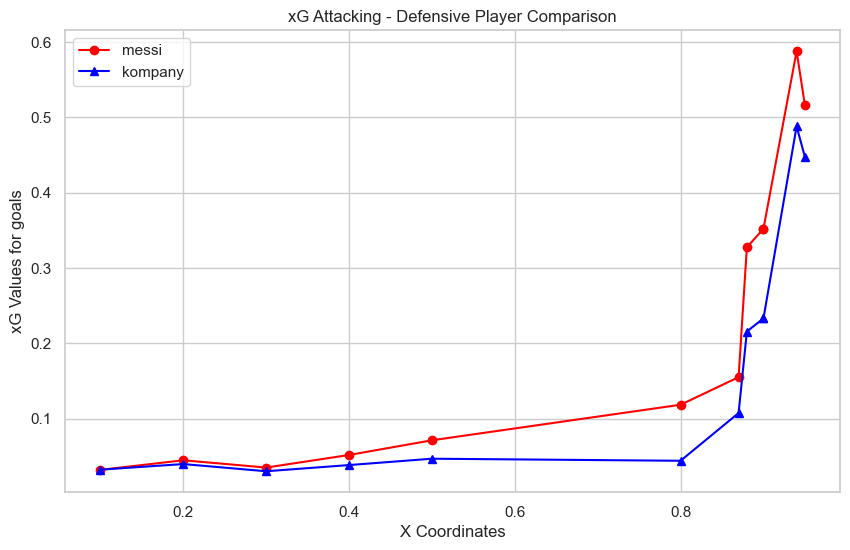

In [384]:
# Comparison of xG values of a highly rated offensive player Messi to defensive player Kompany

# Creating line plots
messi_xG_data = messi_xG_data.sort_values(by=["X_coord", "Y_coord"])
kompany_xG_data = kompany_xG_data.sort_values(by=["X_coord", "Y_coord"])
plt.figure(figsize=(10, 6))
plt.plot(messi_xG_data['X_coord'], messi_xG_data['New xG'], label='messi', color='red', marker='o')
plt.plot(kompany_xG_data['X_coord'], kompany_xG_data['New xG'], label='kompany', color='blue', marker='^')
# plt.plot(goal_df['X_coord'], goal_df['xG_calc_xgb'], label='xg_xgb', color='green', marker='s')

# Customizing the plot
plt.title('xG Attacking - Defensive Player Comparison')
plt.xlabel('X Coordinates')
plt.ylabel('xG Values for goals')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [385]:
#XG values when Messi takes a shot against low rated teams such as Sunderland


player_name = "lionel messi"

new_xG_data3 = pd.DataFrame(columns=['X_coord','Y_coord','Y_coord_angle','is_Penalty','is_head','is_home',
                                   'is_OpenPlay','is_DirectFreekick','is_FromCorner','is_SetPiece',
                                   'overall','value_eur','shooting','Last_Action','Team_rating','Opponent_rating'])


parameter_sets = [
    (0.88, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,68),
    (0.90, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,68),
    (0.94, 0.48,(1-abs(0.48-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,68),
    (0.90, 0.50,(1-abs(0.50-0.50)*2),0, 0, 0,1,0,0,0,player_name,10,85,68),
    (0.95, 0.50,(1-abs(0.50-0.50)*2),0, 1, 1,1,0,0,0,player_name,10,85,68),
    (0.87, 0.40,(1-abs(0.40-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,68),
    (0.80, 0.45,(1-abs(0.45-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,68),
    (0.50, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,68),
    (0.40, 0.60,(1-abs(0.60-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,68),
    (0.30, 0.70,(1-abs(0.70-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,68),
    (0.20, 0.80,(1-abs(0.80-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,68),
    (0.10, 0.10,(1-abs(0.10-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,68)
]



for params in parameter_sets:
    xG_probability, new_data = calculate_xG(*params)
    new_xG_data3=new_xG_data3.append(new_data)

print(new_xG_data3)

sunderland_xG_data = new_xG_data3



   X_coord  Y_coord  Y_coord_angle is_Penalty is_head is_home is_OpenPlay  \
0     0.88     0.50           1.00          0       0       1           1   
0     0.90     0.50           1.00          0       0       1           1   
0     0.94     0.48           0.96          0       0       1           1   
0     0.90     0.50           1.00          0       0       0           1   
0     0.95     0.50           1.00          0       1       1           1   
0     0.87     0.40           0.80          0       0       1           1   
0     0.80     0.45           0.90          0       0       1           1   
0     0.50     0.50           1.00          0       0       1           1   
0     0.40     0.60           0.80          0       0       1           1   
0     0.30     0.70           0.60          0       0       1           1   
0     0.20     0.80           0.40          0       0       1           1   
0     0.10     0.10           0.20          0       0       1           1   

In [386]:
#XG values when Messi takes a shot against high rated teams such as Real Madrid

player_name = "lionel messi"

new_xG_data4 = pd.DataFrame(columns=['X_coord','Y_coord','Y_coord_angle','is_Penalty','is_head','is_home',
                                   'is_OpenPlay','is_DirectFreekick','is_FromCorner','is_SetPiece',
                                   'overall','value_eur','shooting','Last_Action','Team_rating','Opponent_rating'])


parameter_sets = [
    (0.88, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,85),
    (0.90, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,85),
    (0.94, 0.48,(1-abs(0.48-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,85),
    (0.90, 0.50,(1-abs(0.50-0.50)*2),0, 0, 0,1,0,0,0,player_name,10,85,85),
    (0.95, 0.50,(1-abs(0.50-0.50)*2),0, 1, 1,1,0,0,0,player_name,10,85,85),
    (0.87, 0.40,(1-abs(0.40-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,85),
    (0.80, 0.45,(1-abs(0.45-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,85),
    (0.50, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,85),
    (0.40, 0.60,(1-abs(0.60-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,85),
    (0.30, 0.70,(1-abs(0.70-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,85),
    (0.20, 0.80,(1-abs(0.80-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,85),
    (0.10, 0.10,(1-abs(0.10-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,85)
]



for params in parameter_sets:
    xG_probability, new_data = calculate_xG(*params)
    new_xG_data4=new_xG_data4.append(new_data)

print(new_xG_data4)

realmadrid_xG_data = new_xG_data4



   X_coord  Y_coord  Y_coord_angle is_Penalty is_head is_home is_OpenPlay  \
0     0.88     0.50           1.00          0       0       1           1   
0     0.90     0.50           1.00          0       0       1           1   
0     0.94     0.48           0.96          0       0       1           1   
0     0.90     0.50           1.00          0       0       0           1   
0     0.95     0.50           1.00          0       1       1           1   
0     0.87     0.40           0.80          0       0       1           1   
0     0.80     0.45           0.90          0       0       1           1   
0     0.50     0.50           1.00          0       0       1           1   
0     0.40     0.60           0.80          0       0       1           1   
0     0.30     0.70           0.60          0       0       1           1   
0     0.20     0.80           0.40          0       0       1           1   
0     0.10     0.10           0.20          0       0       1           1   

Comparison of xG values of a highly rated offensive player taking shots against a low rated defensive team and high rated team


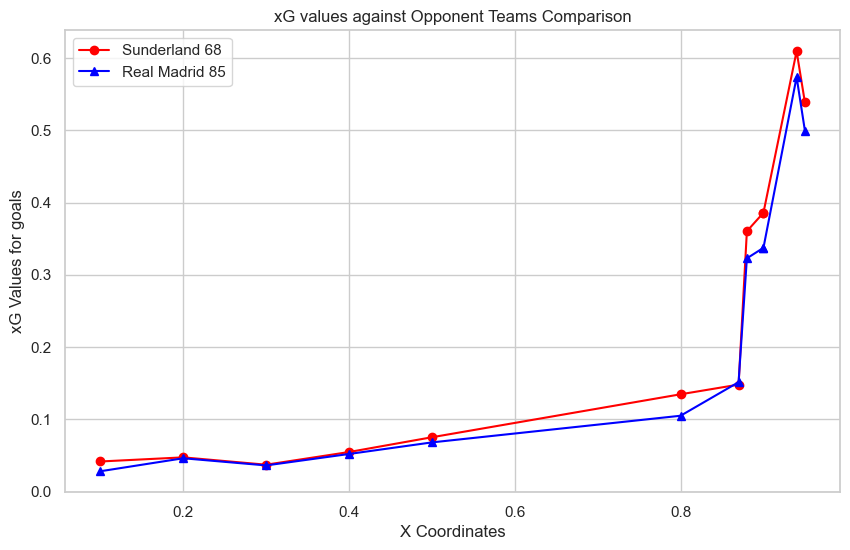

As expected, the shots against low rated teams has higher xG values compared to shots against stronger teams


In [387]:
# Comparison of xG values of a highly rated offensive player Messi taking shots against a low rated defensive team in
# Sunderland and highly rated team like Real Madrid

# Creating line plots
sunderland_xG_data = sunderland_xG_data.sort_values(by=["X_coord", "Y_coord"])
realmadrid_xG_data = realmadrid_xG_data.sort_values(by=["X_coord", "Y_coord"])
plt.figure(figsize=(10, 6))
plt.plot(sunderland_xG_data['X_coord'], sunderland_xG_data['New xG'], label='Sunderland 68', color='red', marker='o')
plt.plot(realmadrid_xG_data['X_coord'], realmadrid_xG_data['New xG'], label='Real Madrid 85', color='blue', marker='^')
# plt.plot(goal_df['X_coord'], goal_df['xG_calc_xgb'], label='xg_xgb', color='green', marker='s')

# Customizing the plot
plt.title('xG values against Opponent Teams Comparison')
plt.xlabel('X Coordinates')
plt.ylabel('xG Values for goals')
plt.legend()
plt.grid(True)

print("Comparison of xG values of a highly rated offensive player taking shots against a low rated defensive team and high rated team")
# Show the plot
plt.show()

print("As expected, the shots against low rated teams has higher xG values compared to shots against stronger teams")

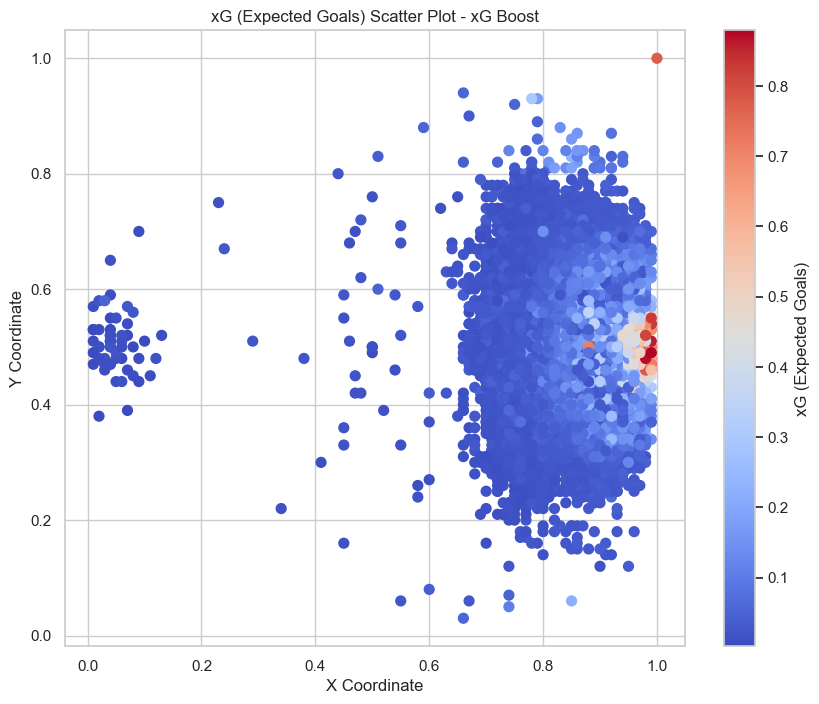

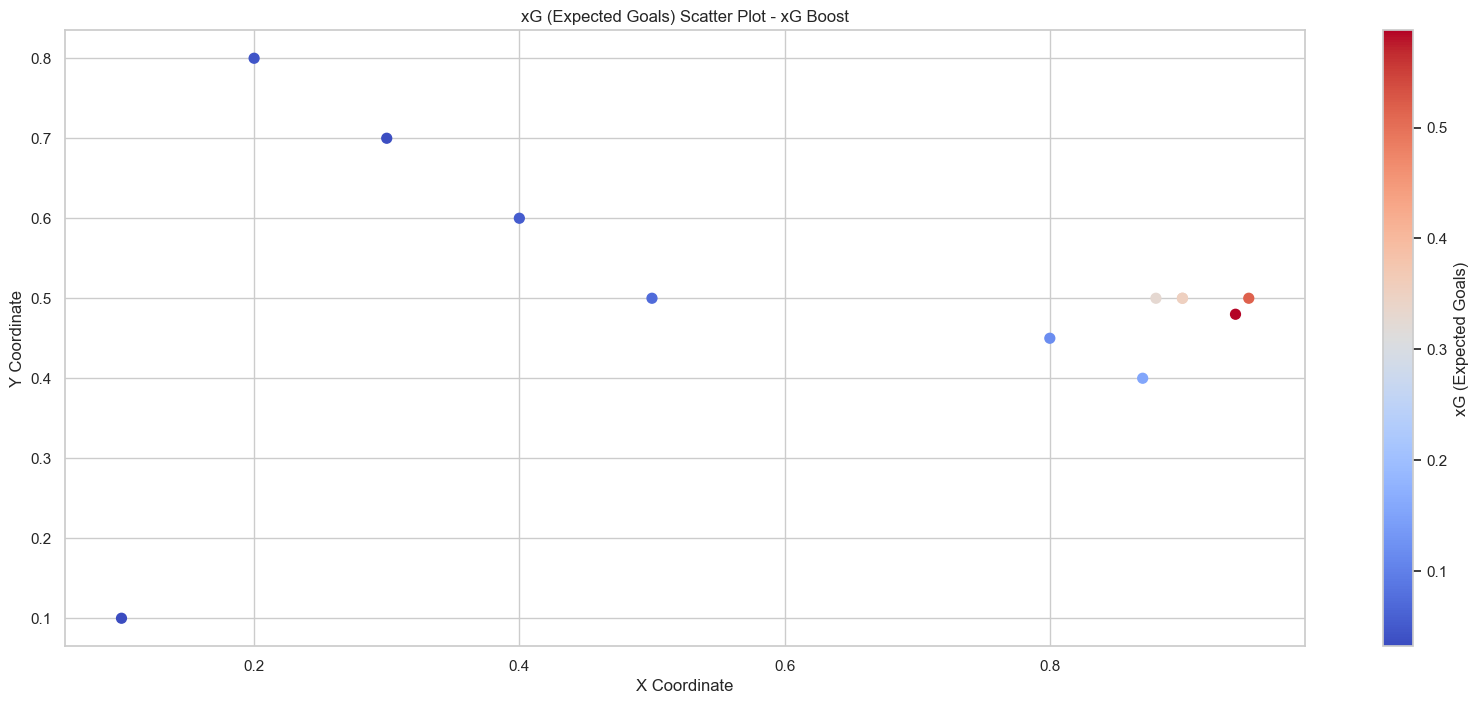

In [388]:
plt.figure(figsize=(10, 8))
# plt.scatter(data['X_coord'], data['Y_coord'], c=data['xG_calc'], cmap='coolwarm', s=50)
plt.scatter(X_test['X_coord'], X_test['Y_coord'], c=X_test['xG_calc'], cmap='coolwarm', s=50)
plt.colorbar(label='xG (Expected Goals)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('xG (Expected Goals) Scatter Plot - xG Boost')
plt.show()


plt.scatter(new_xG_data['X_coord'], new_xG_data['Y_coord'], c=new_xG_data['New xG'], cmap='coolwarm', s=50)
plt.colorbar(label='xG (Expected Goals)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('xG (Expected Goals) Scatter Plot - xG Boost')
plt.show()


In [389]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = testtrainsplit()
# Applying oversampling
X_train_resampled,y_train_resampled = sampling(X_train,y_train)
# Standardizing the features using scaler
scaler,X_train_scaled,X_train_scaled_resampled,X_test_scaled,X_data_scaled = scaling(X_train,X_train_resampled,X_test)

Test Train Split
Sampling
Feature Scaling


In [390]:
#LOGISTIC REGRESSION 
logreg_model = LogisticRegression(random_state=42)
logreg_model_s = LogisticRegression(random_state=42)

logreg_model.fit(X_train, y_train)
#logreg_model_s.fit(X_train_resampled, y_train_resampled)
logreg_model_s.fit(X_train_scaled, y_train)
#logreg_model_s.fit(X_train_scaled_resampled, y_train_resampled)


#Predicting xG values for both training and testing sets
xG_train = logreg_model.predict_proba(X_train)[:, 1]
# xG_test = logreg_model.predict_proba(X_test)[:, 1]
# y_pred = logreg_model.predict(X_test)



#SCALING
# xG_train = logreg_model_s.predict_proba(X_train_scaled)[:, 1]
# xG_test = logreg_model_s.predict_proba(X_test_scaled)[:, 1]
# y_pred = logreg_model_s.predict(X_test_scaled)
#y_preds = logreg_model_s.predict(X_test_scaled)

#SCALING RESAMPLED
# xG_train = logreg_model_s.predict_proba(X_train_resampled)[:, 1]
# xG_test = logreg_model_s.predict_proba(X_test)[:, 1]
#y_preds = logreg_model_s.predict(X_test)
y_preds = logreg_model_s.predict(X_test_scaled)
y_pred_proba = logreg_model_s.predict_proba(X_test_scaled)[:, 1]

# Combinining xG values for the entire dataset
#xG_all = logreg_model.predict_proba(features)[:, 1]
#xG_all = logreg_model_s.predict_proba(features)[:, 1]
xG_all = logreg_model_s.predict_proba(X_data_scaled)[:, 1]  # Directly use predict_proba on the scaled features
#data['xG_calc_LR'] = xG_all

print("Logistic Regression")

Logistic Regression


In [391]:
# Hyperparameter tuning using GridSearchCV
# param_grid_LR = {
#     'C': [0.01, 0.1, 1, 10],
#     'penalty': ['l1', 'l2']
# }

param_grid_LR = {
    'C': [10],
    'penalty': ['l2']
}


grid_search_LR = GridSearchCV(logreg_model_s, param_grid_LR, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search_LR.fit(X_train_scaled, y_train)

best_params_LR = grid_search_LR.best_params_
print("Best parameters:", best_params_LR)

# Training Logistic Regression model with the best parameters
# final_logreg_model = LogisticRegression(**best_params, random_state=42)
final_logreg_model = LogisticRegression(**best_params_LR,solver='lbfgs', max_iter=1000,random_state=42)
final_logreg_model.fit(X_train_scaled, y_train)

print("Trained on best parameters")


# Predicting xG values of scaled test set
hyper_preds_logreg = final_logreg_model.predict_proba(X_test_scaled)[:, 1]
hyper_logreg_preds = final_logreg_model.predict(X_test_scaled)

X_test['xG_calc_LR'] = hyper_preds_logreg




Best parameters: {'C': 10, 'penalty': 'l2'}
Trained on best parameters


In [392]:
print("Model Evaluation - LR")
accuracy = accuracy_score(y_test, y_preds)
print(f"Accuracy: {accuracy:.2f}")
precision = precision_score(y_test, y_preds)
print(f"Precision: {precision:.2f}")
recall = recall_score(y_test, y_preds)
print(f"Recall: {recall:.2f}")
#print(y_test,y_preds)
roc_auc = roc_auc_score(y_test, y_preds)
print(f"ROC AUC: {roc_auc:.2f}")
mse = mean_squared_error(y_test, y_preds)
print(f"Mean Squared Error: {mse:.2f}")
f1 = f1_score(y_test, y_preds)
print("F1 Score:", f1)
log_loss_val = log_loss(y_test, y_pred_proba)
print("Log Loss value :", log_loss_val)
conf_matrix = confusion_matrix(y_test, y_preds)
print("Confusion Matrix:\n", conf_matrix)
brier_score = brier_score_loss(y_test, y_preds)
print("Brier Score :", brier_score)
#r2 = r2_score(y_test, y_preds)
#print("R-squared:", r2)



print("HYPER PARAMETER TUNING Model Evaluation - LOGISTIC REGRESSION")
accuracy = accuracy_score(y_test, hyper_logreg_preds)
print(f"Accuracy: {accuracy:.2f}")
precision = precision_score(y_test, hyper_logreg_preds)
print(f"Precision: {precision:.2f}")
recall = recall_score(y_test, hyper_logreg_preds)
print(f"Recall: {recall:.2f}")
#print(y_test,hyper_logreg_preds)
roc_auc = roc_auc_score(y_test, hyper_logreg_preds)
print(f"ROC AUC: {roc_auc:.2f}")
mse = mean_squared_error(y_test, hyper_logreg_preds)
print(f"Mean Squared Error: {mse:.2f}")
f1 = f1_score(y_test, hyper_logreg_preds)
print("F1 Score:", f1)
log_loss_val = log_loss(y_test, hyper_preds_logreg)
print("Log Loss value :", log_loss_val)
conf_matrix = confusion_matrix(y_test, hyper_logreg_preds)
print("Confusion Matrix:\n", conf_matrix)
brier_score = brier_score_loss(y_test, hyper_logreg_preds)
print("Brier Score :", brier_score)
#r2 = r2_score(y_test, hyper_logreg_preds)
#print("R-squared:", r2)



Model Evaluation - LR
Accuracy: 0.90
Precision: 0.73
Recall: 0.10
ROC AUC: 0.55
Mean Squared Error: 0.10
F1 Score: 0.17204301075268819
Log Loss value : 0.2795467262009903
Confusion Matrix:
 [[11003    48]
 [ 1184   128]]
Brier Score : 0.09965218798026369
HYPER PARAMETER TUNING Model Evaluation - LOGISTIC REGRESSION
Accuracy: 0.90
Precision: 0.73
Recall: 0.11
ROC AUC: 0.55
Mean Squared Error: 0.10
F1 Score: 0.19205298013245034
Log Loss value : 0.27937083684932984
Confusion Matrix:
 [[10998    53]
 [ 1167   145]]
Brier Score : 0.09868154978565073


In [393]:
#LOGISTIC REGRESSION xG Function

def calculate_xG_LR(position_x, position_y,Y_coord_angle,is_penalty, is_header,is_home,is_OpenPlay,is_DirectFreekick,is_FromCorner,is_SetPiece,player_name,Last_Action,Team_rating,Opponent_rating):
    new_data_LR = pd.DataFrame({
        'X_coord': [position_x],
        'Y_coord': [position_y],
        'Y_coord_angle' : [Y_coord_angle],
        'is_Penalty': [is_penalty],
        'is_head': [is_header],
        'is_home':[is_home],
        'is_OpenPlay' :[is_OpenPlay],
        'is_DirectFreekick' :[is_DirectFreekick],
        'is_FromCorner' :[is_FromCorner],
        'is_SetPiece' :[is_SetPiece],
        'overall' : [data.loc[data['Player name'] == player_name, 'overall'].values[0]],
        'value_eur' : [data.loc[data['Player name'] == player_name, 'value_eur'].values[0]],
        'shooting' : [data.loc[data['Player name'] == player_name, 'shooting'].values[0]],
        'Last_Action' : [Last_Action] ,
        'Team_rating' : [Team_rating],
        'Opponent_rating' : [Opponent_rating]
    })
    overall = new_data['overall']
    value_eur = new_data['value_eur']
    shooting = new_data['shooting']
    #Y_coord_angle = (1 - abs(position_y - 0.50) * 2)
    scaled_features = scaler.transform([[position_x, position_y, Y_coord_angle,is_penalty, is_header,is_home,is_OpenPlay,is_DirectFreekick,is_FromCorner,is_SetPiece,overall,value_eur,shooting,Last_Action,Team_rating,Opponent_rating]])
    #xG_probability = logreg_model.predict_proba(new_data_LR)[0, 1]  # Probability of scoring a goal
    #xG_probability = logreg_model_s.predict_proba(new_data_LR)[0, 1]
    #xg_prob = logreg_model_s.predict_proba(scaled_features)[:, 1]
    xg_prob = final_logreg_model.predict_proba(scaled_features)[:, 1]
    #new_data_LR['New xG']=xG_probability
    new_data_LR['New xG']=xg_prob
    #print("xG probability: pos x",position_x,", pos y",position_y,", is_pen",is_penalty,", is_head",is_header,", is_home",is_home,":",xG_probability)
    #print("xG probability: pos x",position_x,", pos y",position_y,", is_pen",is_penalty,", is_head",is_header,", is_home",is_home,":",xg_prob[0])
    return xg_prob[0],new_data_LR
    #return xG_probability, new_data_LR



new_xG_data_LR  = pd.DataFrame(columns=['X_coord','Y_coord','Y_coord_angle','is_Penalty','is_head','is_home',
                                   'is_OpenPlay','is_DirectFreekick','is_FromCorner','is_SetPiece',
                                   'overall','value_eur','shooting','Last_Action','Team_rating','Opponent_rating'])

player_name = "lionel messi"

#'overall','value_eur','shooting'

parameter_sets = [
    (0.88, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.90, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.94, 0.48,(1-abs(0.48-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.90, 0.50,(1-abs(0.50-0.50)*2),0, 0, 0,1,0,0,0,player_name,10,85,75),
    (0.95, 0.50,(1-abs(0.50-0.50)*2),0, 1, 1,1,0,0,0,player_name,10,85,75),
    (0.87, 0.40,(1-abs(0.40-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.80, 0.45,(1-abs(0.45-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.50, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.40, 0.60,(1-abs(0.60-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.30, 0.70,(1-abs(0.70-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.20, 0.80,(1-abs(0.80-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.10, 0.10,(1-abs(0.10-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75)
]





for params in parameter_sets:
    xG_probability, new_data_LR = calculate_xG_LR(*params)
    new_xG_data_LR=new_xG_data_LR.append(new_data_LR)

print(new_xG_data_LR)



   X_coord  Y_coord  Y_coord_angle is_Penalty is_head is_home is_OpenPlay  \
0     0.88     0.50           1.00          0       0       1           1   
0     0.90     0.50           1.00          0       0       1           1   
0     0.94     0.48           0.96          0       0       1           1   
0     0.90     0.50           1.00          0       0       0           1   
0     0.95     0.50           1.00          0       1       1           1   
0     0.87     0.40           0.80          0       0       1           1   
0     0.80     0.45           0.90          0       0       1           1   
0     0.50     0.50           1.00          0       0       1           1   
0     0.40     0.60           0.80          0       0       1           1   
0     0.30     0.70           0.60          0       0       1           1   
0     0.20     0.80           0.40          0       0       1           1   
0     0.10     0.10           0.20          0       0       1           1   

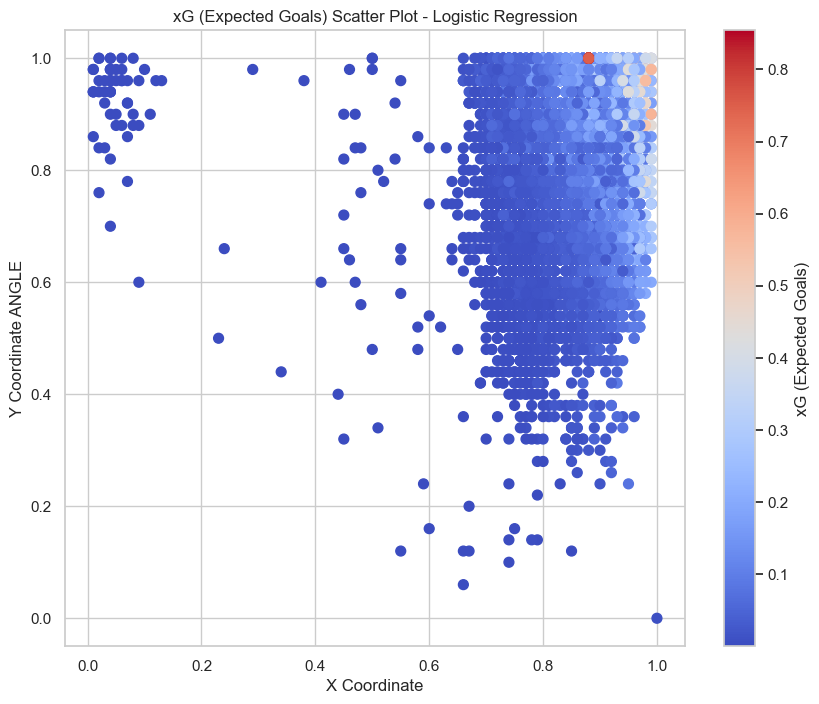

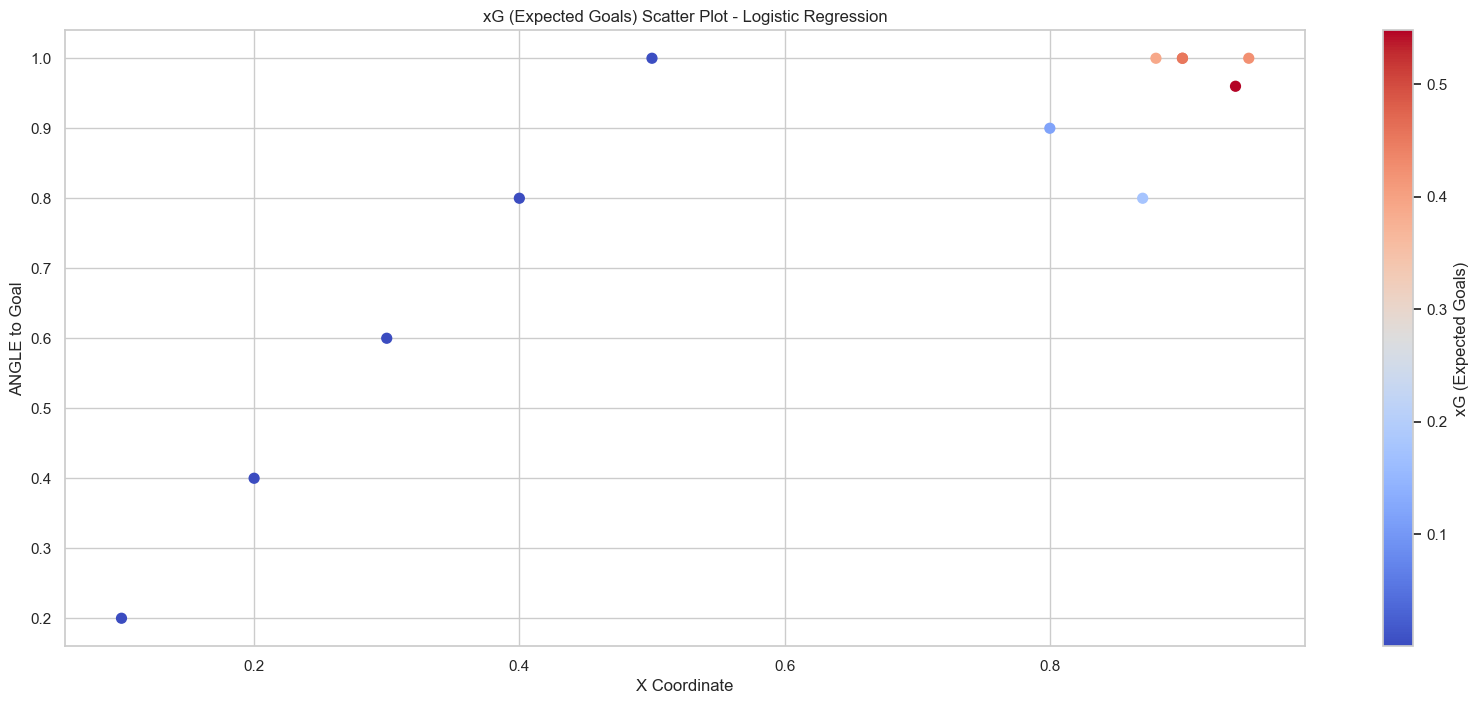

In [396]:
plt.figure(figsize=(10, 8))
# plt.scatter(data['X_coord'], data['Y_coord_angle'], c=data['xG_calc_LR'], cmap='coolwarm', s=50)
plt.scatter(X_test['X_coord'], X_test['Y_coord_angle'], c=X_test['xG_calc_LR'], cmap='coolwarm', s=50)
plt.colorbar(label='xG (Expected Goals)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate ANGLE')
plt.title('xG (Expected Goals) Scatter Plot - Logistic Regression')
plt.show()


plt.scatter(new_xG_data['X_coord'], new_xG_data['Y_coord_angle'], c=new_xG_data_LR['New xG'], cmap='coolwarm', s=50)
plt.colorbar(label='xG (Expected Goals)')
plt.xlabel('X Coordinate')
plt.ylabel('ANGLE to Goal')
plt.title('xG (Expected Goals) Scatter Plot - Logistic Regression')
plt.show()


In [54]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = testtrainsplit()
# Applying oversampling
X_train_resampled,y_train_resampled = sampling(X_train,y_train)
# Standardizing the features using scaler
scaler,X_train_scaled,X_train_scaled_resampled,X_test_scaled,X_data_scaled = scaling(X_train,X_train_resampled,X_test)

Test Train Split
Sampling
Feature Scaling


In [55]:
#RANDOM FORESTS REGRESSION 

random_forest_model = RandomForestRegressor(n_estimators=100,random_state=42)
random_forest_model_s = RandomForestRegressor(n_estimators=100,random_state=42)


#Traning
random_forest_model.fit(X_train, y_train)
#random_forest_model_s.fit(X_train_resampled, y_train_resampled)
random_forest_model_s.fit(X_train_scaled, y_train)
#random_forest_model_s.fit(X_train_scaled_resampled, y_train_resampled)


#Predicting xG values for both training and testing sets
#xG_train = random_forest_model.predict_proba(X_train)[:, 1]
#xG_test = random_forest_model.predict_proba(X_test)[:, 1]
y_pred = random_forest_model.predict(X_test)


#SCALING
# xG_train = random_forest_model_s.predict_proba(X_train_scaled)[:, 1]
# xG_test = random_forest_model_s.predict_proba(X_test_scaled)[:, 1]
# y_pred = random_forest_model_s.predict(X_test_scaled)
#y_preds = random_forest_model_s.predict(X_test_scaled)


#SCALING RESAMPLED
# xG_train = random_forest_model_s.predict_proba(X_train_resampled)[:, 1]
# xG_test = random_forest_model_s.predict_proba(X_test)[:, 1]
y_preds = random_forest_model_s.predict(X_test_scaled)
#y_preds = random_forest_model_s.predict_proba(X_test_scaled)[:, 1]

# Combinining xG values for the entire dataset
# xG_all = random_forest_model_s.predict_proba(features)[:, 1]
#xG_all = random_forest_model_s.predict_proba(features)[:, 1]
#xG_all = random_forest_model.predict(features)
#xG_all = random_forest_model_s.predict(X_data_scaled)  # Directly use predict_proba on the scaled features
#xG_all = random_forest_model_s.predict(X_data_scaled)
#xG_all = random_forest_model_s.predict(X_test_scaled)
xG_all = y_preds
#data['xG_calc_RFR'] = xG_all
# X_test['xG_calc_RFR'] = xG_all

print("Random forests Regression")

Random forests Regression


In [57]:
# Definining hyperparameters 
# param_grid_random_forest= {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }


param_grid_random_forest= {
    'n_estimators': [300],
    'max_depth': [None, 10],
    'min_samples_split': [2],
    'min_samples_leaf': [2]
}


# Hyperparameter tuning using GridSearchCV
grid_search_random_forest = GridSearchCV(random_forest_model_s, param_grid_random_forest, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search_random_forest.fit(X_train_scaled, y_train)

# Getting the best Random Forests model
best_random_forest_model = grid_search_random_forest.best_estimator_
#hyper_preds_random_forest = best_random_forest_model.predict_proba(X_test_scaled)[:, 1]
hyper_random_forest_preds = best_random_forest_model.predict(X_test_scaled)


# Printing best parameters
print("Best Parameters:", grid_search_random_forest.best_params_)
print("Best Score:", grid_search_random_forest.best_score_)
#X_test['xG_calc_random_forest'] = hyper_preds_random_forest
X_test['xG_calc_RFR'] = hyper_random_forest_preds


Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best Score: 0.7948304433813135


In [58]:
print("Model Evaluation - RANDOM FORESTS REGRESSION")

y_pred_binary = np.where(y_pred > 0.5, 1, 0)

accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy:.2f}")
precision = precision_score(y_test, y_pred_binary)
print(f"Precision: {precision:.2f}")
recall = recall_score(y_test, y_pred_binary)
print(f"Recall: {recall:.2f}")
#print(y_test,y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC: {roc_auc:.2f}")
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
f1 = f1_score(y_test, y_pred_binary)
print("F1 Score:", f1)
log_loss_val = log_loss(y_test, y_pred)
print("Log Loss value :", log_loss_val)
conf_matrix = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:\n", conf_matrix)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)
brier_score = brier_score_loss(y_test, y_preds)
print("Brier Score :", brier_score)




print("RANDOM FORESTS REGRESSION Hyper Parameter Tuning Model Evaluation")

hyper_random_forest_preds = np.where(hyper_random_forest_preds > 0.5, 1, 0)

accuracy = accuracy_score(y_test, hyper_random_forest_preds)
print(f"Accuracy: {accuracy:.2f}")
precision = precision_score(y_test, hyper_random_forest_preds)
print(f"Precision: {precision:.2f}")
recall = recall_score(y_test, hyper_random_forest_preds)
print(f"Recall: {recall:.2f}")
#print(y_test,hyper_random_forest_preds)
roc_auc = roc_auc_score(y_test, hyper_random_forest_preds)
print(f"ROC AUC: {roc_auc:.2f}")
mse = mean_squared_error(y_test, hyper_random_forest_preds)
print(f"Mean Squared Error: {mse:.2f}")
f1 = f1_score(y_test, hyper_random_forest_preds)
print("F1 Score:", f1)
# log_loss_val = log_loss(y_test, hyper_random_forest_preds)
# print("Log Loss value :", log_loss_val)
conf_matrix = confusion_matrix(y_test, hyper_random_forest_preds)
print("Confusion Matrix:\n", conf_matrix)
r2 = r2_score(y_test, hyper_random_forest_preds)
print("R-squared:", r2)
brier_score = brier_score_loss(y_test, hyper_random_forest_preds)
print("Brier Score :", brier_score)

Model Evaluation - RANDOM FORESTS REGRESSION
Accuracy: 0.90
Precision: 0.55
Recall: 0.18
ROC AUC: 0.75
Mean Squared Error: 0.09
F1 Score: 0.2741290691033695
Log Loss value : 0.420905262534176
Confusion Matrix:
 [[10852   199]
 [ 1072   240]]
R-squared: 0.09218939074576848
Brier Score : 0.08612715898707689
RANDOM FORESTS REGRESSION Hyper Parameter Tuning Model Evaluation
Accuracy: 0.90
Precision: 0.66
Recall: 0.15
ROC AUC: 0.57
Mean Squared Error: 0.10
F1 Score: 0.2506172839506173
Confusion Matrix:
 [[10946   105]
 [ 1109   203]]
R-squared: -0.035159189875764385
Brier Score : 0.09819623068834425


In [59]:
#RANDOM FORESTS REGRESSOR xG Function

def calculate_xG_RFR(position_x, position_y,Y_coord_angle,is_penalty, is_header,is_home,is_OpenPlay,is_DirectFreekick,is_FromCorner,is_SetPiece,player_name,Last_Action,Team_rating,Opponent_rating):
    new_data_RFR = pd.DataFrame({
        'X_coord': [position_x],
        'Y_coord': [position_y],
        'Y_coord_angle' : [Y_coord_angle],
        'is_Penalty': [is_penalty],
        'is_head': [is_header],
        'is_home':[is_home],
        'is_OpenPlay' :[is_OpenPlay],
        'is_DirectFreekick' :[is_DirectFreekick],
        'is_FromCorner' :[is_FromCorner],
        'is_SetPiece' :[is_SetPiece],
        'overall' : [data.loc[data['Player name'] == player_name, 'overall'].values[0]],
        'value_eur' : [data.loc[data['Player name'] == player_name, 'value_eur'].values[0]],
        'shooting' : [data.loc[data['Player name'] == player_name, 'shooting'].values[0]],
        'Last_Action' : [Last_Action] ,
        'Team_rating' : [Team_rating],
        'Opponent_rating' : [Opponent_rating]
    })
    overall = new_data['overall']
    value_eur = new_data['value_eur']
    shooting = new_data['shooting']
    #Y_coord_angle = (1 - abs(position_y - 0.50) * 2)
    scaled_features = scaler.transform([[position_x, position_y, Y_coord_angle,is_penalty, is_header,is_home,is_OpenPlay,is_DirectFreekick,is_FromCorner,is_SetPiece,overall,value_eur,shooting,Last_Action,Team_rating,Opponent_rating]])
    #xG_probability = random_forest_model.predict(new_data_RFR)  # Probability of scoring a goal
    #xG_probability = random_forest_model_s.predict(new_data_RFR)
    #xg_prob = random_forest_model_s.predict(scaled_features)
    xg_prob = best_random_forest_model.predict(scaled_features)
    #xG_probability = random_forest_model_s.predict_proba(new_data_RFR)[0, 1]
    #xg_prob = random_forest_model_s.predict_proba(scaled_features)[:, 1]
    #new_data_RFR['New xG']=xG_probability
    new_data_RFR['New xG']=xg_prob
    #print("xG probability: pos x",position_x,", pos y",position_y,", is_pen",is_penalty,", is_head",is_header,", is_home",is_home,":",xG_probability)
    #print("xG probability: pos x",position_x,", pos y",position_y,", is_pen",is_penalty,", is_head",is_header,", is_home",is_home,":",xg_prob[0])
    return xg_prob[0],new_data_RFR
    #return xG_probability, new_data_RFR



new_xG_data_RFR = pd.DataFrame(columns=['X_coord','Y_coord','Y_coord_angle','is_Penalty','is_head','is_home',
                                   'is_OpenPlay','is_DirectFreekick','is_FromCorner','is_SetPiece',
                                   'overall','value_eur','shooting','Last_Action','Team_rating','Opponent_rating'])


#'overall','value_eur','shooting'

parameter_sets = [
    (0.88, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.90, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.94, 0.48,(1-abs(0.48-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.90, 0.50,(1-abs(0.50-0.50)*2),0, 0, 0,1,0,0,0,player_name,10,85,75),
    (0.95, 0.50,(1-abs(0.50-0.50)*2),0, 1, 1,1,0,0,0,player_name,10,85,75),
    (0.87, 0.40,(1-abs(0.40-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.80, 0.45,(1-abs(0.45-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.50, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.40, 0.60,(1-abs(0.60-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.30, 0.70,(1-abs(0.70-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.20, 0.80,(1-abs(0.80-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.10, 0.10,(1-abs(0.10-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75)
]







for params in parameter_sets:
    xG_probability, new_data_RFR = calculate_xG_RFR(*params)
    new_xG_data_RFR=new_xG_data_RFR.append(new_data_RFR)

print(new_xG_data_RFR)



   X_coord  Y_coord  Y_coord_angle is_Penalty is_head is_home is_OpenPlay  \
0     0.88     0.50           1.00          0       0       1           1   
0     0.90     0.50           1.00          0       0       1           1   
0     0.94     0.48           0.96          0       0       1           1   
0     0.90     0.50           1.00          0       0       0           1   
0     0.95     0.50           1.00          0       1       1           1   
0     0.87     0.40           0.80          0       0       1           1   
0     0.80     0.45           0.90          0       0       1           1   
0     0.50     0.50           1.00          0       0       1           1   
0     0.40     0.60           0.80          0       0       1           1   
0     0.30     0.70           0.60          0       0       1           1   
0     0.20     0.80           0.40          0       0       1           1   
0     0.10     0.10           0.20          0       0       1           1   

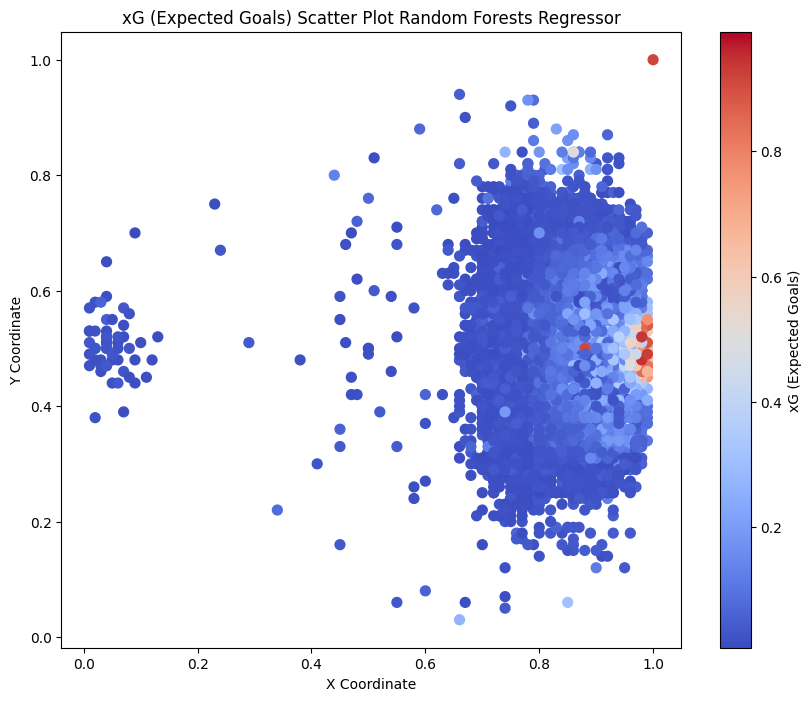

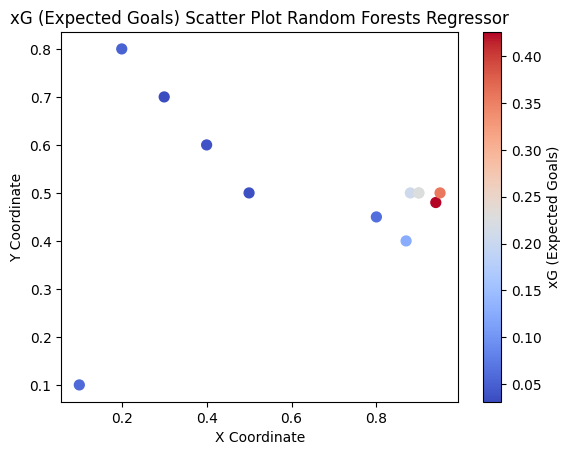

In [60]:
plt.figure(figsize=(10, 8))
# plt.scatter(data['X_coord'], data['Y_coord'], c=data['xG_calc_RFR'], cmap='coolwarm', s=50)
plt.scatter(X_test['X_coord'], X_test['Y_coord'], c=X_test['xG_calc_RFR'], cmap='coolwarm', s=50)
plt.colorbar(label='xG (Expected Goals)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('xG (Expected Goals) Scatter Plot Random Forests Regressor')
plt.show()


plt.scatter(new_xG_data['X_coord'], new_xG_data['Y_coord'], c=new_xG_data_RFR['New xG'], cmap='coolwarm', s=50)
plt.colorbar(label='xG (Expected Goals)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('xG (Expected Goals) Scatter Plot Random Forests Regressor')
plt.show()


In [350]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = testtrainsplit()
# Applying oversampling
X_train_resampled,y_train_resampled = sampling(X_train,y_train)
# Standardizing the features using scaler
scaler,X_train_scaled,X_train_scaled_resampled,X_test_scaled,X_data_scaled = scaling(X_train,X_train_resampled,X_test)

Sampling
Feature Scaling


In [351]:
#RANDOM FORESTS CLASSIFIER

rf_model = RandomForestClassifier(n_estimators=100,random_state=42)
rf_model_s = RandomForestClassifier(n_estimators=100,random_state=42)

rf_model.fit(X_train, y_train)
#rf_model_s.fit(X_train_resampled, y_train_resampled)
# rf_model_s.fit(X_train_scaled, y_train)
rf_model_s.fit(X_train_scaled_resampled, y_train_resampled)


#Predicting xG values for both training and testing sets
xG_train = rf_model.predict_proba(X_train)[:, 1]
xG_test = rf_model.predict_proba(X_test)[:, 1]
y_pred = rf_model.predict(X_test)



#SCALING
# xG_train = rf_model_s.predict_proba(X_train_scaled)[:, 1]
# xG_test = rf_model_s.predict_proba(X_test_scaled)[:, 1]
# y_pred = rf_model_s.predict(X_test_scaled)
#y_preds = rf_model_s.predict(X_test_scaled)

#SCALING RESAMPLED
# xG_train = rf_model_s.predict_proba(X_train_resampled)[:, 1]
# xG_test = rf_model_s.predict_proba(X_test)[:, 1]
#y_preds = rf_model_s.predict(X_test)
y_preds = rf_model_s.predict(X_test_scaled)

# Combinining xG values for the entire dataset
#xG_all = rf_model_s.predict_proba(features)[:, 1]
#xG_all = rf_model.predict_proba(features)[:, 1]
#xG_all = rf_model_s.predict_proba(X_data_scaled)[:, 1]  # Directly use predict_proba on the scaled features
xG_all = rf_model_s.predict_proba(X_test_scaled)[:, 1]
# data['xG_calc_RFC'] = xG_all
# X_test['xG_calc_RFC'] = xG_all

print("Random Forests Classifier")

Random Forests Classifier


In [352]:
# Defining hyperparameters 
# param_grid_rf= {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }


param_grid_rf= {
    'n_estimators': [300],
    'max_depth': [None, 10],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}


# Performing hyperparameter tuning using GridSearchCV
grid_search_rf = GridSearchCV(rf_model_s, param_grid_rf, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search_rf.fit(X_train_scaled_resampled, y_train_resampled)

# Getting the best Random Forests model
best_rf_model = grid_search_rf.best_estimator_
hyper_preds_rf = best_rf_model.predict_proba(X_test_scaled)[:, 1]
hyper_rf_preds = best_rf_model.predict(X_test_scaled)


# Printing best parameters and score from hyperparameter tuning
print("Best Parameters:", grid_search_rf.best_params_)
print("Best Score:", grid_search_rf.best_score_)
X_test['xG_calc_RFC'] = hyper_preds_rf


Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Score: 0.9772563562107002


In [353]:
print("Model Evaluation - RANDOM FORESTS CLASSIFIER")

accuracy = accuracy_score(y_test, y_preds)
print(f"Accuracy: {accuracy:.2f}")
precision = precision_score(y_test, y_preds)
print(f"Precision: {precision:.2f}")
recall = recall_score(y_test, y_preds)
print(f"Recall: {recall:.2f}")
#print(y_test,y_preds)
roc_auc = roc_auc_score(y_test, y_preds)
print(f"ROC AUC: {roc_auc:.2f}")
mse = mean_squared_error(y_test, y_preds)
print(f"Mean Squared Error: {mse:.2f}")
f1 = f1_score(y_test, y_preds)
print("F1 Score:", f1)
# log_loss_val = log_loss(y_test, y_preds)
# print("Log Loss value :", log_loss_val)
conf_matrix = confusion_matrix(y_test, y_preds)
print("Confusion Matrix:\n", conf_matrix)
#r2 = r2_score(y_test, y_preds)
#print("R-squared:", r2)
brier_score = brier_score_loss(y_test, y_preds)
print("Brier Score :", brier_score)



print("RANDOM FORESTS CLASSIFIER Hyper Parameter tuned Model Evaluation")

accuracy = accuracy_score(y_test, hyper_rf_preds)
print(f"Accuracy: {accuracy:.2f}")
precision = precision_score(y_test, hyper_rf_preds)
print(f"Precision: {precision:.2f}")
recall = recall_score(y_test, hyper_rf_preds)
print(f"Recall: {recall:.2f}")
#print(y_test,hyper_rf_preds)
roc_auc = roc_auc_score(y_test, hyper_rf_preds)
print(f"ROC AUC: {roc_auc:.2f}")
mse = mean_squared_error(y_test, hyper_rf_preds)
print(f"Mean Squared Error: {mse:.2f}")
f1 = f1_score(y_test, hyper_rf_preds)
print("F1 Score:", f1)
# log_loss_val = log_loss(y_test, hyper_rf_preds)
# print("Log Loss value :", log_loss_val)
conf_matrix = confusion_matrix(y_test, hyper_rf_preds)
print("Confusion Matrix:\n", conf_matrix)
#r2 = r2_score(y_test, hyper_rf_preds)
#print("R-squared:", r2)
brier_score = brier_score_loss(y_test, hyper_rf_preds)
print("Brier Score :", brier_score)

Model Evaluation - RANDOM FORESTS CLASSIFIER
Accuracy: 0.88
Precision: 0.41
Recall: 0.26
ROC AUC: 0.61
Mean Squared Error: 0.12
F1 Score: 0.31668237511781344
Confusion Matrix:
 [[10577   474]
 [  976   336]]
Brier Score : 0.11728544851573243
RANDOM FORESTS CLASSIFIER Hyper Parameter tuned Model Evaluation
Accuracy: 0.88
Precision: 0.42
Recall: 0.26
ROC AUC: 0.61
Mean Squared Error: 0.12
F1 Score: 0.32026452527161076
Confusion Matrix:
 [[10585   466]
 [  973   339]]
Brier Score : 0.11639569683733722


In [354]:
#RANDOM FORESTS CLASSIFIER xG Function

def calculate_xG_RFC(position_x, position_y,Y_coord_angle,is_penalty, is_header,is_home,is_OpenPlay,is_DirectFreekick,is_FromCorner,is_SetPiece,player_name,Last_Action,Team_rating,Opponent_rating):
    new_data_RFC = pd.DataFrame({
        'X_coord': [position_x],
        'Y_coord': [position_y],
        'Y_coord_angle' : [Y_coord_angle],
        'is_Penalty': [is_penalty],
        'is_head': [is_header],
        'is_home':[is_home],
        'is_OpenPlay' :[is_OpenPlay],
        'is_DirectFreekick' :[is_DirectFreekick],
        'is_FromCorner' :[is_FromCorner],
        'is_SetPiece' :[is_SetPiece],
        'overall' : [data.loc[data['Player name'] == player_name, 'overall'].values[0]],
        'value_eur' : [data.loc[data['Player name'] == player_name, 'value_eur'].values[0]],
        'shooting' : [data.loc[data['Player name'] == player_name, 'shooting'].values[0]],
        'Last_Action' : [Last_Action] ,
        'Team_rating' : [Team_rating],
        'Opponent_rating' : [Opponent_rating]
    })
    overall = new_data['overall']
    value_eur = new_data['value_eur']
    shooting = new_data['shooting']
    #Y_coord_angle = (1 - abs(position_y - 0.50) * 2)
    scaled_features = scaler.transform([[position_x, position_y, Y_coord_angle,is_penalty, is_header,is_home,is_OpenPlay,is_DirectFreekick,is_FromCorner,is_SetPiece,overall,value_eur,shooting,Last_Action,Team_rating,Opponent_rating]])
    #xG_probability = rf_model_s.predict_proba(new_data_RFC)[0, 1]
    #xg_prob = rf_model_s.predict(scaled_features)
    #xG_probability = rf_model.predict_proba(new_data_RFC)[0, 1]
    #xg_prob = rf_model_s.predict_proba(scaled_features)[:, 1]
    xg_prob = best_rf_model.predict_proba(scaled_features)[:, 1]
    #new_data_RFC['New xG']=xG_probability
    new_data_RFC['New xG']=xg_prob
    #print("xG probability: pos x",position_x,", pos y",position_y,", is_pen",is_penalty,", is_head",is_header,", is_home",is_home,":",xG_probability)
    #print("xG probability: pos x",position_x,", pos y",position_y,", is_pen",is_penalty,", is_head",is_header,", is_home",is_home,":",xg_prob[0])
    return xg_prob[0],new_data_RFC
    #return xG_probability, new_data_RFC



new_xG_data_RFC = pd.DataFrame(columns=['X_coord','Y_coord','Y_coord_angle','is_Penalty','is_head','is_home',
                                   'is_OpenPlay','is_DirectFreekick','is_FromCorner','is_SetPiece',
                                   'overall','value_eur','shooting','Last_Action','Team_rating','Opponent_rating'])


#'overall','value_eur','shooting'

parameter_sets = [
    (0.88, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.90, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.94, 0.48,(1-abs(0.48-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.90, 0.50,(1-abs(0.50-0.50)*2),0, 0, 0,1,0,0,0,player_name,10,85,75),
    (0.95, 0.50,(1-abs(0.50-0.50)*2),0, 1, 1,1,0,0,0,player_name,10,85,75),
    (0.87, 0.40,(1-abs(0.40-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.80, 0.45,(1-abs(0.45-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.50, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.40, 0.60,(1-abs(0.60-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.30, 0.70,(1-abs(0.70-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.20, 0.80,(1-abs(0.80-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.10, 0.10,(1-abs(0.10-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75)
]







for params in parameter_sets:
    xG_probability, new_data_RFC = calculate_xG_RFC(*params)
    new_xG_data_RFC=new_xG_data_RFC.append(new_data_RFC)

print(new_xG_data_RFC)



   X_coord  Y_coord  Y_coord_angle is_Penalty is_head is_home is_OpenPlay  \
0     0.88     0.50           1.00          0       0       1           1   
0     0.90     0.50           1.00          0       0       1           1   
0     0.94     0.48           0.96          0       0       1           1   
0     0.90     0.50           1.00          0       0       0           1   
0     0.95     0.50           1.00          0       1       1           1   
0     0.87     0.40           0.80          0       0       1           1   
0     0.80     0.45           0.90          0       0       1           1   
0     0.50     0.50           1.00          0       0       1           1   
0     0.40     0.60           0.80          0       0       1           1   
0     0.30     0.70           0.60          0       0       1           1   
0     0.20     0.80           0.40          0       0       1           1   
0     0.10     0.10           0.20          0       0       1           1   

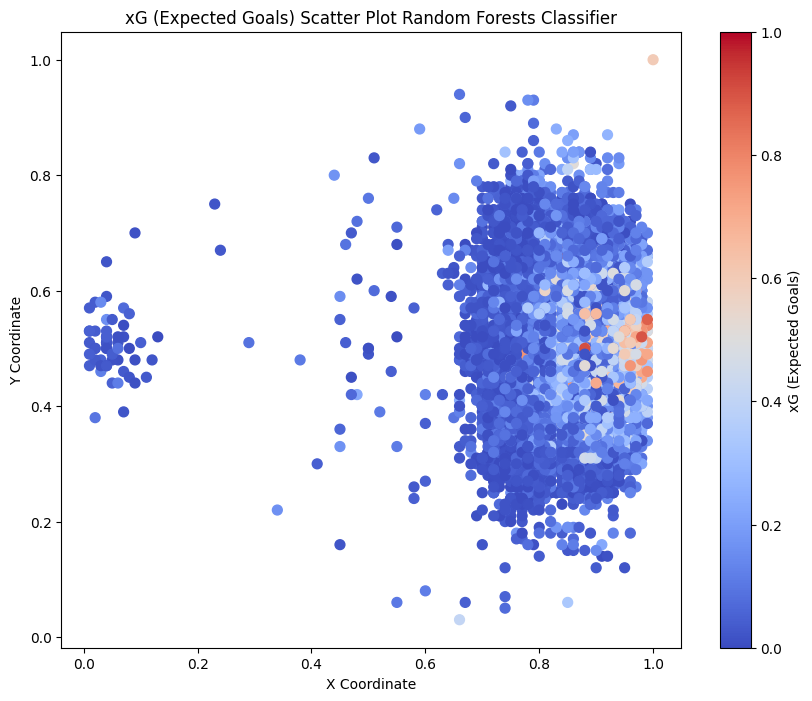

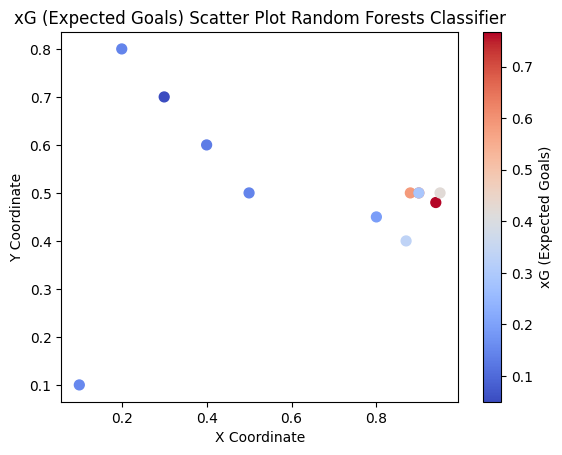

In [355]:
plt.figure(figsize=(10, 8))
#plt.scatter(data['X_coord'], data['Y_coord'], c=data['xG_calc_RFC'], cmap='coolwarm', s=50
plt.scatter(X_test['X_coord'], X_test['Y_coord'], c=X_test['xG_calc_RFC'], cmap='coolwarm', s=50)
plt.colorbar(label='xG (Expected Goals)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('xG (Expected Goals) Scatter Plot Random Forests Classifier')
plt.show()


plt.scatter(new_xG_data['X_coord'], new_xG_data['Y_coord'], c=new_xG_data_RFC['New xG'], cmap='coolwarm', s=50)
plt.colorbar(label='xG (Expected Goals)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('xG (Expected Goals) Scatter Plot Random Forests Classifier')
plt.show()


In [356]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = testtrainsplit()
# Applying oversampling
X_train_resampled,y_train_resampled = sampling(X_train,y_train)
# Standardizing the features using scaler
scaler,X_train_scaled,X_train_scaled_resampled,X_test_scaled,X_data_scaled = scaling(X_train,X_train_resampled,X_test)

Sampling
Feature Scaling


In [362]:
# ARTIFICIAL NEURAL NETWORK

# ann_model = keras.Sequential([
#     layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
#     layers.Dense(32, activation='relu'),
#     layers.Dense(1, activation='sigmoid')
# ])

# ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ann_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# xG_all = ann_model.predict(features)
# data['xG_calc_ANN'] = xG_all

# y_pred = ann_model.predict(X_test)


#---------------------------------------------------------------------------------------------------
#SAMPLED


# ann_model = keras.Sequential([
#     layers.Dense(64, activation='relu', input_shape=(X_train_resampled.shape[1],)),
#     layers.Dense(32, activation='relu'),
#     layers.Dense(1, activation='sigmoid')
# ])

# ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ann_model.fit(X_train_resampled, y_train_resampled, epochs=50, batch_size=32, verbose=1)

# xG_all = ann_model.predict(features)
# data['xG_calc_ANN'] = xG_all

# y_pred = ann_model.predict(X_test)


#------------------------------------------------------------------------------------------------------
#SCALED


# ann_model = keras.Sequential([
#     layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
#     layers.Dense(32, activation='relu'),
#     layers.Dense(1, activation='sigmoid')
# ])

# ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ann_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=1)

# xG_all = ann_model.predict(features)
#xG_all = ann_model.predict_proba(X_data_scaled)[:, 1]  # Directly use predict_proba on the scaled features
# data['xG_calc_ANN'] = xG_all

# y_pred = ann_model.predict(X_test_scaled)


#---------------------------------------------------------------------------------------------------------
#SCALED SAMPLED



ann_model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled_resampled.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

ann_model.fit(X_train_scaled_resampled, y_train_resampled, epochs=50, batch_size=32, verbose=1)

#xG_all = ann_model.predict(features)
#xG_all = ann_model.predict(X_data_scaled)
xG_all = ann_model.predict(X_test_scaled)
#xG_all = ann_model.predict_proba(X_data_scaled)[:, 1]  
# data['xG_calc_ANN'] = xG_all
X_test['xG_calc_ANN'] = xG_all

# y_pred_proba = ann_model.predict_proba(X_test_scaled)[:, 1]  
y_pred = ann_model.predict(X_test_scaled)


print("ARTIFICIAL NEURAL NETWORK")

Epoch 1/50
2763/2763 [==============================] - 4s 1ms/step - loss: 0.4505 - accuracy: 0.7806
Epoch 2/50
2763/2763 [==============================] - 4s 1ms/step - loss: 0.4180 - accuracy: 0.8006
Epoch 3/50
2763/2763 [==============================] - 4s 1ms/step - loss: 0.4130 - accuracy: 0.8030
Epoch 4/50
2763/2763 [==============================] - 4s 1ms/step - loss: 0.4081 - accuracy: 0.8083
Epoch 5/50
2763/2763 [==============================] - 4s 1ms/step - loss: 0.4029 - accuracy: 0.8115
Epoch 6/50
2763/2763 [==============================] - 4s 1ms/step - loss: 0.4007 - accuracy: 0.8120
Epoch 7/50
2763/2763 [==============================] - 4s 1ms/step - loss: 0.3955 - accuracy: 0.8159
Epoch 8/50
2763/2763 [==============================] - 4s 1ms/step - loss: 0.3935 - accuracy: 0.8178
Epoch 9/50
2763/2763 [==============================] - 4s 1ms/step - loss: 0.3923 - accuracy: 0.8187
Epoch 10/50
2763/2763 [==============================] - 4s 1ms/step - loss: 0.389

In [408]:
# Initializing the ANN model
ann_model_s = MLPClassifier(random_state=42)

# Hyperparameter tuning using GridSearchCV
# param_grid_ANN = {
#     'hidden_layer_sizes': [(100,), (50, 50), (50, 30, 10)],
#     'alpha': [0.0001, 0.001, 0.01],
#     'activation': ['relu', 'logistic']
# }


param_grid_ANN = {
    'hidden_layer_sizes': [(50, 50)],
    'alpha': [0.001],
    'activation': ['relu']
}



grid_search_ANN = GridSearchCV(ann_model_s, param_grid_ANN, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search_ANN.fit(X_train_scaled_resampled, y_train_resampled)

# Getting the best parameters and best model
best_params_ANN = grid_search_ANN.best_params_
best_ann_model = grid_search_ANN.best_estimator_

# Predicting xG probabilities
hyper_preds_ann = best_ann_model.predict_proba(X_test_scaled)[:, 1]
hyper_ann_preds = best_ann_model.predict(X_test_scaled)

print(best_params_ANN)

#X_test['xG_calc_ANN'] = hyper_preds_ann

{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50)}


In [364]:
print("Model Evaluation - ARTIFICIAL NEURAL NETWORK")

y_pred_binary = np.where(y_pred > 0.5, 1, 0)

accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy:.2f}")
precision = precision_score(y_test, y_pred_binary)
print(f"Precision: {precision:.2f}")
recall = recall_score(y_test, y_pred_binary)
print(f"Recall: {recall:.2f}")
#print(y_test,y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC: {roc_auc:.2f}")
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
f1 = f1_score(y_test, y_pred_binary)
print("F1 Score:", f1)
log_loss_val = log_loss(y_test, y_pred)
print("Log Loss value :", log_loss_val)
conf_matrix = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:\n", conf_matrix)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)



print("ANN MODEL HYPER PARAMETER TUNING Model Evaluation -")
accuracy = accuracy_score(y_test, hyper_ann_preds)
print(f"Accuracy: {accuracy:.2f}")
precision = precision_score(y_test, hyper_ann_preds)
print(f"Precision: {precision:.2f}")
recall = recall_score(y_test, hyper_ann_preds)
print(f"Recall: {recall:.2f}")
#print(y_test,hyper_ann_preds)
roc_auc = roc_auc_score(y_test, hyper_ann_preds)
print(f"ROC AUC: {roc_auc:.2f}")
mse = mean_squared_error(y_test, hyper_ann_preds)
print(f"Mean Squared Error: {mse:.2f}")
f1 = f1_score(y_test, hyper_ann_preds)
print("F1 Score:", f1)
log_loss_val = log_loss(y_test, hyper_preds_ann)
print("Log Loss value :", log_loss_val)
conf_matrix = confusion_matrix(y_test, hyper_ann_preds)
print("Confusion Matrix:\n", conf_matrix)
brier_score = brier_score_loss(y_test, hyper_ann_preds)
print("Brier Score :", brier_score)
#r2 = r2_score(y_test, hyper_ann_preds)
#print("R-squared:", r2)


Model Evaluation - ARTIFICIAL NEURAL NETWORK
Accuracy: 0.81
Precision: 0.29
Recall: 0.53
ROC AUC: 0.77
Mean Squared Error: 0.13
F1 Score: 0.3768817204301075
Log Loss value : 0.40687982834765923
Confusion Matrix:
 [[9344 1707]
 [ 611  701]]
R-squared: -0.3642740139294287
ANN MODEL HYPER PARAMETER TUNING Model Evaluation -
Accuracy: 0.80
Precision: 0.28
Recall: 0.57
ROC AUC: 0.70
Mean Squared Error: 0.20
F1 Score: 0.3793710691823899
Log Loss value : 0.42469349256259464
Confusion Matrix:
 [[9142 1909]
 [ 558  754]]
Brier Score : 0.19954703550918063


In [365]:
#ARTIFICIAL NEURAL NETWORK xG Function

def calculate_xG_ANN(position_x, position_y,Y_coord_angle,is_penalty, is_header,is_home,is_OpenPlay,is_DirectFreekick,is_FromCorner,is_SetPiece,player_name,Last_Action,Team_rating,Opponent_rating):
    new_data_ANN = pd.DataFrame({
        'X_coord': [position_x],
        'Y_coord': [position_y],
        'Y_coord_angle' : [Y_coord_angle],
        'is_Penalty': [is_penalty],
        'is_head': [is_header],
        'is_home':[is_home],
        'is_OpenPlay' :[is_OpenPlay],
        'is_DirectFreekick' :[is_DirectFreekick],
        'is_FromCorner' :[is_FromCorner],
        'is_SetPiece' :[is_SetPiece],
        'overall' : [data.loc[data['Player name'] == player_name, 'overall'].values[0]],
        'value_eur' : [data.loc[data['Player name'] == player_name, 'value_eur'].values[0]],
        'shooting' : [data.loc[data['Player name'] == player_name, 'shooting'].values[0]],
        'Last_Action' : [Last_Action] ,
        'Team_rating' : [Team_rating],
        'Opponent_rating' : [Opponent_rating]
    })
    overall = new_data['overall']
    value_eur = new_data['value_eur']
    shooting = new_data['shooting']
    #Y_coord_angle = (1 - abs(position_y - 0.50) * 2)
    scaled_features = scaler.transform([[position_x, position_y, Y_coord_angle,is_penalty, is_header,is_home,is_OpenPlay,is_DirectFreekick,is_FromCorner,is_SetPiece,overall,value_eur,shooting,Last_Action,Team_rating,Opponent_rating]])
    #xG_probability = ann_model.predict(new_data_ANN)  # Probability of scoring a goal
    #xG_probability = ann_model.predict_proba(new_data_ANN)[0, 1]
    xg_prob = ann_model.predict(scaled_features)
    #xg_prob = best_ann_model.predict_proba(scaled_features)[:, 1]
    #new_data_ANN['New xG']=xG_probability
    new_data_ANN['New xG']=xg_prob
    return xg_prob,new_data_ANN
    #return xG_probability, new_data_ANN



new_xG_data_ANN = pd.DataFrame(columns=['X_coord','Y_coord','Y_coord_angle','is_Penalty','is_head','is_home',
                                   'is_OpenPlay','is_DirectFreekick','is_FromCorner','is_SetPiece',
                                   'overall','value_eur','shooting','Last_Action','Team_rating','Opponent_rating'])


#'overall','value_eur','shooting'

parameter_sets = [
    (0.88, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.90, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.94, 0.48,(1-abs(0.48-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.90, 0.50,(1-abs(0.50-0.50)*2),0, 0, 0,1,0,0,0,player_name,10,85,75),
    (0.95, 0.50,(1-abs(0.50-0.50)*2),0, 1, 1,1,0,0,0,player_name,10,85,75),
    (0.87, 0.40,(1-abs(0.40-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.80, 0.45,(1-abs(0.45-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.50, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.40, 0.60,(1-abs(0.60-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.30, 0.70,(1-abs(0.70-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.20, 0.80,(1-abs(0.80-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.10, 0.10,(1-abs(0.10-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75)
]






for params in parameter_sets:
    xG_probability, new_data_ANN = calculate_xG_ANN(*params)
    new_xG_data_ANN=new_xG_data_ANN.append(new_data_ANN)

print(new_xG_data_ANN)



1/1 [==============================] - 0s 43ms/step
   X_coord  Y_coord  Y_coord_angle is_Penalty is_head is_home is_OpenPlay  \
0     0.88     0.50           1.00          0       0       1           1   
0     0.90     0.50           1.00          0       0       1           1   
0     0.94     0.48           0.96          0       0       1           1   
0     0.90     0.50           1.00          0       0       0           1   
0     0.95     0.50           1.00          0       1       1           1   
0     0.87     0.40           0.80          0       0       1           1   
0     0.80     0.45           0.90          0       0       1           1   
0     0.50     0.50           1.00          0       0       1           1   
0     0.40     0.60           0.80          0       0       1           1   
0     0.30     0.70           0.60          0       0       1           1   
0     0.20     0.80           0.40          0       0       1           1   
0     0.10     0.10     

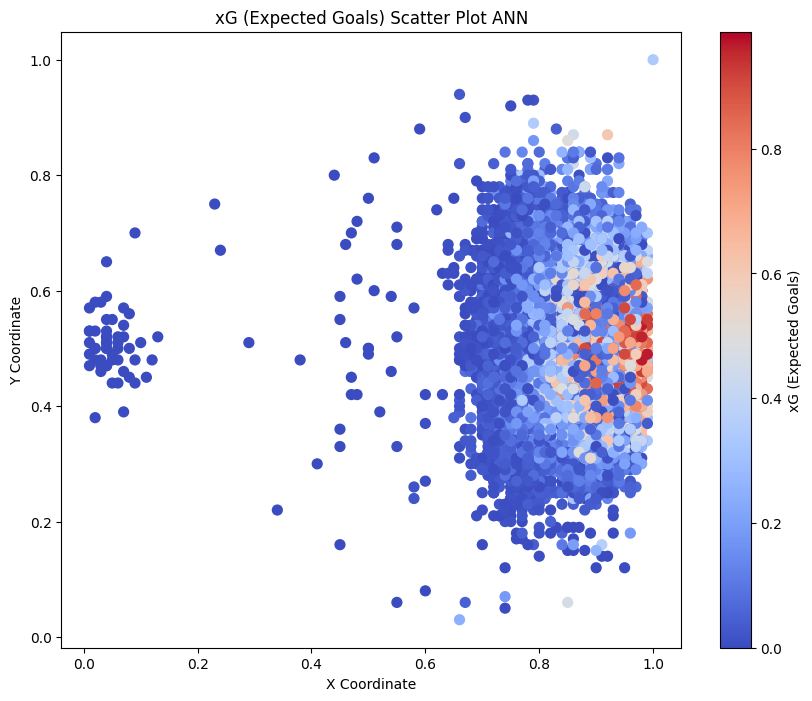

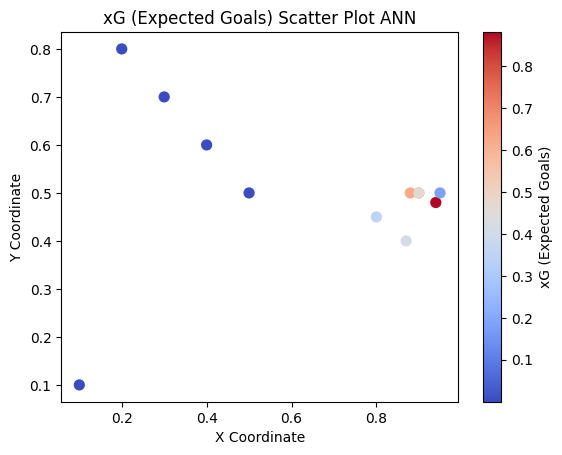

In [366]:
plt.figure(figsize=(10, 8))
# plt.scatter(data['X_coord'], data['Y_coord'], c=data['xG_calc_ANN'], cmap='coolwarm', s=50)
plt.scatter(X_test['X_coord'], X_test['Y_coord'], c=X_test['xG_calc_ANN'], cmap='coolwarm', s=50)
plt.colorbar(label='xG (Expected Goals)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('xG (Expected Goals) Scatter Plot ANN')
plt.show()


plt.scatter(new_xG_data['X_coord'], new_xG_data['Y_coord'], c=new_xG_data_ANN['New xG'], cmap='coolwarm', s=50)
plt.colorbar(label='xG (Expected Goals)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('xG (Expected Goals) Scatter Plot ANN')
plt.show()


In [397]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = testtrainsplit()
# Applying oversampling
X_train_resampled,y_train_resampled = sampling(X_train,y_train)
# Standardizing the features using scaler
scaler,X_train_scaled,X_train_scaled_resampled,X_test_scaled,X_data_scaled = scaling(X_train,X_train_resampled,X_test)

Test Train Split
Sampling
Feature Scaling


In [398]:
#LIGHT GRADIENT BOOSTING MODEL LIGHTGBM

# Buildig LightGBM model
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model_s = lgb.LGBMClassifier(random_state=42)


lgb_model.fit(X_train, y_train)
#lgb_model_s.fit(X_train_resampled,y_train_resampled)
lgb_model_s.fit(X_train_scaled, y_train)
#lgb_model_s.fit(X_train_scaled_resampled, y_train_resampled)


# Predicting xG values for both training and testing sets
y_pred = lgb_model.predict(X_test)
#y_preds = lgb_model_s.predict(X_test)
y_preds = lgb_model_s.predict(X_test_scaled)



# Combinining xG values for the entire dataset
#xG_all = lgb_model.predict_proba(features)[:, 1]
#xG_all = lgb_model_s.predict_proba(features)[:, 1]
#xG_all = lgb_model_s.predict_proba(X_data_scaled)[:, 1]  # Directly use predict_proba on the scaled features
#xG_all = lgb_model_s.predict(X_data_scaled)
# xG_all = lgb_model_s.predict_proba(X_data_scaled)[:, 1]
y_pred_proba = lgb_model_s.predict_proba(X_test_scaled)[:, 1]
xG_all = lgb_model_s.predict_proba(X_test_scaled)[:, 1]
# data['xG_calc_LGB'] = xG_all
X_test['xG_calc_LGB'] = xG_all


print("LIGHT GRADIENT BOOSTING MODEL Prediction")

[LightGBM] [Info] Number of positive: 5246, number of negative: 44204
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 526
[LightGBM] [Info] Number of data points in the train set: 49450, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.106087 -> initscore=-2.131349
[LightGBM] [Info] Start training from score -2.131349
[LightGBM] [Info] Number of positive: 5246, number of negative: 44204
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002925 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 523
[LightGBM] [Info] Number of data points in the train set: 49450, number of used features: 16
[LightGBM] [Info

In [399]:
#LIGHT GRADIENT BOOSTING MODEL HYPER PARAMETER TUNING


# Hyperparameter tuning
param_grid_LGM = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.1, 0.2],
    # Add more hyperparameters to tune
}

# Initializing GridSearchCV
grid_search_LGM = GridSearchCV(lgb_model_s, param_grid_LGM, cv=3, scoring='roc_auc', n_jobs=-1)
# grid_search = GridSearchCV(xgb_s, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)

# grid_search = GridSearchCV(xgb_s, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
#grid_search.fit(X_train_scaled, y_train_resampled)
grid_search_LGM.fit(X_train_scaled, y_train)

# Best parameters
print("Best Parameters:", grid_search_LGM.best_params_)

# Initializing  XGBoost model 
best_params_LGM = grid_search_LGM.best_params_
final_lgb_model = lgb.LGBMClassifier(**best_params_LGM, random_state=42)
# final_xgb_model.fit(X_train_scaled, y_train_resampled)
final_lgb_model.fit(X_train_scaled, y_train)

# Predict xG values
hyper_preds_lgb = final_lgb_model.predict_proba(X_test_scaled)[:, 1]
hyper_lgb_preds = final_lgb_model.predict(X_test_scaled)

X_test['xG_calc_LGB'] = hyper_preds_lgb



xG_all = final_lgb_model.predict_proba(X_data_scaled)[:, 1]
data['xG_calc_LGB'] = xG_all

print("xG values Copied into dataframe")


[LightGBM] [Info] Number of positive: 5246, number of negative: 44204
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 523
[LightGBM] [Info] Number of data points in the train set: 49450, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.106087 -> initscore=-2.131349
[LightGBM] [Info] Start training from score -2.131349
Best Parameters: {'learning_rate': 0.1, 'num_leaves': 31}
[LightGBM] [Info] Number of positive: 5246, number of negative: 44204
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 523
[LightGBM] [Info] Number of data points in the train set: 49450, number of used features: 16
[LightGBM] [Info] [bin

In [400]:
print("Model Evaluation metrics - LIGHTGBM ")

accuracy = accuracy_score(y_test, y_preds)
print(f"Accuracy: {accuracy:.2f}")
precision = precision_score(y_test, y_preds)
print(f"Precision: {precision:.2f}")
recall = recall_score(y_test, y_preds)
print(f"Recall: {recall:.2f}")
#print(y_test,y_preds)
roc_auc = roc_auc_score(y_test, y_preds)
print(f"ROC AUC: {roc_auc:.2f}")
mse = mean_squared_error(y_test, y_preds)
print(f"Mean Squared Error: {mse:.2f}")
f1 = f1_score(y_test, y_preds)
print("F1 Score:", f1)
log_loss_val = log_loss(y_test, y_pred_proba)
print("Log Loss value :", log_loss_val)
conf_matrix = confusion_matrix(y_test, y_preds)
print("Confusion Matrix:\n", conf_matrix)
# r2 = r2_score(y_test, y_preds)
# print("R-squared:", r2)
brier_score = brier_score_loss(y_test, y_preds)
print("Brier Score :", brier_score)


print("LIGHT GRADIENT BOOSTING MODEL HYPER PARAMETER TUNING Model Evaluation -")
accuracy = accuracy_score(y_test, hyper_lgb_preds)
print(f"Accuracy: {accuracy:.2f}")
precision = precision_score(y_test, hyper_lgb_preds)
print(f"Precision: {precision:.2f}")
recall = recall_score(y_test, hyper_lgb_preds)
print(f"Recall: {recall:.2f}")
#print(y_test,hyper_lgb_preds)
roc_auc = roc_auc_score(y_test, hyper_lgb_preds)
print(f"ROC AUC: {roc_auc:.2f}")
mse = mean_squared_error(y_test, hyper_lgb_preds)
print(f"Mean Squared Error: {mse:.2f}")
f1 = f1_score(y_test, hyper_lgb_preds)
print("F1 Score:", f1)
log_loss_val = log_loss(y_test, hyper_preds_lgb)
print("Log Loss value :", log_loss_val)
conf_matrix = confusion_matrix(y_test, hyper_lgb_preds)
print("Confusion Matrix:\n", conf_matrix)
brier_score = brier_score_loss(y_test, hyper_lgb_preds)
print("Brier Score :", brier_score)
#r2 = r2_score(y_test, hyper_lgb_preds)
#print("R-squared:", r2)


Model Evaluation metrics - LIGHTGBM 
Accuracy: 0.90
Precision: 0.67
Recall: 0.17
ROC AUC: 0.58
Mean Squared Error: 0.10
F1 Score: 0.27690447400241835
Log Loss value : 0.27069628466678625
Confusion Matrix:
 [[10938   113]
 [ 1083   229]]
Brier Score : 0.09674027339642481
LIGHT GRADIENT BOOSTING MODEL HYPER PARAMETER TUNING Model Evaluation -
Accuracy: 0.90
Precision: 0.67
Recall: 0.17
ROC AUC: 0.58
Mean Squared Error: 0.10
F1 Score: 0.27690447400241835
Log Loss value : 0.27069628466678625
Confusion Matrix:
 [[10938   113]
 [ 1083   229]]
Brier Score : 0.09674027339642481


In [401]:
#LIGHTGBM xG Function

def calculate_xG_LGM(position_x, position_y,Y_coord_angle,is_penalty, is_header,is_home,is_OpenPlay,is_DirectFreekick,is_FromCorner,is_SetPiece,player_name,Last_Action,Team_rating,Opponent_rating):
    new_data_LGM = pd.DataFrame({
        'X_coord': [position_x],
        'Y_coord': [position_y],
        'Y_coord_angle' : [Y_coord_angle],
        'is_Penalty': [is_penalty],
        'is_head': [is_header],
        'is_home':[is_home],
        'is_OpenPlay' :[is_OpenPlay],
        'is_DirectFreekick' :[is_DirectFreekick],
        'is_FromCorner' :[is_FromCorner],
        'is_SetPiece' :[is_SetPiece],
        'overall' : [data.loc[data['Player name'] == player_name, 'overall'].values[0]],
        'value_eur' : [data.loc[data['Player name'] == player_name, 'value_eur'].values[0]],
        'shooting' : [data.loc[data['Player name'] == player_name, 'shooting'].values[0]],
        'Last_Action' : [Last_Action] ,
        'Team_rating' : [Team_rating],
        'Opponent_rating' : [Opponent_rating]
    })
    overall = new_data['overall']
    value_eur = new_data['value_eur']
    shooting = new_data['shooting']
    #Y_coord_angle = (1 - abs(position_y - 0.50) * 2)
    scaled_features = scaler.transform([[position_x, position_y, Y_coord_angle,is_penalty, is_header,is_home,is_OpenPlay,is_DirectFreekick,is_FromCorner,is_SetPiece,overall,value_eur,shooting,Last_Action,Team_rating,Opponent_rating]])
    #xG_probability = lgb_model.predict_proba(new_data_LGM)[0, 1]  # Probability of scoring a goal
    #xG_probability = lgb_model_s.predict_proba(new_data_LGM)[0, 1]
    #xg_prob = lgb_model_s.predict_proba(scaled_features)[:, 1]
    xg_prob = final_lgb_model.predict_proba(scaled_features)[:, 1]
    #new_data_LGM['New xG']=xG_probability
    new_data_LGM['New xG']=xg_prob
    return xg_prob[0],new_data_LGM
    #return xG_probability, new_data_LGM



new_xG_data_LGM = pd.DataFrame(columns=['X_coord','Y_coord','Y_coord_angle','is_Penalty','is_head','is_home',
                                   'is_OpenPlay','is_DirectFreekick','is_FromCorner','is_SetPiece',
                                   'overall','value_eur','shooting','Last_Action','Team_rating','Opponent_rating'])


#'overall','value_eur','shooting'

parameter_sets = [
    (0.88, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.90, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.94, 0.48,(1-abs(0.48-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.90, 0.50,(1-abs(0.50-0.50)*2),0, 0, 0,1,0,0,0,player_name,10,85,75),
    (0.95, 0.50,(1-abs(0.50-0.50)*2),0, 1, 1,1,0,0,0,player_name,10,85,75),
    (0.87, 0.40,(1-abs(0.40-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.80, 0.45,(1-abs(0.45-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.50, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.40, 0.60,(1-abs(0.60-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.30, 0.70,(1-abs(0.70-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.20, 0.80,(1-abs(0.80-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.10, 0.10,(1-abs(0.10-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75)
]






# new_xG_data_LGM = []

for params in parameter_sets:
    xG_probability, new_data_LGM = calculate_xG_LGM(*params)
    new_xG_data_LGM=new_xG_data_LGM.append(new_data_LGM)

print(new_xG_data_LGM)



   X_coord  Y_coord  Y_coord_angle is_Penalty is_head is_home is_OpenPlay  \
0     0.88     0.50           1.00          0       0       1           1   
0     0.90     0.50           1.00          0       0       1           1   
0     0.94     0.48           0.96          0       0       1           1   
0     0.90     0.50           1.00          0       0       0           1   
0     0.95     0.50           1.00          0       1       1           1   
0     0.87     0.40           0.80          0       0       1           1   
0     0.80     0.45           0.90          0       0       1           1   
0     0.50     0.50           1.00          0       0       1           1   
0     0.40     0.60           0.80          0       0       1           1   
0     0.30     0.70           0.60          0       0       1           1   
0     0.20     0.80           0.40          0       0       1           1   
0     0.10     0.10           0.20          0       0       1           1   

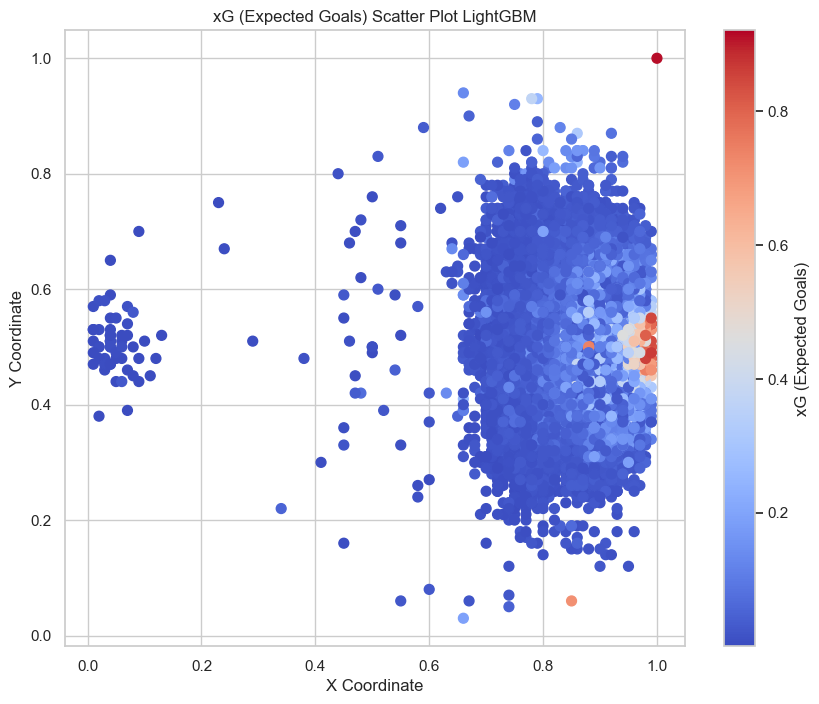

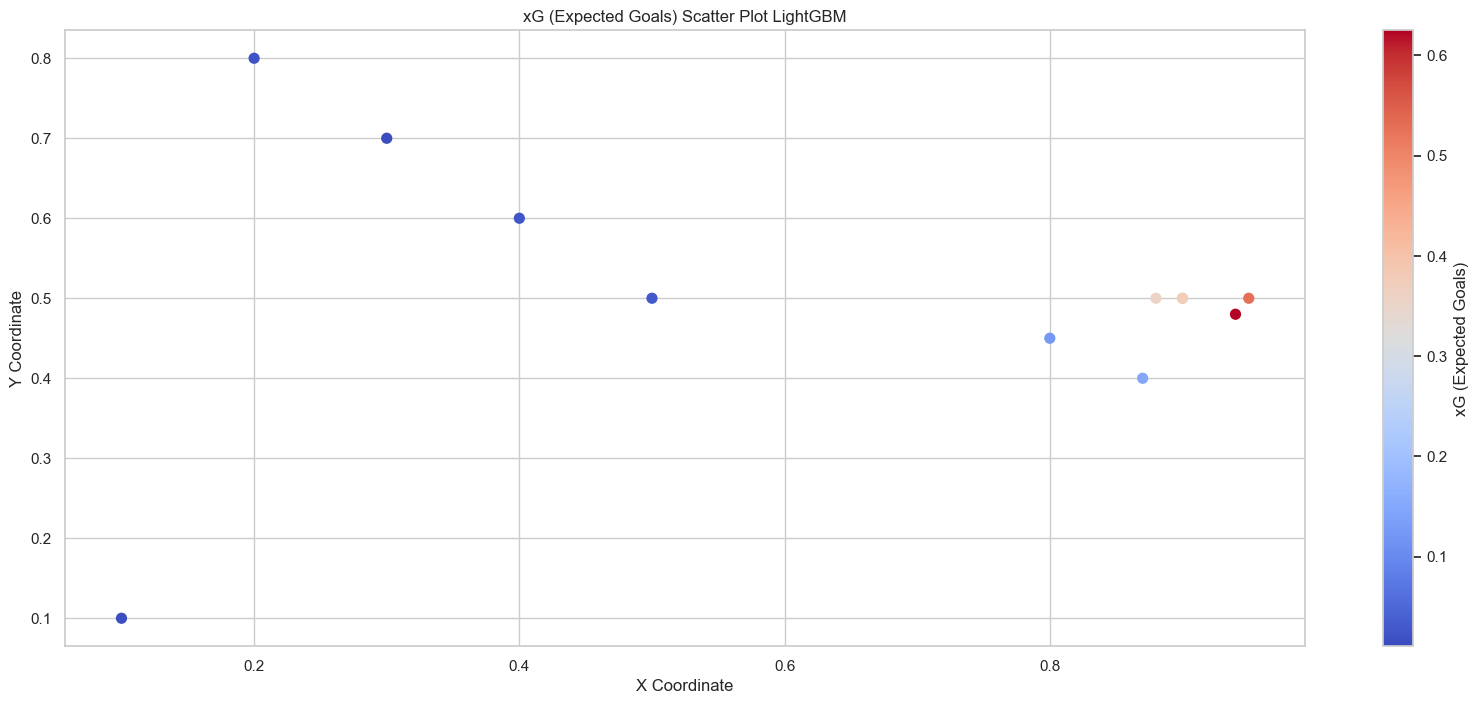

In [402]:
plt.figure(figsize=(10, 8))
# plt.scatter(data['X_coord'], data['Y_coord'], c=data['xG_calc_LGM'], cmap='coolwarm', s=50)
plt.scatter(X_test['X_coord'], X_test['Y_coord'], c=X_test['xG_calc_LGB'], cmap='coolwarm', s=50)
plt.colorbar(label='xG (Expected Goals)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('xG (Expected Goals) Scatter Plot LightGBM')
plt.show()


plt.scatter(new_xG_data['X_coord'], new_xG_data['Y_coord'], c=new_xG_data_LGM['New xG'], cmap='coolwarm', s=50)
plt.colorbar(label='xG (Expected Goals)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('xG (Expected Goals) Scatter Plot LightGBM')
plt.show()


In [373]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = testtrainsplit()
# Applying oversampling
X_train_resampled,y_train_resampled = sampling(X_train,y_train)
# Standardizing the features using scaler
scaler,X_train_scaled,X_train_scaled_resampled,X_test_scaled,X_data_scaled = scaling(X_train,X_train_resampled,X_test)

Sampling
Feature Scaling


In [374]:
#ADABOOST MODEL

# Building ADABOOST model
adaboost_model = AdaBoostClassifier(random_state=42)
adaboost_model_s = AdaBoostClassifier(random_state=42)


adaboost_model.fit(X_train, y_train)
#adaboost_model_s.fit(X_train_resampled,y_train_resampled)
#adaboost_model_s.fit(X_train_scaled, y_train)
adaboost_model_s.fit(X_train_scaled_resampled, y_train_resampled)


# Predicting xG values for both training and testing sets
y_pred = adaboost_model.predict(X_test)
#y_preds = adaboost_model_s.predict(X_test)
y_preds = adaboost_model_s.predict(X_test_scaled)


# Combinining xG values for the entire dataset
#xG_all = adaboost_model.predict_proba(features)[:, 1]
#xG_all = adaboost_model_s.predict_proba(features)[:, 1]
#xG_all = adaboost_model_s.predict_proba(X_data_scaled)[:, 1]  # Directly use predict_proba on the scaled features
y_pred_proba = adaboost_model_s.predict_proba(X_test_scaled)[:, 1]
xG_all =  adaboost_model_s.predict(X_test_scaled)
#X_test['xG_calc_ADABOOST'] = xG_all

#data['xG_calc_ADABOOST'] = xG_all

print("ADABOOST MODEL Prediction")

ADABOOST MODEL Prediction


In [375]:
#ADABOOST MODEL HYPER PARAMETER TUNING

# Hyperparameter tuning
# param_grid_ADA = {
#     'n_estimators': [50, 100, 200,300,500],
#     'learning_rate': [0.01, 0.1, 0.2,0.3,0.5],
#     # Add more hyperparameters to tune
# }

param_grid_ADA = {
    'n_estimators': [500],
    'learning_rate': [0.5],
    # Add more hyperparameters to tune
}

# Initializing GridSearchCV
grid_search_ADA = GridSearchCV(adaboost_model_s, param_grid_ADA, cv=3, scoring='roc_auc', n_jobs=-1)
# grid_search = GridSearchCV(xgb_s, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)

# grid_search = GridSearchCV(xgb_s, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
#grid_search.fit(X_train_scaled, y_train_resampled)
grid_search_ADA.fit(X_train_scaled_resampled, y_train_resampled)

# Printing best parameters
print("Best Parameters:", grid_search_ADA.best_params_)

# Initializing the XGBoost model with best parameters
best_params_ADA = grid_search_ADA.best_params_
final_adaboost_model = AdaBoostClassifier(**best_params_ADA, random_state=42)
# final_xgb_model.fit(X_train_scaled, y_train_resampled)
final_adaboost_model.fit(X_train_scaled_resampled, y_train_resampled)

# Predicting xG values on the scaled test set
hyper_preds_adaboost = final_adaboost_model.predict_proba(X_test_scaled)[:, 1]
hyper_adaboost_preds = final_adaboost_model.predict(X_test_scaled)

X_test['xG_calc_adaboost'] = hyper_preds_adaboost



Best Parameters: {'learning_rate': 0.5, 'n_estimators': 500}


In [376]:
print("Model Evaluation metrics - ADABOOST Model ")


y_preds = (y_pred_proba > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_preds)
print(f"Accuracy: {accuracy:.2f}")
precision = precision_score(y_test, y_preds)
print(f"Precision: {precision:.2f}")
recall = recall_score(y_test, y_preds)
print(f"Recall: {recall:.2f}")
#print(y_test,y_preds)
roc_auc = roc_auc_score(y_test, y_preds)
print(f"ROC AUC: {roc_auc:.2f}")
mse = mean_squared_error(y_test, y_preds)
print(f"Mean Squared Error: {mse:.2f}")
f1 = f1_score(y_test, y_preds)
print("F1 Score:", f1)
log_loss_val = log_loss(y_test, y_pred_proba)
print("Log Loss value :", log_loss_val)
conf_matrix = confusion_matrix(y_test, y_preds)
print("Confusion Matrix:\n", conf_matrix)
# r2 = r2_score(y_test, y_preds)
# print("R-squared:", r2)
brier_score = brier_score_loss(y_test, y_preds)
print("Brier Score :", brier_score)





print("ADABOOST MODEL HYPER PARAMETER TUNING Model Evaluation -")
accuracy = accuracy_score(y_test, hyper_adaboost_preds)
print(f"Accuracy: {accuracy:.2f}")
precision = precision_score(y_test, hyper_adaboost_preds)
print(f"Precision: {precision:.2f}")
recall = recall_score(y_test, hyper_adaboost_preds)
print(f"Recall: {recall:.2f}")
#print(y_test,hyper_adaboost_preds)
roc_auc = roc_auc_score(y_test, hyper_adaboost_preds)
print(f"ROC AUC: {roc_auc:.2f}")
mse = mean_squared_error(y_test, hyper_adaboost_preds)
print(f"Mean Squared Error: {mse:.2f}")
f1 = f1_score(y_test, hyper_adaboost_preds)
print("F1 Score:", f1)
log_loss_val = log_loss(y_test, hyper_preds_adaboost)
print("Log Loss value :", log_loss_val)
conf_matrix = confusion_matrix(y_test, hyper_adaboost_preds)
print("Confusion Matrix:\n", conf_matrix)
brier_score = brier_score_loss(y_test, hyper_adaboost_preds)
print("Brier Score :", brier_score)
#r2 = r2_score(y_test, hyper_adaboost_preds)
#print("R-squared:", r2)


Model Evaluation metrics - ADABOOST Model 
Accuracy: 0.80
Precision: 0.28
Recall: 0.54
ROC AUC: 0.68
Mean Squared Error: 0.20
F1 Score: 0.36415436415436414
Log Loss value : 0.6803246086270368
Confusion Matrix:
 [[9205 1846]
 [ 609  703]]
Brier Score : 0.19857639731456767
ADABOOST MODEL HYPER PARAMETER TUNING Model Evaluation -
Accuracy: 0.85
Precision: 0.33
Recall: 0.42
ROC AUC: 0.66
Mean Squared Error: 0.15
F1 Score: 0.3674983142279164
Log Loss value : 0.6900217176790011
Confusion Matrix:
 [[9942 1109]
 [ 767  545]]
Brier Score : 0.15174310442449243


In [377]:
#ADABOOST xG Function

def calculate_xG_adaboost(position_x, position_y,Y_coord_angle,is_penalty, is_header,is_home,is_OpenPlay,is_DirectFreekick,is_FromCorner,is_SetPiece,player_name,Last_Action,Team_rating,Opponent_rating):
    new_data_adaboost = pd.DataFrame({
        'X_coord': [position_x],
        'Y_coord': [position_y],
        'Y_coord_angle' : [Y_coord_angle],
        'is_Penalty': [is_penalty],
        'is_head': [is_header],
        'is_home':[is_home],
        'is_OpenPlay' :[is_OpenPlay],
        'is_DirectFreekick' :[is_DirectFreekick],
        'is_FromCorner' :[is_FromCorner],
        'is_SetPiece' :[is_SetPiece],
        'overall' : [data.loc[data['Player name'] == player_name, 'overall'].values[0]],
        'value_eur' : [data.loc[data['Player name'] == player_name, 'value_eur'].values[0]],
        'shooting' : [data.loc[data['Player name'] == player_name, 'shooting'].values[0]],
        'Last_Action' : [Last_Action] ,
        'Team_rating' : [Team_rating],
        'Opponent_rating' : [Opponent_rating]
    })
    overall = new_data['overall']
    value_eur = new_data['value_eur']
    shooting = new_data['shooting']
    #Y_coord_angle = (1 - abs(position_y - 0.50) * 2)
    scaled_features = scaler.transform([[position_x, position_y, Y_coord_angle,is_penalty, is_header,is_home,is_OpenPlay,is_DirectFreekick,is_FromCorner,is_SetPiece,overall,value_eur,shooting,Last_Action,Team_rating,Opponent_rating]])
    #xG_probability = adaboost_model.predict_proba(new_data_adaboost)[0, 1]  # Probability of scoring a goal
    #xG_probability = adaboost_model_s.predict_proba(new_data_adaboost)[0, 1]
    #xg_prob = adaboost_model_s.predict_proba(scaled_features)[:, 1]
    xg_prob = final_adaboost_model.predict_proba(scaled_features)[:, 1]
    #new_data_adaboost['New xG']=xG_probability
    new_data_adaboost['New xG']=xg_prob
    return xg_prob[0],new_data_adaboost
    #return xG_probability, new_data_adaboost



new_xG_data_adaboost  = pd.DataFrame(columns=['X_coord','Y_coord','Y_coord_angle','is_Penalty','is_head','is_home',
                                   'is_OpenPlay','is_DirectFreekick','is_FromCorner','is_SetPiece',
                                   'overall','value_eur','shooting','Last_Action','Team_rating','Opponent_rating'])


#'overall','value_eur','shooting'

parameter_sets = [
    (0.88, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.90, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.94, 0.48,(1-abs(0.48-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.90, 0.50,(1-abs(0.50-0.50)*2),0, 0, 0,1,0,0,0,player_name,10,85,75),
    (0.95, 0.50,(1-abs(0.50-0.50)*2),0, 1, 1,1,0,0,0,player_name,10,85,75),
    (0.87, 0.40,(1-abs(0.40-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.80, 0.45,(1-abs(0.45-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.50, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.40, 0.60,(1-abs(0.60-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.30, 0.70,(1-abs(0.70-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.20, 0.80,(1-abs(0.80-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.10, 0.10,(1-abs(0.10-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75)
]






# new_xG_data_adaboost = []

for params in parameter_sets:
    xG_probability, new_data_adaboost = calculate_xG_adaboost(*params)
    new_xG_data_adaboost=new_xG_data_adaboost.append(new_data_adaboost)

print(new_xG_data_adaboost)



   X_coord  Y_coord  Y_coord_angle is_Penalty is_head is_home is_OpenPlay  \
0     0.88     0.50           1.00          0       0       1           1   
0     0.90     0.50           1.00          0       0       1           1   
0     0.94     0.48           0.96          0       0       1           1   
0     0.90     0.50           1.00          0       0       0           1   
0     0.95     0.50           1.00          0       1       1           1   
0     0.87     0.40           0.80          0       0       1           1   
0     0.80     0.45           0.90          0       0       1           1   
0     0.50     0.50           1.00          0       0       1           1   
0     0.40     0.60           0.80          0       0       1           1   
0     0.30     0.70           0.60          0       0       1           1   
0     0.20     0.80           0.40          0       0       1           1   
0     0.10     0.10           0.20          0       0       1           1   

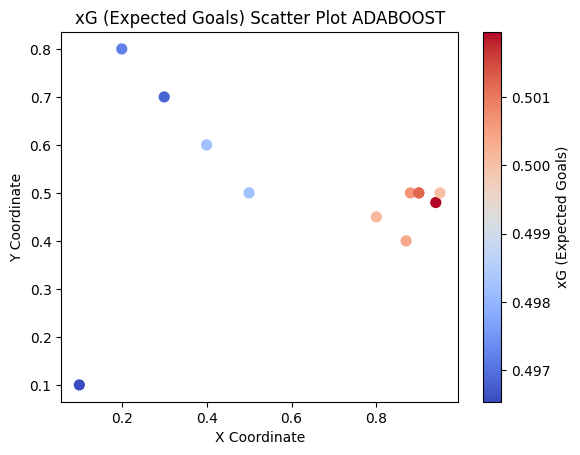

In [378]:
# plt.figure(figsize=(10, 8))
# # plt.scatter(data['X_coord'], data['Y_coord'], c=data['xG_calc_ADABOOST'], cmap='coolwarm', s=50)
# plt.scatter(X_test['X_coord'], X_test['Y_coord'], c=hyper_preds_adaboost, cmap='coolwarm', s=50)
# plt.colorbar(label='xG (Expected Goals)')
# plt.xlabel('X Coordinate')
# plt.ylabel('Y Coordinate')
# plt.title('xG (Expected Goals) Scatter Plot')
# plt.show()


plt.scatter(new_xG_data['X_coord'], new_xG_data['Y_coord'], c=new_xG_data_adaboost['New xG'], cmap='coolwarm', s=50)
plt.colorbar(label='xG (Expected Goals)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('xG (Expected Goals) Scatter Plot ADABOOST')
plt.show()


In [379]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = testtrainsplit()
# Applying oversampling
X_train_resampled,y_train_resampled = sampling(X_train,y_train)
# Standardizing the features using scaler
scaler,X_train_scaled,X_train_scaled_resampled,X_test_scaled,X_data_scaled = scaling(X_train,X_train_resampled,X_test)

Sampling
Feature Scaling


In [409]:
#catboost MODEL

# Building catboost model
catboost_model = CatBoostClassifier(random_state=42)
catboost_model_s = CatBoostClassifier(random_state=42)


catboost_model.fit(X_train, y_train)
#catboost_model_s.fit(X_train_resampled,y_train_resampled)
#catboost_model_s.fit(X_train_scaled, y_train)
catboost_model_s.fit(X_train_scaled_resampled, y_train_resampled)


# Predicting xG values for both training and testing sets
y_pred = catboost_model.predict(X_test)
#y_preds = catboost_model_s.predict(X_test)
y_preds = catboost_model_s.predict(X_test_scaled)



# Combinining xG values for the entire dataset
#xG_all = catboost_model.predict_proba(features)[:, 1]
#xG_all = catboost_model_s.predict_proba(features)[:, 1]
y_pred_proba = catboost_model_s.predict_proba(X_test_scaled)[:, 1]
xG_all = catboost_model_s.predict_proba(X_test_scaled)[:, 1] 
#data['xG_calc_catboost'] = xG_all
#X_test['xG_calc_catboost'] = xG_all



print("catboost MODEL Prediction")
print(xG_all)

Learning rate set to 0.054493
0:	learn: 0.6392470	total: 81.4ms	remaining: 1m 21s
1:	learn: 0.5935498	total: 106ms	remaining: 53s
2:	learn: 0.5546379	total: 133ms	remaining: 44.2s
3:	learn: 0.5187963	total: 159ms	remaining: 39.6s
4:	learn: 0.4877771	total: 182ms	remaining: 36.2s
5:	learn: 0.4628161	total: 204ms	remaining: 33.9s
6:	learn: 0.4419568	total: 221ms	remaining: 31.4s
7:	learn: 0.4221638	total: 238ms	remaining: 29.4s
8:	learn: 0.4076184	total: 256ms	remaining: 28.2s
9:	learn: 0.3937311	total: 277ms	remaining: 27.4s
10:	learn: 0.3800343	total: 300ms	remaining: 27s
11:	learn: 0.3688502	total: 321ms	remaining: 26.4s
12:	learn: 0.3594179	total: 342ms	remaining: 25.9s
13:	learn: 0.3505095	total: 361ms	remaining: 25.4s
14:	learn: 0.3419150	total: 385ms	remaining: 25.3s
15:	learn: 0.3344436	total: 409ms	remaining: 25.1s
16:	learn: 0.3276481	total: 431ms	remaining: 24.9s
17:	learn: 0.3214030	total: 453ms	remaining: 24.7s
18:	learn: 0.3161090	total: 471ms	remaining: 24.3s
19:	learn: 0.

In [381]:
#catBOOST MODEL HYPER PARAMETER TUNING

# Hyperparameter tuning
# Define the parameter grid for tuning
# param_grid_cat= {
#     'iterations': [100, 200, 300],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'depth': [4, 6, 8]
# }

param_grid_cat= {
    'iterations': [300],
    'learning_rate': [0.1],
    'depth': [8]
}
# Initialize GridSearchCV
grid_search_cat = GridSearchCV(catboost_model_s, param_grid_cat, cv=3, scoring='roc_auc', n_jobs=-1)
# grid_search = GridSearchCV(xgb_s, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)

# grid_search = GridSearchCV(xgb_s, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
#grid_search.fit(X_train_scaled, y_train_resampled)
grid_search_cat.fit(X_train_scaled_resampled, y_train_resampled)



# Initialize the XGBoost model with best parameters
best_params_cat = grid_search_cat.best_params_
final_catboost_model = CatBoostClassifier(**best_params_cat, random_state=42)
# final_xgb_model.fit(X_train_scaled, y_train_resampled)
final_catboost_model.fit(X_train_scaled_resampled, y_train_resampled)

# Predict xG values on the scaled test set
hyper_preds_catboost = final_catboost_model.predict_proba(X_test_scaled)[:, 1]
hyper_catboost_preds = final_catboost_model.predict(X_test_scaled)

X_test['xG_calc_catboost'] = hyper_preds_catboost

# Print best parameters
print("Best Parameters:", grid_search_cat.best_params_)



0:	learn: 0.6224134	total: 84.4ms	remaining: 25.2s
1:	learn: 0.5828838	total: 152ms	remaining: 22.6s
2:	learn: 0.5534927	total: 205ms	remaining: 20.3s
3:	learn: 0.5316782	total: 248ms	remaining: 18.4s
4:	learn: 0.5144651	total: 296ms	remaining: 17.5s
5:	learn: 0.4847397	total: 353ms	remaining: 17.3s
6:	learn: 0.4674035	total: 406ms	remaining: 17s
7:	learn: 0.4515928	total: 454ms	remaining: 16.6s
8:	learn: 0.4278134	total: 505ms	remaining: 16.3s
9:	learn: 0.4198149	total: 554ms	remaining: 16.1s
10:	learn: 0.4025903	total: 602ms	remaining: 15.8s
11:	learn: 0.3847177	total: 652ms	remaining: 15.7s
12:	learn: 0.3716295	total: 705ms	remaining: 15.6s
13:	learn: 0.3616301	total: 751ms	remaining: 15.3s
14:	learn: 0.3536721	total: 807ms	remaining: 15.3s
15:	learn: 0.3462191	total: 857ms	remaining: 15.2s
16:	learn: 0.3414410	total: 909ms	remaining: 15.1s
17:	learn: 0.3348640	total: 961ms	remaining: 15.1s
18:	learn: 0.3265510	total: 1.01s	remaining: 14.9s
19:	learn: 0.3193792	total: 1.05s	remainin

In [410]:
print("Model Evaluation metrics - CATBOOST Model ")

accuracy = accuracy_score(y_test, y_preds)
print(f"Accuracy: {accuracy:.2f}")
precision = precision_score(y_test, y_preds)
print(f"Precision: {precision:.2f}")
recall = recall_score(y_test, y_preds)
print(f"Recall: {recall:.2f}")
#print(y_test,y_preds)
roc_auc = roc_auc_score(y_test, y_preds)
print(f"ROC AUC: {roc_auc:.2f}")
mse = mean_squared_error(y_test, y_preds)
print(f"Mean Squared Error: {mse:.2f}")
f1 = f1_score(y_test, y_preds)
print("F1 Score:", f1)
log_loss_val = log_loss(y_test, y_pred_proba)
print("Log Loss value :", log_loss_val)
conf_matrix = confusion_matrix(y_test, y_preds)
print("Confusion Matrix:\n", conf_matrix)
# r2 = r2_score(y_test, y_preds)
# print("R-squared:", r2)
brier_score = brier_score_loss(y_test, y_preds)
print("Brier Score :", brier_score)



print("catBOOST MODEL HYPER PARAMETER TUNING Model Evaluation -")
accuracy = accuracy_score(y_test, hyper_catboost_preds)
print(f"Accuracy: {accuracy:.2f}")
precision = precision_score(y_test, hyper_catboost_preds)
print(f"Precision: {precision:.2f}")
recall = recall_score(y_test, hyper_catboost_preds)
print(f"Recall: {recall:.2f}")
#print(y_test,hyper_catboost_preds)
roc_auc = roc_auc_score(y_test, hyper_catboost_preds)
print(f"ROC AUC: {roc_auc:.2f}")
mse = mean_squared_error(y_test, hyper_catboost_preds)
print(f"Mean Squared Error: {mse:.2f}")
f1 = f1_score(y_test, hyper_catboost_preds)
print("F1 Score:", f1)
log_loss_val = log_loss(y_test, hyper_preds_catboost)
print("Log Loss value :", log_loss_val)
conf_matrix = confusion_matrix(y_test, hyper_catboost_preds)
print("Confusion Matrix:\n", conf_matrix)
brier_score = brier_score_loss(y_test, hyper_catboost_preds)
print("Brier Score :", brier_score)
#r2 = r2_score(y_test, hyper_catboost_preds)
#print("R-squared:", r2)


Model Evaluation metrics - CATBOOST Model 
Accuracy: 0.90
Precision: 0.59
Recall: 0.21
ROC AUC: 0.60
Mean Squared Error: 0.10
F1 Score: 0.3096846846846847
Log Loss value : 0.27781923633497185
Confusion Matrix:
 [[10862   189]
 [ 1037   275]]
Brier Score : 0.09916686888295721
catBOOST MODEL HYPER PARAMETER TUNING Model Evaluation -
Accuracy: 0.90
Precision: 0.60
Recall: 0.21
ROC AUC: 0.60
Mean Squared Error: 0.10
F1 Score: 0.3141891891891892
Log Loss value : 0.27802961350143796
Confusion Matrix:
 [[10866   185]
 [ 1033   279]]
Brier Score : 0.09851977675321524


In [384]:
#catboost xG Function

def calculate_xG_catboost(position_x, position_y,Y_coord_angle,is_penalty, is_header,is_home,is_OpenPlay,is_DirectFreekick,is_FromCorner,is_SetPiece,player_name,Last_Action,Team_rating,Opponent_rating):
    new_data_catboost = pd.DataFrame({
        'X_coord': [position_x],
        'Y_coord': [position_y],
        'Y_coord_angle' : [Y_coord_angle],
        'is_Penalty': [is_penalty],
        'is_head': [is_header],
        'is_home':[is_home],
        'is_OpenPlay' :[is_OpenPlay],
        'is_DirectFreekick' :[is_DirectFreekick],
        'is_FromCorner' :[is_FromCorner],
        'is_SetPiece' :[is_SetPiece],
        'overall' : [data.loc[data['Player name'] == player_name, 'overall'].values[0]],
        'value_eur' : [data.loc[data['Player name'] == player_name, 'value_eur'].values[0]],
        'shooting' : [data.loc[data['Player name'] == player_name, 'shooting'].values[0]],
        'Last_Action' : [Last_Action] ,
        'Team_rating' : [Team_rating],
        'Opponent_rating' : [Opponent_rating]
    })
    overall = new_data['overall']
    value_eur = new_data['value_eur']
    shooting = new_data['shooting']
    #Y_coord_angle = (1 - abs(position_y - 0.50) * 2)
    scaled_features = scaler.transform([[position_x, position_y, Y_coord_angle,is_penalty, is_header,is_home,is_OpenPlay,is_DirectFreekick,is_FromCorner,is_SetPiece,overall,value_eur,shooting,Last_Action,Team_rating,Opponent_rating]])
    #xG_probability = catboost_model.predict_proba(new_data_catboost)[0, 1]  # Probability of scoring a goal
    #xG_probability = catboost_model_s.predict_proba(new_data_catboost)[0, 1]
    #xg_prob = catboost_model_s.predict_proba(scaled_features)[:, 1]
    xg_prob = final_catboost_model.predict_proba(scaled_features)[:, 1]
    #new_data_catboost['New xG']=xG_probability
    new_data_catboost['New xG']=xg_prob
    return xg_prob[0],new_data_catboost
    #return xG_probability, new_data_catboost



new_xG_data_catboost = pd.DataFrame(columns=['X_coord','Y_coord','Y_coord_angle','is_Penalty','is_head','is_home',
                                   'is_OpenPlay','is_DirectFreekick','is_FromCorner','is_SetPiece',
                                   'overall','value_eur','shooting','Last_Action','Team_rating','Opponent_rating'])


#'overall','value_eur','shooting'

parameter_sets = [
    (0.88, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.90, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.94, 0.48,(1-abs(0.48-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.90, 0.50,(1-abs(0.50-0.50)*2),0, 0, 0,1,0,0,0,player_name,10,85,75),
    (0.95, 0.50,(1-abs(0.50-0.50)*2),0, 1, 1,1,0,0,0,player_name,10,85,75),
    (0.87, 0.40,(1-abs(0.40-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.80, 0.45,(1-abs(0.45-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.50, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.40, 0.60,(1-abs(0.60-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.30, 0.70,(1-abs(0.70-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.20, 0.80,(1-abs(0.80-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.10, 0.10,(1-abs(0.10-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75)
]





# new_xG_data_catboost = []

for params in parameter_sets:
    xG_probability, new_data_catboost = calculate_xG_catboost(*params)
    new_xG_data_catboost=new_xG_data_catboost.append(new_data_catboost)

print(new_xG_data_catboost)



   X_coord  Y_coord  Y_coord_angle is_Penalty is_head is_home is_OpenPlay  \
0     0.88     0.50           1.00          0       0       1           1   
0     0.90     0.50           1.00          0       0       1           1   
0     0.94     0.48           0.96          0       0       1           1   
0     0.90     0.50           1.00          0       0       0           1   
0     0.95     0.50           1.00          0       1       1           1   
0     0.87     0.40           0.80          0       0       1           1   
0     0.80     0.45           0.90          0       0       1           1   
0     0.50     0.50           1.00          0       0       1           1   
0     0.40     0.60           0.80          0       0       1           1   
0     0.30     0.70           0.60          0       0       1           1   
0     0.20     0.80           0.40          0       0       1           1   
0     0.10     0.10           0.20          0       0       1           1   

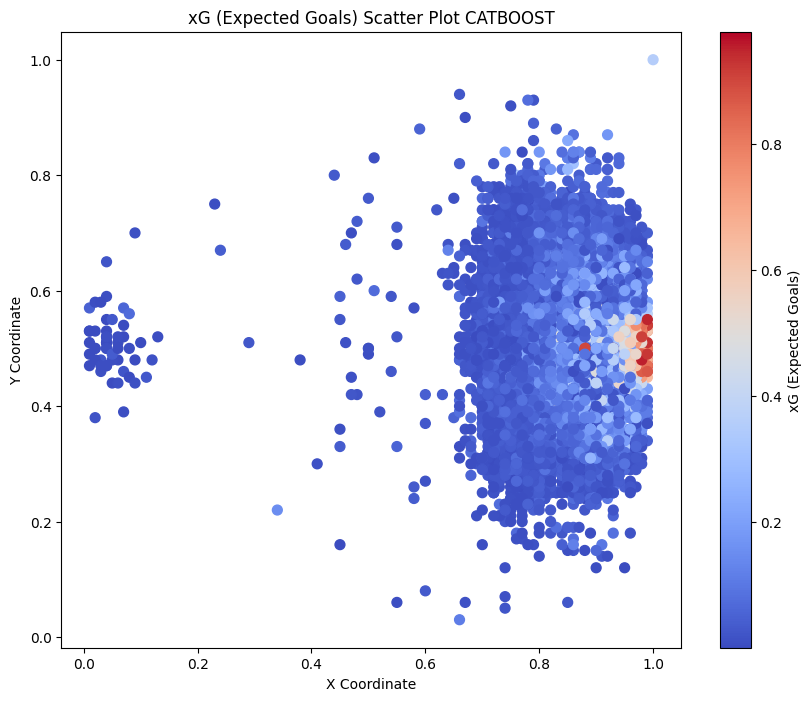

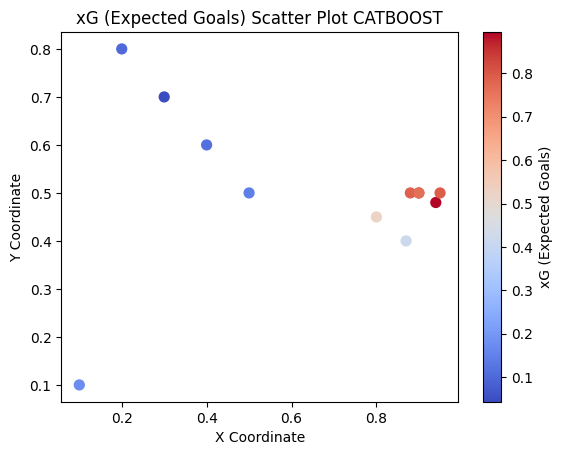

In [385]:
plt.figure(figsize=(10, 8))
#plt.scatter(data['X_coord'], data['Y_coord'], c=data['xG_calc_catboost'], cmap='coolwarm', s=50)
plt.scatter(X_test['X_coord'], X_test['Y_coord'], c=X_test['xG_calc_catboost'], cmap='coolwarm', s=50)
plt.colorbar(label='xG (Expected Goals)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('xG (Expected Goals) Scatter Plot CATBOOST')
plt.show()


plt.scatter(new_xG_data['X_coord'], new_xG_data['Y_coord'], c=new_xG_data_catboost['New xG'], cmap='coolwarm', s=50)
plt.colorbar(label='xG (Expected Goals)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('xG (Expected Goals) Scatter Plot CATBOOST')
plt.show()


In [386]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = testtrainsplit()
# Applying oversampling
X_train_resampled,y_train_resampled = sampling(X_train,y_train)
# Standardizing the features using scaler
scaler,X_train_scaled,X_train_scaled_resampled,X_test_scaled,X_data_scaled = scaling(X_train,X_train_resampled,X_test)

Sampling
Feature Scaling


In [387]:
# LSTM

# Reshaping data for LSTM input (samples, time steps, features)
#features_reshaped = features.values.reshape(features.shape[0], 1, features.shape[1])
features_reshaped = features.values.reshape(features.shape[0], 1, features.shape[1])

# X_train_reshaped = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
# X_test_reshaped = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

# X_train_reshaped = X_train_scaled.values.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
# X_test_reshaped = X_test_scaled.values.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

# Reshaping data for LSTM input (samples, time steps, features)
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])
#-----------------------------------------------------------------------------------------------
# X_train_reshaped = X_train_scaled_resampled.reshape(X_train_scaled_resampled.shape[0], 1, X_train_scaled_resampled.shape[1])
# X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])
#--------------------------------------------------------------------------------------------



#SAMPLED
# X_train_resampled_reshaped = X_train_resampled.values.reshape(X_train_resampled.shape[0], 1, X_train_resampled.shape[1])
# X_test_reshaped = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])




# Building LSTM lstm_model
lstm_model = Sequential()

lstm_model.add(LSTM(64, input_shape=(1, X_train_scaled.shape[1]), activation='relu'))
# lstm_model.add(LSTM(64, input_shape=(1, X_train_scaled_resampled.shape[1]), activation='relu'))   #SAMPLED

lstm_model.add(Dense(1, activation='sigmoid'))

# Compiling the lstm_model
lstm_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

#Traning the lstm_model
lstm_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_data=(X_test_reshaped, y_test))
# lstm_model.fit(X_train_reshaped, y_train_resampled, epochs=10, batch_size=32, validation_data=(X_test_reshaped, y_test))

#SAMPLED
# lstm_model.fit(X_train_resampled_reshaped, y_train_resampled, epochs=10, batch_size=32, validation_data=(X_test_reshaped, y_test))


# Predicting probabilities using the trained lstm_model
y_pred_proba = lstm_model.predict(X_test_reshaped)
# y_pred_proba = lstm_model.predict(X_test_reshaped)    #RESAMPLED

# xG_all_proba = lstm_model.predict(features_reshaped)
print(y_pred_proba)
# Calculate xG values based on predicted probabilities
# xg_values = y_pred_proba.flatten()
# xG_all = xG_all_proba.flatten()
X_test['xG_calc_lstm'] = y_pred_proba
# print(xG_all_proba)
# print("*********************************************************************")
# print(xG_all)


print("LSTM - Long Short Term Memory Model")

Epoch 1/10
1546/1546 [==============================] - 12s 6ms/step - loss: 0.3388 - accuracy: 0.8974 - val_loss: 0.3251 - val_accuracy: 0.8990
Epoch 2/10
1546/1546 [==============================] - 8s 5ms/step - loss: 0.3148 - accuracy: 0.9000 - val_loss: 0.3109 - val_accuracy: 0.8990
Epoch 3/10
1546/1546 [==============================] - 8s 5ms/step - loss: 0.3057 - accuracy: 0.9000 - val_loss: 0.3016 - val_accuracy: 0.8990
Epoch 4/10
1546/1546 [==============================] - 8s 5ms/step - loss: 0.2975 - accuracy: 0.9000 - val_loss: 0.2945 - val_accuracy: 0.8990
Epoch 5/10
1546/1546 [==============================] - 8s 5ms/step - loss: 0.2914 - accuracy: 0.9001 - val_loss: 0.2898 - val_accuracy: 0.8990
Epoch 6/10
1546/1546 [==============================] - 8s 5ms/step - loss: 0.2872 - accuracy: 0.9002 - val_loss: 0.3035 - val_accuracy: 0.8990
Epoch 7/10
1546/1546 [==============================] - 8s 5ms/step - loss: 0.2844 - accuracy: 0.9004 - val_loss: 0.2832 - val_accuracy

In [389]:
#MODEL EVALUATION METRICS
y_pred = (y_pred_proba > 0.5).astype(int)

print("Model Evaluation - LSTM ")


accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.2f}")
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.2f}")
#print(y_test,y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC: {roc_auc:.2f}")
mse = mean_squared_error(y_test, y_pred_proba)
print(f"Mean Squared Error: {mse:.2f}")
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)
log_loss_val = log_loss(y_test, y_pred_proba)
print("Log Loss value :", log_loss_val)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)
r2 = r2_score(y_test, y_pred_proba)
print("R-squared:", r2)
brier_score = brier_score_loss(y_test, y_pred_proba)
print("Brier Score :", brier_score)







Model Evaluation - LSTM 
Accuracy: 0.90
Precision: 0.74
Recall: 0.09
ROC AUC: 0.79
Mean Squared Error: 0.08
F1 Score: 0.16271186440677965
Log Loss value : 0.27966289410932815
Confusion Matrix:
 [[11008    43]
 [ 1192   120]]
R-squared: 0.15529224010747122
Brier Score : 0.08012981854954718


In [390]:
#LSTM xG Function

def calculate_xG_lstm(position_x, position_y,Y_coord_angle,is_penalty, is_header,is_home,is_OpenPlay,is_DirectFreekick,is_FromCorner,is_SetPiece,player_name,Last_Action,Team_rating,Opponent_rating):
    new_data_lstm = pd.DataFrame({
        'X_coord': [position_x],
        'Y_coord': [position_y],
        'Y_coord_angle' : [Y_coord_angle],
        'is_Penalty': [is_penalty],
        'is_head': [is_header],
        'is_home':[is_home],
        'is_OpenPlay' :[is_OpenPlay],
        'is_DirectFreekick' :[is_DirectFreekick],
        'is_FromCorner' :[is_FromCorner],
        'is_SetPiece' :[is_SetPiece],
        'overall' : [data.loc[data['Player name'] == player_name, 'overall'].values[0]],
        'value_eur' : [data.loc[data['Player name'] == player_name, 'value_eur'].values[0]],
        'shooting' : [data.loc[data['Player name'] == player_name, 'shooting'].values[0]],
        'Last_Action' : [Last_Action] ,
        'Team_rating' : [Team_rating],
        'Opponent_rating' : [Opponent_rating]
    })
    overall = new_data['overall']
    value_eur = new_data['value_eur']
    shooting = new_data['shooting']
    #Y_coord_angle = (1 - abs(position_y - 0.50) * 2)
    new_data_lstm_reshaped = new_data_lstm.values.reshape(new_data_lstm.shape[0], 1, new_data_lstm.shape[1])
    #scaled_features = scaler.transform([[position_x, position_y, Y_coord_angle,is_penalty, is_header,is_home]])
    scaled_features = scaler.transform([[position_x, position_y, Y_coord_angle,is_penalty, is_header,is_home,is_OpenPlay,is_DirectFreekick,is_FromCorner,is_SetPiece,overall,value_eur,shooting,Last_Action,Team_rating,Opponent_rating]])
    reshaped_features = scaled_features.reshape(1, 1, scaled_features.shape[1])
#   xG_probability = lstm_model.predict(new_data_lstm_reshaped)  # Probability of scoring a goal
    xG_probability = lstm_model.predict(reshaped_features)
    #xG_probability = lstm_model_s.predict_proba(new_data_lstm)[0, 1]
    #xg_prob = lstm_model_s.predict_proba(scaled_features)[:, 1]
    new_data_lstm['New xG']=xG_probability
    #new_data_lstm['New xG']=xg_prob
    #return xg_prob[0],new_data_lstm
    return xG_probability, new_data_lstm



new_xG_data_lstm = pd.DataFrame(columns=['X_coord','Y_coord','Y_coord_angle','is_Penalty','is_head','is_home',
                                   'is_OpenPlay','is_DirectFreekick','is_FromCorner','is_SetPiece',
                                   'overall','value_eur','shooting','Last_Action','Team_rating','Opponent_rating'])


#'overall','value_eur','shooting'

parameter_sets = [
    (0.88, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.90, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.94, 0.48,(1-abs(0.48-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.90, 0.50,(1-abs(0.50-0.50)*2),0, 0, 0,1,0,0,0,player_name,10,85,75),
    (0.95, 0.50,(1-abs(0.50-0.50)*2),0, 1, 1,1,0,0,0,player_name,10,85,75),
    (0.87, 0.40,(1-abs(0.40-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.80, 0.45,(1-abs(0.45-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.50, 0.50,(1-abs(0.50-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.40, 0.60,(1-abs(0.60-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.30, 0.70,(1-abs(0.70-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.20, 0.80,(1-abs(0.80-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75),
    (0.10, 0.10,(1-abs(0.10-0.50)*2),0, 0, 1,1,0,0,0,player_name,10,85,75)
]




# new_xG_data_lstm = []

for params in parameter_sets:
    xG_probability, new_data_lstm = calculate_xG_lstm(*params)
    new_xG_data_lstm=new_xG_data_lstm.append(new_data_lstm)

print(new_xG_data_lstm)



1/1 [==============================] - 0s 46ms/step
   X_coord  Y_coord  Y_coord_angle is_Penalty is_head is_home is_OpenPlay  \
0     0.88     0.50           1.00          0       0       1           1   
0     0.90     0.50           1.00          0       0       1           1   
0     0.94     0.48           0.96          0       0       1           1   
0     0.90     0.50           1.00          0       0       0           1   
0     0.95     0.50           1.00          0       1       1           1   
0     0.87     0.40           0.80          0       0       1           1   
0     0.80     0.45           0.90          0       0       1           1   
0     0.50     0.50           1.00          0       0       1           1   
0     0.40     0.60           0.80          0       0       1           1   
0     0.30     0.70           0.60          0       0       1           1   
0     0.20     0.80           0.40          0       0       1           1   
0     0.10     0.10     

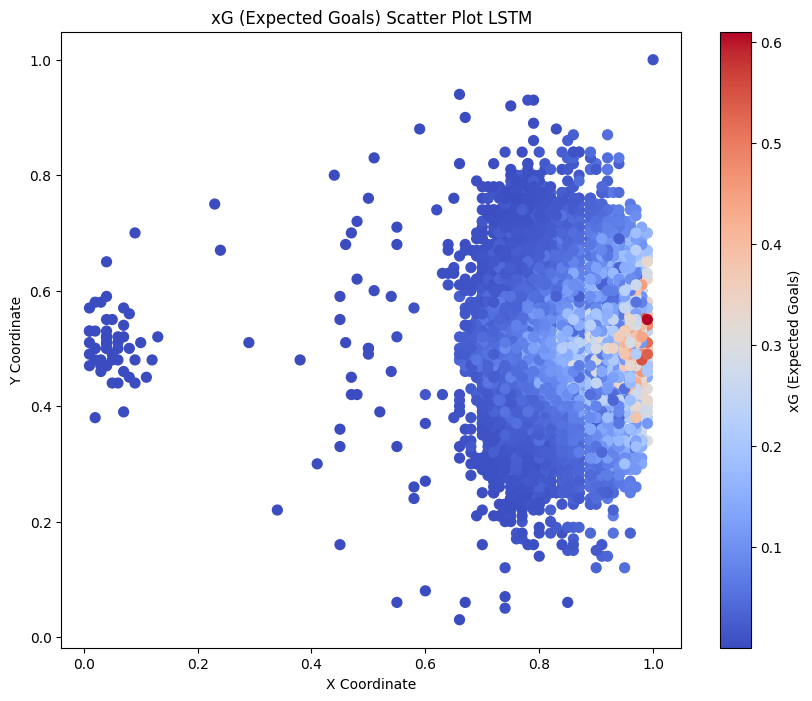

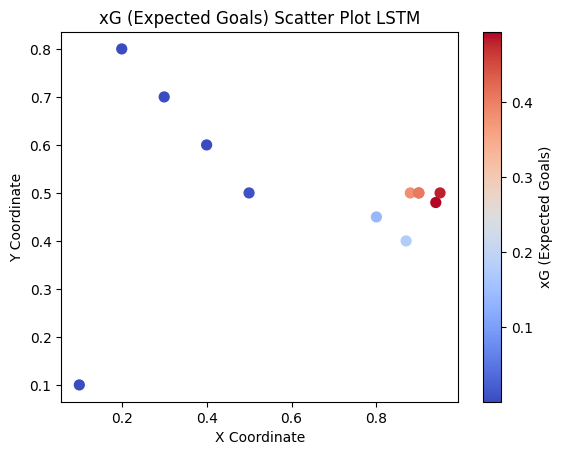

In [391]:
plt.figure(figsize=(10, 8))
#plt.scatter(data['X_coord'], data['Y_coord'], c=data['xG_calc_lstm'], cmap='coolwarm', s=50)
X_test = X_test[~((X_test['X_coord'] == 0.88))]
plt.scatter(X_test['X_coord'], X_test['Y_coord'], c=X_test['xG_calc_lstm'], cmap='coolwarm', s=50)
plt.colorbar(label='xG (Expected Goals)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('xG (Expected Goals) Scatter Plot LSTM')
plt.show()


plt.scatter(new_xG_data['X_coord'], new_xG_data['Y_coord'], c=new_xG_data_lstm['New xG'], cmap='coolwarm', s=50)
plt.colorbar(label='xG (Expected Goals)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('xG (Expected Goals) Scatter Plot LSTM')
plt.show()


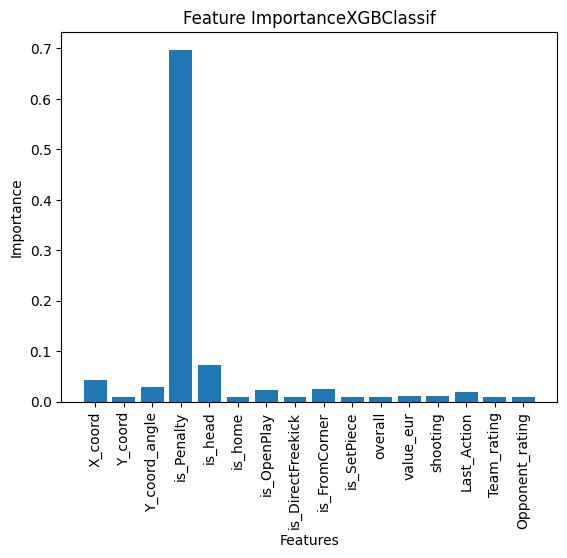

X_coord: 0.042846474796533585
Y_coord: 0.009489663876593113
Y_coord_angle: 0.02889627404510975
is_Penalty: 0.6974268555641174
is_head: 0.0717882439494133
is_home: 0.008652043528854847
is_OpenPlay: 0.02410558983683586
is_DirectFreekick: 0.009383199736475945
is_FromCorner: 0.025851134210824966
is_SetPiece: 0.010346527211368084
overall: 0.010255131870508194
value_eur: 0.01074317004531622
shooting: 0.011253182776272297
Last_Action: 0.019942384213209152
Team_rating: 0.0096462182700634
Opponent_rating: 0.009373907931149006


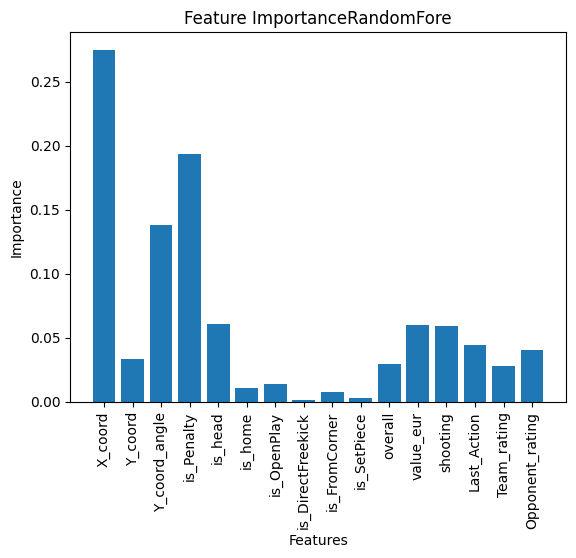

X_coord: 0.27501517880777676
Y_coord: 0.03334884845229412
Y_coord_angle: 0.13815292656013467
is_Penalty: 0.19390674521222614
is_head: 0.06049506086441914
is_home: 0.011075308900505391
is_OpenPlay: 0.014136782959518373
is_DirectFreekick: 0.001574872474808139
is_FromCorner: 0.007706206237091511
is_SetPiece: 0.0026043775629995968
overall: 0.029705251066787643
value_eur: 0.060061386798703216
shooting: 0.058783656111652934
Last_Action: 0.044418423686705226
Team_rating: 0.02828373218980433
Opponent_rating: 0.04073124211457277


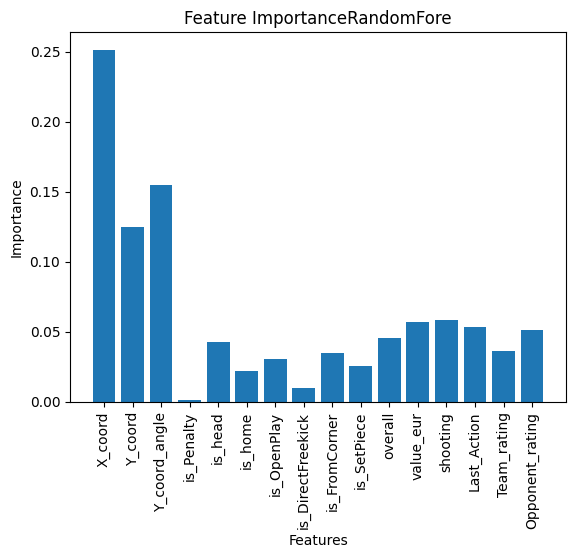

X_coord: 0.2513354751381218
Y_coord: 0.1246367993469432
Y_coord_angle: 0.15493761464596406
is_Penalty: 0.0015808918692628731
is_head: 0.04248696744301918
is_home: 0.021802462950997185
is_OpenPlay: 0.03069057104153696
is_DirectFreekick: 0.010151988531269448
is_FromCorner: 0.03484474382507299
is_SetPiece: 0.02547676977934791
overall: 0.04519704611444215
value_eur: 0.056964372491480564
shooting: 0.058571160034265185
Last_Action: 0.053597663504064356
Team_rating: 0.03618023819756005
Opponent_rating: 0.051545235086652104


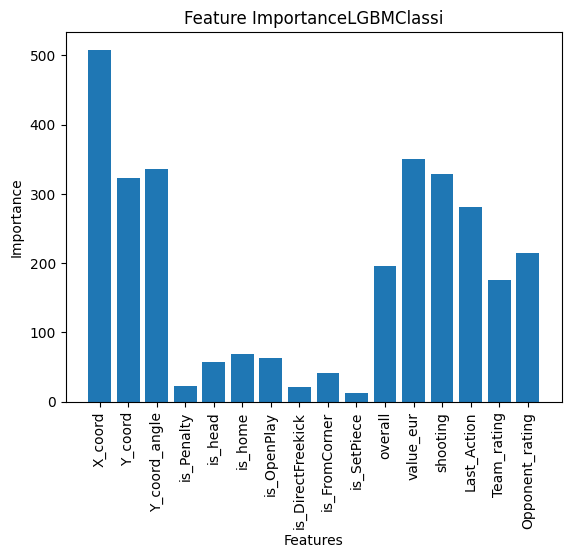

X_coord: 0.16933333333333334
Y_coord: 0.10766666666666666
Y_coord_angle: 0.112
is_Penalty: 0.007333333333333333
is_head: 0.019333333333333334
is_home: 0.023
is_OpenPlay: 0.021
is_DirectFreekick: 0.007
is_FromCorner: 0.013666666666666667
is_SetPiece: 0.004333333333333333
overall: 0.06533333333333333
value_eur: 0.117
shooting: 0.10966666666666666
Last_Action: 0.09366666666666666
Team_rating: 0.058333333333333334
Opponent_rating: 0.07133333333333333


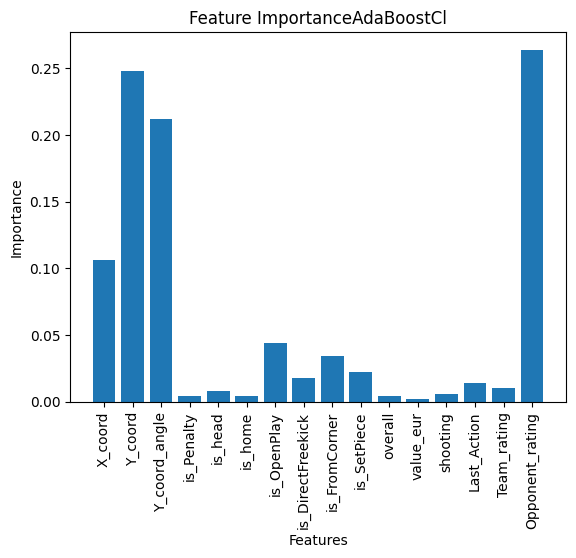

X_coord: 0.106
Y_coord: 0.248
Y_coord_angle: 0.212
is_Penalty: 0.004
is_head: 0.008
is_home: 0.004
is_OpenPlay: 0.044
is_DirectFreekick: 0.018
is_FromCorner: 0.034
is_SetPiece: 0.022
overall: 0.004
value_eur: 0.002
shooting: 0.006
Last_Action: 0.014
Team_rating: 0.01
Opponent_rating: 0.264


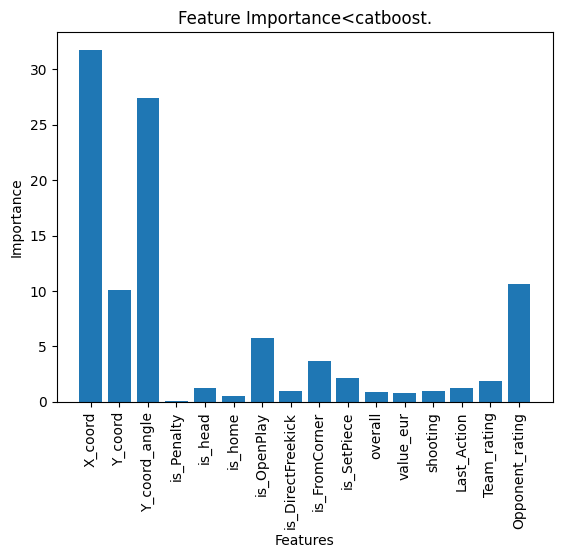

X_coord: 0.3176856823099586
Y_coord: 0.10062259543787005
Y_coord_angle: 0.2744904248391688
is_Penalty: 0.00037725084156611647
is_head: 0.012490377372335925
is_home: 0.005367088855580253
is_OpenPlay: 0.05723941720644228
is_DirectFreekick: 0.00980156833515589
is_FromCorner: 0.03674729395060771
is_SetPiece: 0.02164411933608931
overall: 0.008672796539429994
value_eur: 0.007926834593695807
shooting: 0.009675584032285113
Last_Action: 0.01255397362197282
Team_rating: 0.01826831920598448
Opponent_rating: 0.1064366735218569


In [392]:
# Calculating feature importance

def calculate_feature_importance(best_model):
    feature_importances = best_model.feature_importances_
    # Plot feature importance
    plt.bar(range(len(feature_importances)), feature_importances)
    plt.xticks(range(len(feature_importances)), features.columns, rotation='vertical')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Feature Importance'+str(best_model)[:10])
    plt.show()
    # Assign weights to features based on their importance
    feature_weights = feature_importances / feature_importances.sum()
    # Print feature weights
    for feature, weight in zip(features.columns, feature_weights):
        print(f"{feature}: {weight}")

calculate_feature_importance(xgb_s)
calculate_feature_importance(best_random_forest_model)
calculate_feature_importance(best_rf_model)
calculate_feature_importance(final_lgb_model)
calculate_feature_importance(final_adaboost_model)
calculate_feature_importance(final_catboost_model)
#calculate_feature_importance(lstm_model)

# calculate_feature_importance(xgb_s)
# calculate_feature_importance(random_forest_model_s)
# calculate_feature_importance(rf_model_s)
# calculate_feature_importance(lgb_model_s)
# calculate_feature_importance(adaboost_model_s)
# calculate_feature_importance(catboost_model_s)
    
    
#feature_importances = xgb_s.feature_importances_
#feature_importances = adaboost_model.feature_importances_
#feature_importances = lgb_model.feature_importances_
#feature_importances = catboost_model.feature_importances_
#feature_importances = rf_model.feature_importances_
#feature_importances = random_forest_model_s.feature_importances_



X_coord: 13.657375108429509
Y_coord: 0.22775260522849064
Y_coord_angle: 4.683025052453384
is_Penalty: 1.8592326636344065
is_head: -0.8364469071250671
is_home: 0.023549614999306922
is_OpenPlay: -0.41456488995248847
is_DirectFreekick: 0.361475799268069
is_FromCorner: -0.8670318592477526
is_SetPiece: -0.6250503400146583
overall: 0.5804514856093992
value_eur: 0.1772246787218135
shooting: 0.6587651029693844
Last_Action: 0.1866790027460069
Team_rating: 0.12401058271885974
Opponent_rating: -0.17341903733077196


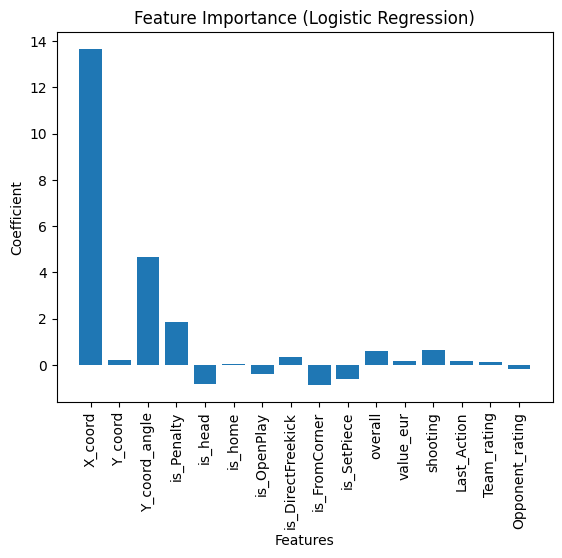

In [393]:
# Calculating feature importance (coefficients) of LOGISTIC REGRESSION MODEL
# feature_importance = logreg_model_s.coef_[0]
feature_importance = final_logreg_model.coef_[0]

for feature, importance in zip(features.columns, feature_importance):
    print(f"{feature}: {importance}")

# Visualize feature importance
plt.bar(range(len(feature_importance)), feature_importance)
plt.xticks(range(len(feature_importance)), features.columns, rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.title('Feature Importance (Logistic Regression)')
plt.show()

Permutation explainer: 12364it [13:55, 14.68it/s]                                                                      


Instance Features:
X_coord                    0.86
Y_coord                    0.40
Y_coord_angle              0.80
is_Penalty                 0.00
is_head                    0.00
is_home                    0.00
is_OpenPlay                1.00
is_DirectFreekick          0.00
is_FromCorner              0.00
is_SetPiece                0.00
overall                   72.00
value_eur            2900000.00
shooting                  61.00
Last_Action               10.00
Team_rating               80.00
Opponent_rating           83.00
Name: 34548, dtype: float64
SHAP Values:
.values =
array([ 0.06714273,  0.0800162 ,  0.02423048,  0.00601506,  0.03558177,
        0.03546802, -0.11859388,  0.05666154,  0.07480694,  0.0426814 ,
        0.0267894 , -0.02106018, -0.00963475, -0.03228577,  0.00505068,
       -0.00758702])

.base_values =
array([0.21858965])

.data =
array([0.85858586, 0.375     , 0.8       , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
  

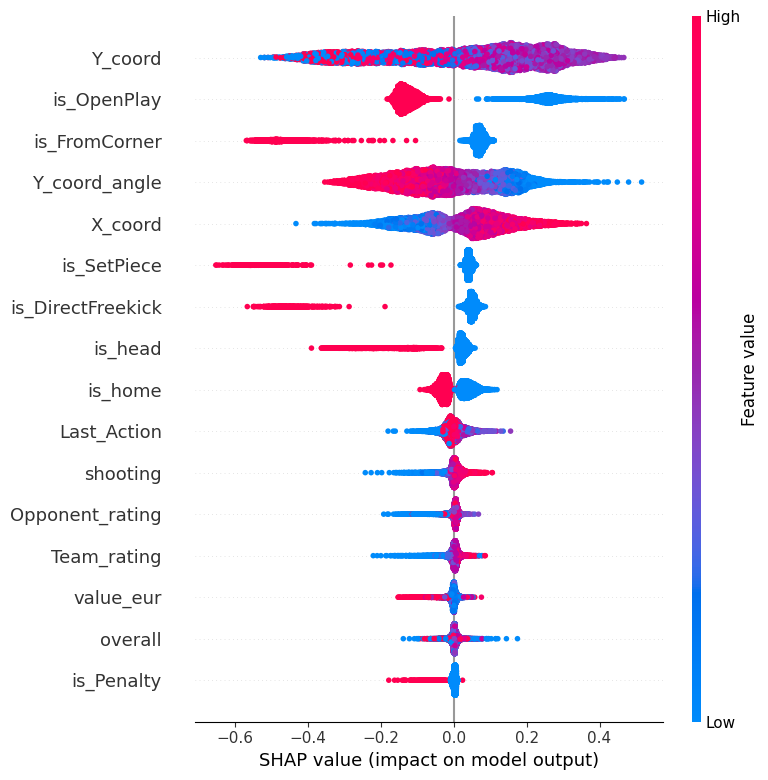

In [407]:
#FEATURE IMPORTANCE OF ANN MODEL


# Calculating SHAP values
explainer = shap.Explainer(ann_model, X_train_scaled)
shap_values = explainer(X_test_scaled)

# Printing feature values for a specific instance (index)
instance_index = 0  # Change this to the desired instance index
instance_features = X_test.iloc[instance_index]
print("Instance Features:")
print(instance_features)

# Printing SHAP values for the same instance
shap_instance_values = shap_values[instance_index]
print("SHAP Values:")
print(shap_instance_values)

# Summary plot of feature importance using SHAP
shap.summary_plot(shap_values, X_test_scaled, feature_names=features.columns)
plt.show()



In [396]:
#Loading xG values into the dataframe for each model

#xG_all_xgb = final_xgb_model.predict_proba(X_data_scaled)[:, 1]
xG_all_xgb = xgb_s.predict_proba(X_data_scaled)[:, 1]
data['xG_calc_xgb'] = xG_all_xgb


xG_all_LR = final_logreg_model.predict_proba(X_data_scaled)[:, 1]
#xG_all_LR = logreg_model_s.predict_proba(X_data_scaled)[:, 1]
data['xG_calc_LR'] = xG_all_LR


xG_all_RFR = best_random_forest_model.predict(X_data_scaled)
#xG_all_RFR = random_forest_model_s.predict(X_data_scaled)
data['xG_calc_RFR'] = xG_all_RFR

xG_all_RFC = best_rf_model.predict_proba(X_data_scaled)[:, 1]
#xG_all_RFC = rf_model_s.predict_proba(X_data_scaled)[:, 1]
data['xG_calc_RFC'] = xG_all_RFC


xG_all_ANN = best_ann_model.predict_proba(X_data_scaled)[:, 1]
#xG_all_ANN = ann_model.predict_proba(X_data_scaled)[:, 1]
data['xG_calc_ANN'] = xG_all_ANN

#xG_all_LGB = final_lgb_model.predict_proba(X_data_scaled)[:, 1]
xG_all_LGB = lgb_model_s.predict_proba(X_data_scaled)[:, 1]
data['xG_calc_LGB'] = xG_all_LGB


xG_all_adaboost = final_adaboost_model.predict_proba(X_data_scaled)[:, 1]
#xG_all_adaboost = adaboost_model_s.predict_proba(X_data_scaled)[:, 1]
data['xG_calc_adaboost'] = xG_all_adaboost


xG_all_catboost = final_catboost_model.predict_proba(X_data_scaled)[:, 1]
#xG_all_catboost = catboost_model_s.predict_proba(X_data_scaled)[:, 1]
data['xG_calc_catboost'] = xG_all_catboost



#reshaped_features = scaled_features.reshape(1, 1, scaled_features.shape[1])
X_data_reshaped = X_data_scaled.reshape(X_data_scaled.shape[0], 1, X_data_scaled.shape[1])
xG_all_LSTM = lstm_model.predict(X_data_reshaped)
data['xG_calc_LSTM'] = xG_all_LSTM


print("xG values of models loaded into the dataframe")



1932/1932 [==============================] - 5s 3ms/step
xG values of models loaded into the dataframe


In [397]:
# Split the data into training and testing sets before LSTM MODEL
#X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

# Apply oversampling using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# ros = RandomOverSampler(random_state=42)
# X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# oversampler = SMOTE(sampling_strategy='auto', random_state=42)
# X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

#Apply undersampling using Tomek links
# undersampler = TomekLinks(sampling_strategy='majority')
# X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_resampled, y_train_resampled)

print("Sampling")


# Standardize the features
#scaler = StandardScaler()
scaler = MinMaxScaler()
#scaler = RobustScaler()
#scaler = QuantileTransformer(output_distribution='normal')
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled_resampled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)
X_data_scaled = scaler.transform(features)  # Scale the entire feature matrix
print("Feature Scaling")

Sampling
Feature Scaling


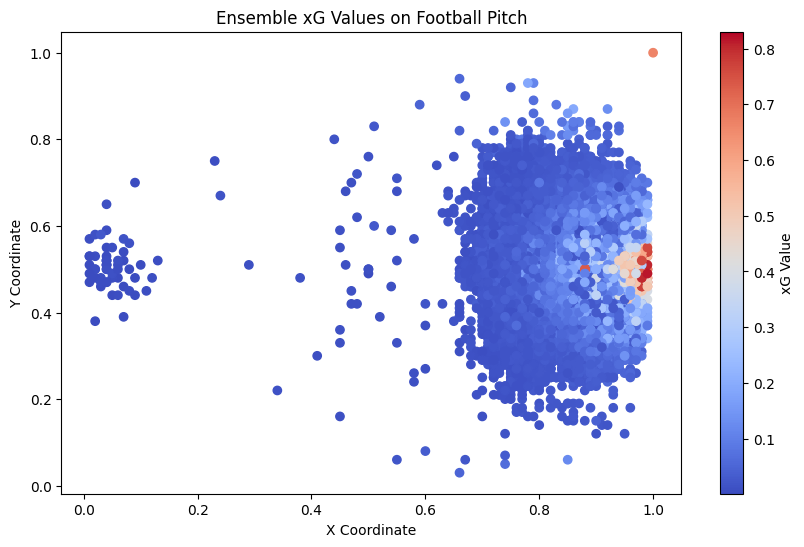

In [398]:
#CREATE AN ENSEMBLE MODEL TO PREDCIT THE xG VALUES

# Create an ensemble model of XGBoost and CatBoost
# ensemble_model = VotingClassifier([('xgb', final_xgb_model), ('lgbm', final_lgb_model)] , voting = 'soft')
ensemble_model = VotingClassifier([('xgb', final_xgb_model), ('ann', best_ann_model)] , voting = 'soft')

# Fit the ensemble model
ensemble_model.fit(X_train_scaled, y_train)

# Calculate xG values using the ensemble model
xG_values_ensemble = ensemble_model.predict_proba(X_test_scaled)[:, 1]


# Plot xG values using a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(X_test['X_coord'], X_test['Y_coord'], c=xG_values_ensemble, cmap='coolwarm')
plt.colorbar(label='xG Value')
plt.title('Ensemble xG Values on Football Pitch')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()


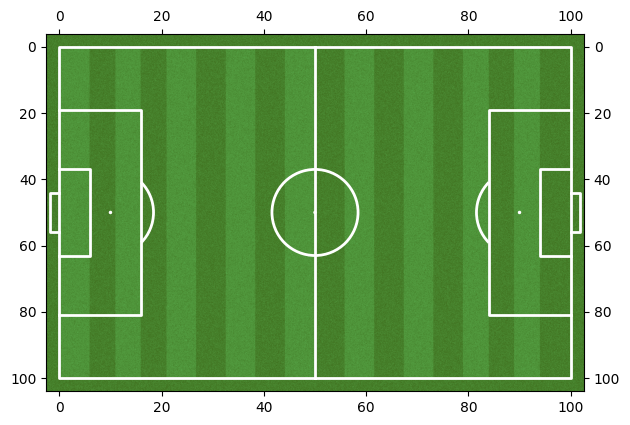

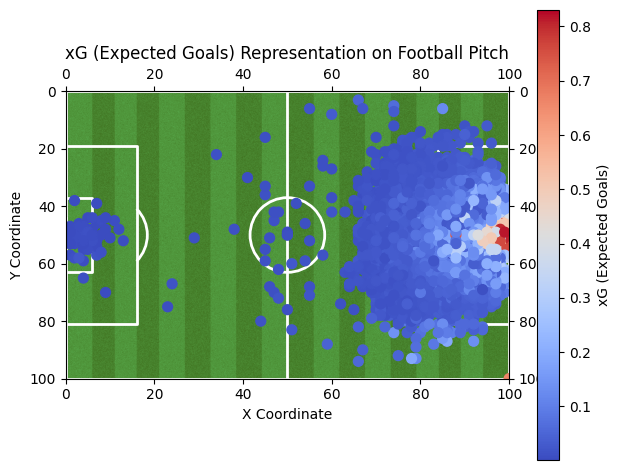

In [399]:
#FOOTBALL PITCH

def plot_football_pitch():
    #fig, ax = plt.subplots(figsize=(10, 6))
    pitch = Pitch(pitch_color='grass', stripe = True, pitch_type = 'wyscout', line_color = 'white', goal_type = 'box',label = True,  axis = True, tick = True)
    fig, ax = pitch.draw()
    #plt.show()
    
    # Plotting the football pitch
#     ax.plot([0, 1], [0, 0], color='black', linewidth=2)  # Goal line
#     ax.plot([0, 0], [0, 1], color='black', linewidth=2)  # Left touchline
#     ax.plot([1, 1], [0, 1], color='black', linewidth=2)  # Right touchline
#     ax.plot([0, 1], [1, 1], color='black', linewidth=2)  # Bottom line
    
    # Plotting the penalty area
#     ax.plot([0.25, 0.25], [1.00, 0.817], color='black', linewidth=2)  # Left goal box line
#     ax.plot([0.75, 0.75], [1.00, 0.817], color='black', linewidth=2)  # Right goal box line
#     ax.plot([0.25, 0.75], [0.817, 0.817], color='black', linewidth=2)  # Top goal box line
#     ax.plot([0.75, 0.75], [0, 0.183], color='black', linewidth=2)  # Right goal box line
#     ax.plot([0.25, 0.25], [0, 0.183], color='black', linewidth=2)  # Left goal box line
#     ax.plot([0.75, 0.25], [0.183, 0.183], color='black', linewidth=2)  # Top goal box line
    
    # Plotting the penalty spot
    #ax.scatter(0.885, 0.50, color='black', s=100)
    ax.scatter(88.5, 50, color='black', s=100)
    
    # Plotting the xG values
    sc = ax.scatter(X_test['X_coord']*100, X_test['Y_coord']*100, c=xG_values_ensemble, cmap='coolwarm', s=50)
    #cbar = plt.colorbar(scatter, ax=ax, label='xG (Expected Goals)')
    
    # Set the axis limits and labels
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_title('xG (Expected Goals) Representation on Football Pitch')
    
    cbar = plt.colorbar(sc)
    cbar.set_label('xG (Expected Goals)')
    
    plt.gca().invert_yaxis() 
    plt.show()

# Plotting the football pitch with xG values
pitch = Pitch(pitch_color='grass', stripe = True, pitch_type = 'wyscout', line_color = 'white', goal_type = 'box',label = True,  axis = True, tick = True)
fig, ax = pitch.draw()
plt.show()
plot_football_pitch()

In [400]:
output_file_path1 = "C:/Users/Vignesh Venkataraman/OneDrive/Desktop/Msc DATA SCIENCE/Dissertation/Dataframe_mod/modified_dataset_xg.csv"


data.to_csv(output_file_path, index=False)
print("Result Dataset exported")

Result Dataset exported


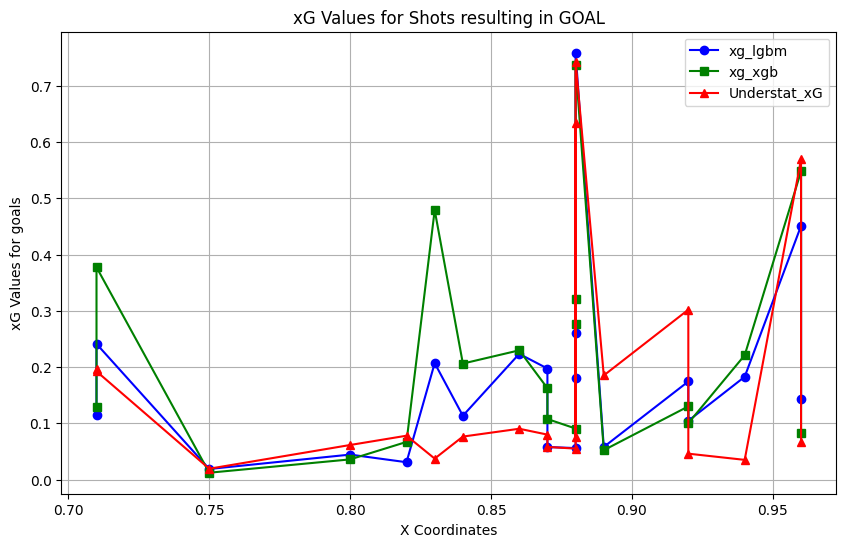

In [401]:
#Plotting line graphs of the models


# Filter rows where is_goal equals 1
goaldf = data[data['is_goal'] == 1]
goal_df = goaldf.tail(20)
goal_df = goal_df.sort_values(by=["X_coord", "Y_coord"])
# print(goal_df)



# Create line plots
plt.figure(figsize=(10, 6))
plt.plot(goal_df['X_coord'], goal_df['xG_calc_LGB'], label='xg_lgbm', color='blue', marker='o')

#plt.plot(goal_df['X_coord'], goal_df['xG_calc_LR'], label='xg_LR', color='blue', marker='o')
#plt.plot(goal_df['X_coord'], goal_df['xG_calc_RFR'], label='xG_RFR', color='blue', marker='o')
#plt.plot(goal_df['X_coord'], goal_df['xG_calc_RFC'], label='xG_RFC', color='blue', marker='o')
#plt.plot(goal_df['X_coord'], goal_df['xG_calc_ANN'], label='xG_ANN', color='blue', marker='o')
#plt.plot(goal_df['X_coord'], goal_df['xG_calc_adaboost'], label='xG_adaboost', color='blue', marker='o')
#plt.plot(goal_df['X_coord'], goal_df['xG_calc_catboost'], label='xG_catboost', color='blue', marker='o')
#plt.plot(goal_df['X_coord'], goal_df['xG_calc_LSTM'], label='xG_LSTM', color='blue', marker='o')


plt.plot(goal_df['X_coord'], goal_df['xG_calc_xgb'], label='xg_xgb', color='green', marker='s')
plt.plot(goal_df['X_coord'], goal_df['xG'], label='Understat_xG', color='red', marker='^')

# Customize the plot
plt.title('xG Values for Shots resulting in GOAL')
plt.xlabel('X Coordinates')
plt.ylabel('xG Values for goals')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

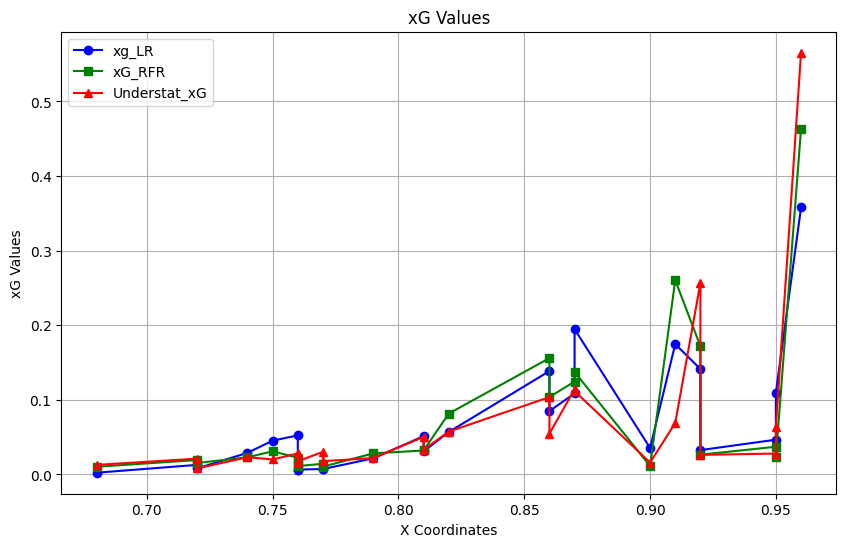

In [402]:
#Plotting line graphs of the models


# Filter rows where is_goal equals 1
goaldf_0 = data[data['is_goal'] == 0]
goaldf_0 = goaldf_0[goaldf_0["X_coord"] != 0.88]
goal_df_0 = goaldf_0.tail(25)
goal_df_0 = goal_df_0.sort_values(by=["X_coord", "Y_coord"])
# print(goal_df_0)



# Creating line plots
plt.figure(figsize=(10, 6))
# plt.plot(goal_df_0['X_coord'], goal_df_0['xG_calc_LGB'], label='xg_lgbm', color='green', marker='s')
plt.plot(goal_df_0['X_coord'], goal_df_0['xG_calc_LR'], label='xg_LR', color='blue', marker='o')
# plt.plot(goal_df_0['X_coord'], goal_df_0['xG_calc_ANN'], label='xG_ANN', color='green', marker='s')
plt.plot(goal_df_0['X_coord'], goal_df_0['xG_calc_RFR'], label='xG_RFR', color='green', marker='s')
#plt.plot(goal_df_0['X_coord'], goal_df_0['xG_calc_adaboost'], label='xG_adaboost', color='green', marker='s')
# plt.plot(goal_df_0['X_coord'], goal_df_0['xG_calc_catboost'], label='xG_catboost', color='green', marker='s')
# plt.plot(goal_df_0['X_coord'], goal_df_0['xG_calc_LSTM'], label='xG_LSTM', color='green', marker='s')


# plt.plot(goal_df_0['X_coord'], goal_df_0['xG_calc_xgb'], label='xg_xgb', color='green', marker='s')
plt.plot(goal_df_0['X_coord'], goal_df_0['xG'], label='Understat_xG', color='red', marker='^')

# Customizing the plot
plt.title('xG Values')
plt.xlabel('X Coordinates')
plt.ylabel('xG Values')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

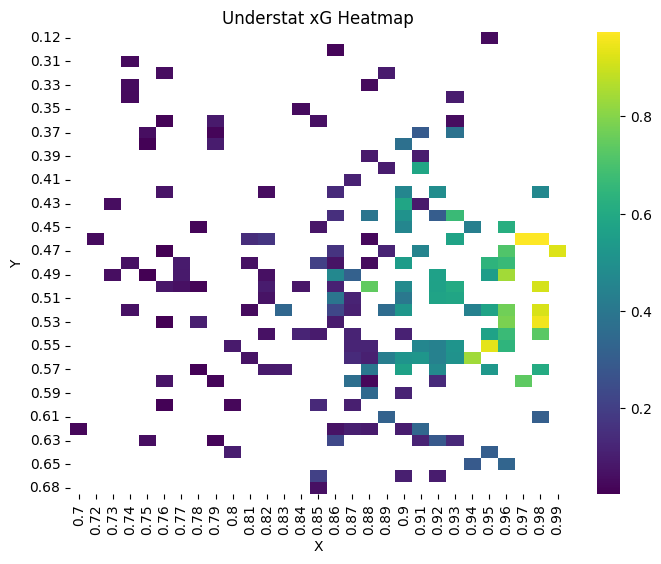

In [403]:
# Pivot the DataFrame to create a heatmap data structure of xG values

heat_data1 = data[data['Player name'] == "lionel messi"]
heat_data1 = heat_data1[heat_data1['is_goal'] == 1]
heat_data1 = heat_data1.drop_duplicates(subset=["X_coord", "Y_coord"])
heatmap_data = heat_data1.pivot(index="Y_coord", columns="X_coord", values="xG")
# heatmap_data = heat_data.pivot(index="X_coord", columns="Y_coord", values="xG")

# Creating a heatmap for xG values
plt.figure(figsize=(8, 6))
# sns.heatmap(heatmap_data, annot=False, cmap="YlGnBu", cbar=True)
sns.heatmap(heatmap_data, annot=False, cmap="viridis", cbar=True)
plt.title("Understat xG Heatmap")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

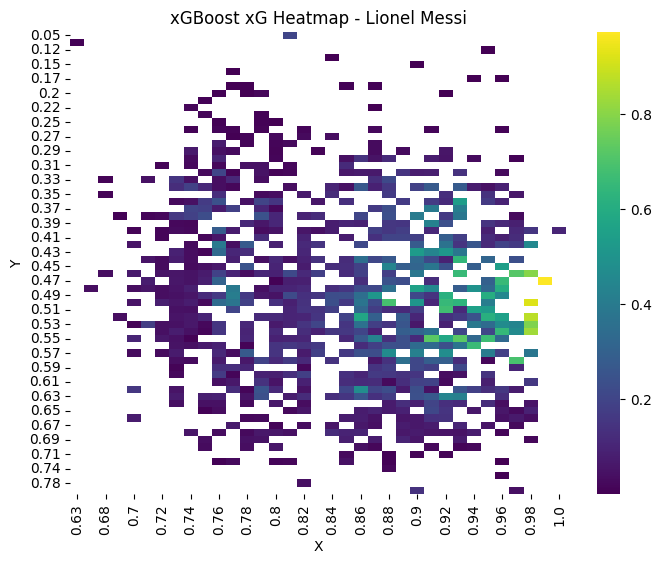

In [404]:
# Pivot the DataFrame to create a heatmap data structure of xG values

heat_data = data[data['Player name'] == "lionel messi"]
heat_data = heat_data.drop_duplicates(subset=["X_coord", "Y_coord"])
heatmap_data = heat_data.pivot(index="Y_coord", columns="X_coord", values="xG_calc_xgb")
# heatmap_data = heat_data.pivot(index="X_coord", columns="Y_coord", values="xG")

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
# sns.heatmap(heatmap_data, annot=False, cmap="YlGnBu", cbar=True)
sns.heatmap(heatmap_data, annot=False, cmap="viridis", cbar=True)
plt.title("xGBoost xG Heatmap - Lionel Messi")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

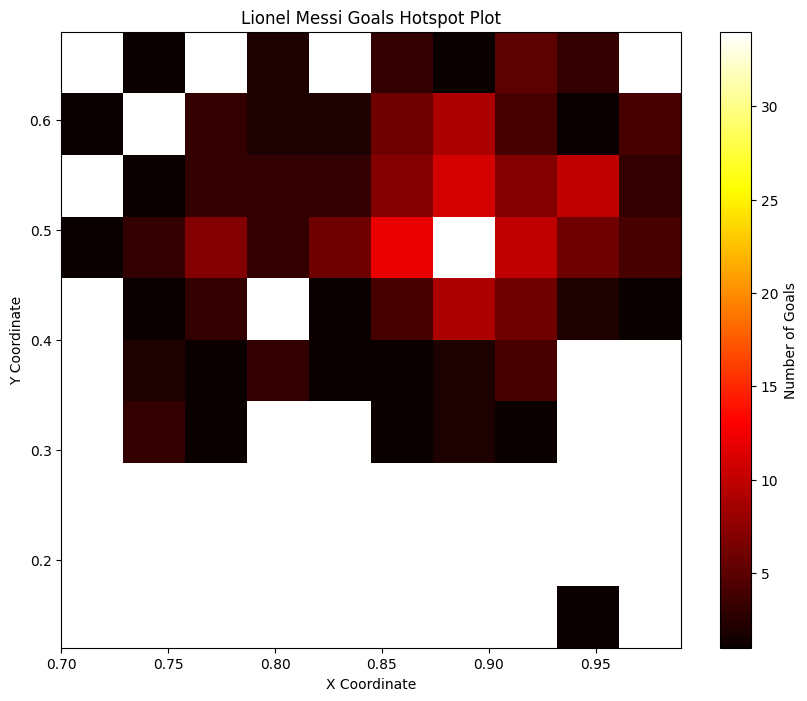

In [405]:
# Plotting hotspot for goals of Lionel Messi


hotspot_data1 = data[data['Player name'] == "lionel messi"]
hotspot_data1 = hotspot_data1[hotspot_data1['is_goal'] == 1]
plt.figure(figsize=(10, 8))
plt.hist2d(hotspot_data1["X_coord"], hotspot_data1["Y_coord"], bins=(10, 10), cmap="hot", cmin=1)
plt.colorbar(label="Number of Goals")
plt.title("Lionel Messi Goals Hotspot Plot")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()

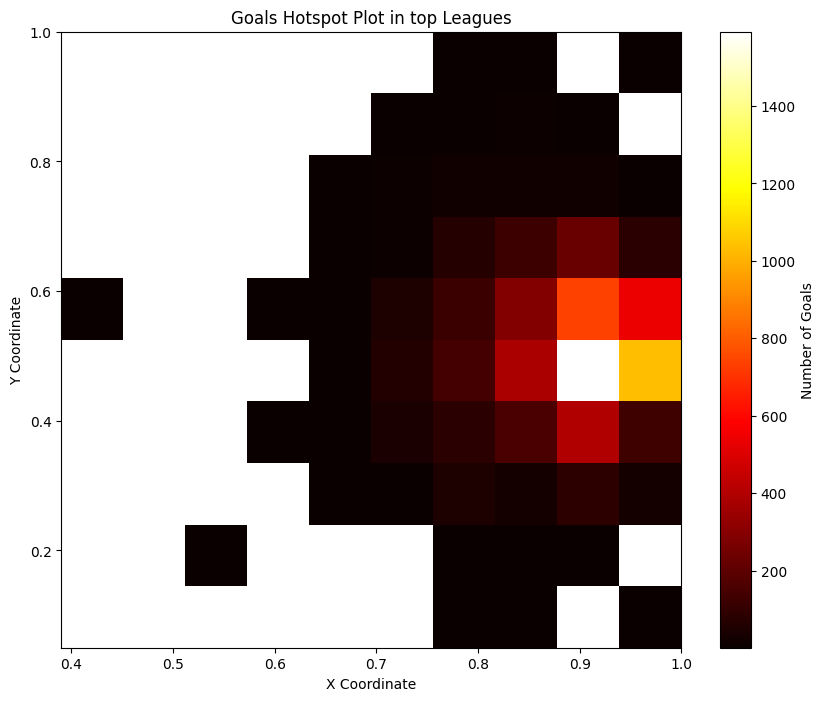

In [406]:
# Plot hotspot for goals

hotspot_data_all_goals = data[data['is_goal'] == 1]
plt.figure(figsize=(10, 8))
plt.hist2d(hotspot_data_all_goals["X_coord"], hotspot_data_all_goals["Y_coord"], bins=(10, 10), cmap="hot", cmin=1)
plt.colorbar(label="Number of Goals")
plt.title("Goals Hotspot Plot in top Leagues")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()